In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'personal-key-indicators-of-heart-disease:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1936563%2F3191579%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240605%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240605T114306Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9f44d8c5f8a314fd4c1b73f2ba1376b0d28ce49adb0ad5d1adc4b8db8275b79b71d1b9ea304523852faf2795c58a8e55c2fe9c71d9f977449be107a35e94250937171de47fd36dc722dc568b0bdd1a7c056e7609764b0ef6643652d076b1b59940216fa9d079c35b7179cb553a4c8894ef50ed1f496b5e4c8e69a3f35a888ddd3d0ce980168a06695815e15fa1ac1aca054745c041c8df2d2679e662d1a98595be23ab4d48115e9848e169a5d3314139f77e8639e3399feff2d446636c4ea0ea17c2e3759f96a061d15cd67aa39228bad7f8f7c3e4840b60506422ae10c393189faa88c60150d027d48e24b89dc7c5b6c73dcd001e12cd6b47e909b12e51d3ca'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


<img
src="https://github.com/mayaunnikrishnan/exploration-of-heart-disease-data/blob/d37abb08afa501b0fec91d7cc04e240a163a3dbb/Exploring%20Heart%20Disease%20Data.gif?raw=true">

<img
src="https://github.com/mayaunnikrishnan/exploration-of-heart-disease-data/blob/d37abb08afa501b0fec91d7cc04e240a163a3dbb/Exploring%20Heart%20Disease%20Data%20(1).gif?raw=true">

## Table of Contents

* READING DATA SET  
* SUMMURY OF FEATURES   
* DATA CLEANING   
* EXPLORING DATA ANALYSIS AND VISUALIZATION  
* DATA PREPROCESSING    
    -LABEL ENCODING     
    -TRAIN TEST SPLIT  
    -STANDARDISING THE DATA SET  
* MODELING  
    -FINDING THE BEST MODEL USING GRID SEARCH CV  
    -MODEL OF RANDOM FOREST CLASSIFIER  
    -PREDICTION OF THE MODEL  
    -EXPORT THE TEST MODEL TO A PICKLE FILE  
* STREAMLIT MACHINE LEARNING MODEL APP  
* CONCLUSION  

<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Reading data set</p>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atomproton","key":"ee3de6c82444a5bfdca53fb7a5934d96"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease

# Unzip the dataset
!unzip personal-key-indicators-of-heart-disease.zip

Dataset URL: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
License(s): CC0-1.0
 47% 10.0M/21.4M [00:00<00:00, 47.2MB/s]
100% 21.4M/21.4M [00:00<00:00, 82.9MB/s]
Archive:  personal-key-indicators-of-heart-disease.zip
  inflating: 2020/heart_2020_cleaned.csv  
  inflating: 2022/heart_2022_no_nans.csv  
  inflating: 2022/heart_2022_with_nans.csv  


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Load the heart_2020_cleaned.csv dataset
df = pd.read_csv('2020/heart_2020_cleaned.csv')

# Display the first few rows of the DataFrame
df.head()


HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

## features
* no null values
* 14-object type features
* 4-Numerical type features      
To ensure that there are no missing values in the dataset, we carry out the following operations.

In [ ]:
df.shape

(319795, 18)

<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Summary of Features</p>

In [ ]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [ ]:
df.describe().T.style.set_properties(**{'background-color': 'grey','color': 'white','border-color': 'white'})


<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Data cleaning</p>

In [ ]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
df.isnull().values.any()

False

In [ ]:
df.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

In [ ]:
df['HeartDisease'].value_counts()

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

In [ ]:
data = pd.concat([
    df[df['HeartDisease'] == 'No'].sample(n=27373, replace=True),
    df[df['HeartDisease'] == 'Yes']
])

In [ ]:
data['HeartDisease'].value_counts()

HeartDisease
No     27373
Yes    27373
Name: count, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54746 entries, 179758 to 319790
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      54746 non-null  object 
 1   BMI               54746 non-null  float64
 2   Smoking           54746 non-null  object 
 3   AlcoholDrinking   54746 non-null  object 
 4   Stroke            54746 non-null  object 
 5   PhysicalHealth    54746 non-null  float64
 6   MentalHealth      54746 non-null  float64
 7   DiffWalking       54746 non-null  object 
 8   Sex               54746 non-null  object 
 9   AgeCategory       54746 non-null  object 
 10  Race              54746 non-null  object 
 11  Diabetic          54746 non-null  object 
 12  PhysicalActivity  54746 non-null  object 
 13  GenHealth         54746 non-null  object 
 14  SleepTime         54746 non-null  float64
 15  Asthma            54746 non-null  object 
 16  KidneyDisease     54746 non-null  objec

### The next step involves identifying the distinct values for each feature in the dataset.

In [ ]:
np.unique(data[['HeartDisease', 'Smoking','AlcoholDrinking','Stroke','DiffWalking','PhysicalActivity',
               'Asthma','KidneyDisease','SkinCancer']].values)

array(['No', 'Yes'], dtype=object)

There are 9 columns in the dataset where the unique values are either "yes" or "no".  
1.'HeartDisease',  
2.'Smoking',  
3.'AlcoholDrinking',   
4.'Stroke',   
5.'DiffWalking',   
6.'PhysicalActivity',   
7.'Asthma',   
8.'KidneyDisease',   
9.'SkinCancer'   

In [ ]:
data.Sex.unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
data.PhysicalHealth.unique()

array([ 0., 10.,  1.,  2., 30.,  7., 15.,  3.,  4., 14., 27.,  5., 25.,
        6., 28., 20., 12.,  9., 11.,  8., 29., 26., 21., 22., 17., 24.,
       13., 16., 18., 19., 23.])

The question is related to the respondent's physical health and asks them to recall how many days in the past 30 days their physical health was not good due to illness or injury, with possible responses ranging from 0 to 30 days.

In [ ]:
data.MentalHealth.unique()

array([ 0.,  1., 10.,  5., 30., 14.,  2.,  3., 20.,  7., 15.,  4., 21.,
        6.,  8., 25., 28., 27., 12., 18.,  9., 29., 16., 23., 13., 17.,
       22., 24., 26., 11., 19.])

This question pertains to the respondent's mental health and asks them to recall the number of days in the past 30 days when their mental health was not good, with possible responses ranging from 0 to 30 days.

In [ ]:
data.AgeCategory.unique()

array(['65-69', '60-64', '40-44', '18-24', '35-39', '75-79', '70-74',
       '55-59', '30-34', '80 or older', '50-54', '45-49', '25-29'],
      dtype=object)

The variable "AgeCategory" consists of 14 different levels that categorize individuals based on their age.

In [ ]:
data.Race.unique()

array(['White', 'Hispanic', 'Other', 'Black', 'Asian',
       'American Indian/Alaskan Native'], dtype=object)

The variable "Race" represents an estimated or predicted value for an individual's race or ethnicity.

In [ ]:
data.Diabetic.unique()

array(['No', 'No, borderline diabetes', 'Yes', 'Yes (during pregnancy)'],
      dtype=object)

This question asks whether the respondent has ever been diagnosed with diabetes.

In [ ]:
data.GenHealth.unique()

array(['Very good', 'Good', 'Excellent', 'Poor', 'Fair'], dtype=object)

This question asks for the respondent's overall assessment of their health, with response options to indicate whether they consider their health to be excellent, very good, good, fair, or poor.

In [ ]:
data.SleepTime.unique()

array([ 6.,  8.,  9.,  5.,  7.,  3.,  1.,  4., 10., 24., 12., 14., 16.,
       15.,  2., 11., 18., 13., 23., 22., 17., 20., 19.])

This question is related to the respondent's sleep habits and asks them to report the average number of hours of sleep they get in a 24-hour period.

### The attributes in the dataset that have only two unique values and are currently in object type will be converted into numerical type.

In [ ]:
data = data[data.columns].replace({'Yes':1, 'No':0, 'Male':1,'Female':0,'No, borderline diabetes':'0','Yes (during pregnancy)':'1' })
data['Diabetic'] = data['Diabetic'].astype(int)

In [ ]:
data.sample(5)

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
79134              0  23.62        1                0       0            30.0   
83624              1  25.77        1                0       0             0.0   
260399             0  27.44        1                0       0             0.0   
251873             1  35.51        1                0       0            30.0   
96757              1  28.25        1                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory   Race  Diabetic  \
79134           15.0            1    0        60-64  White         0   
83624            0.0            1    1  80 or older  White         1   
260399           0.0            0    1        30-34  Other         0   
251873           0.0            1    1        75-79  White         1   
96757            1.0            0    1        70-74  White         1   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
79134                  0       Fair        6.0       0              0   
83624                  0       Good        8.0       0              0   
260399                 1  Very good        6.0       0              0   
251873                 1       Fair        6.0       0              0   
96757                  1       Good        7.0       0              1   

        SkinCancer  
79134            0  
83624            0  
260399           0  
251873           0  
96757            0

<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Exploratory Data Analysis and Visualization</p>

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;textalign:center;border-radius:10px 10px;">Degree of correlation between the different features in the dataset.</p>  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

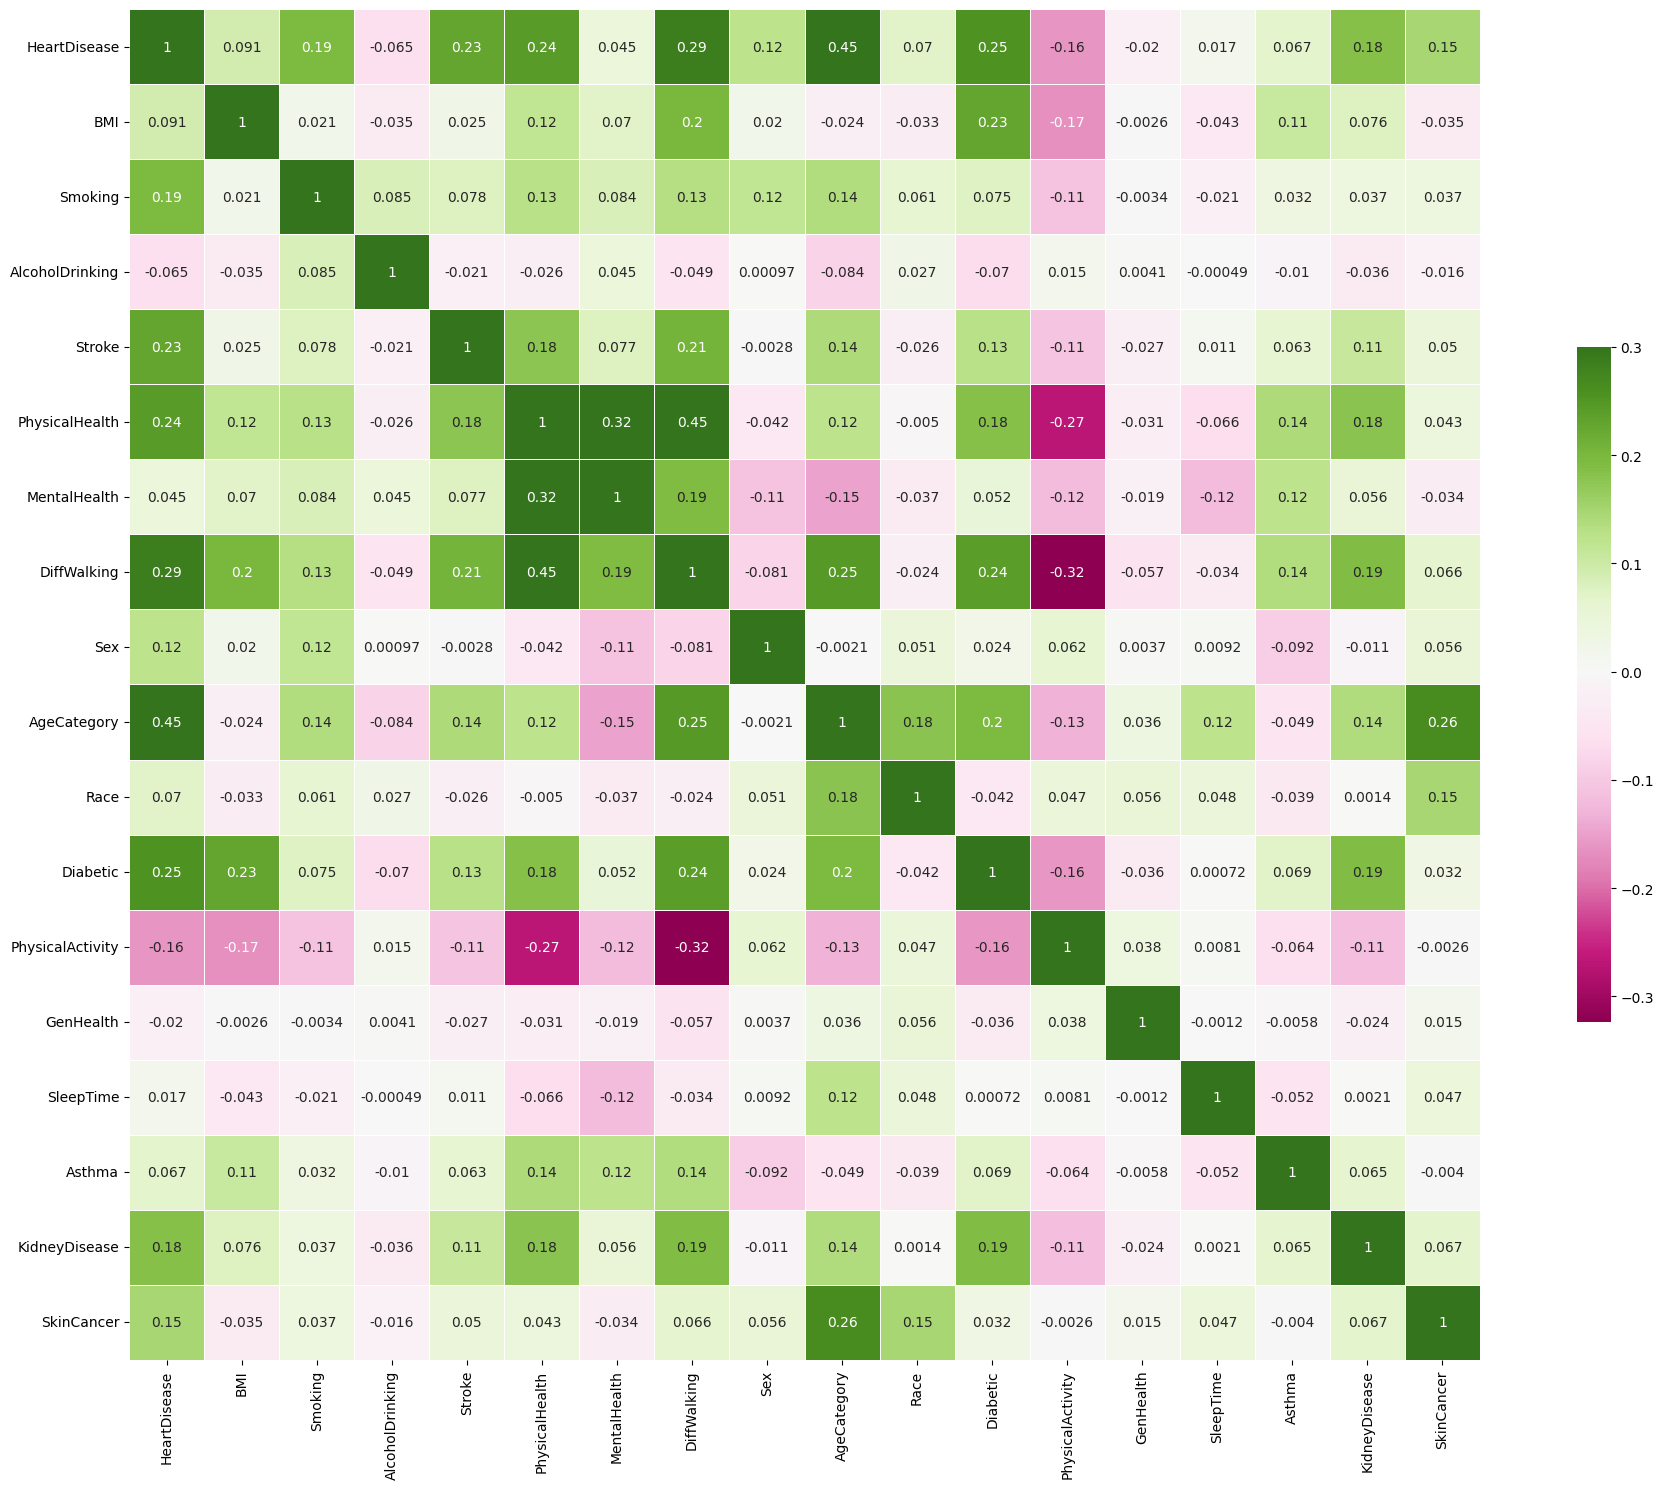

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame
data_encoded = data.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'Race' column
data_encoded['Race'] = label_encoder.fit_transform(data_encoded['Race'])

# Encode 'AgeCategory' column
data_encoded['AgeCategory'] = label_encoder.fit_transform(data_encoded['AgeCategory'])

# Encode 'GenHealth' column
data_encoded['GenHealth'] = label_encoder.fit_transform(data_encoded['GenHealth'])

# Compute the correlation matrix
correlation_matrix = data_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, vmax=0.3, center=0, cmap="PiYG", square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True)
plt.tight_layout()
plt.show()


## Observations:

* physical activity has an inverse relationship with other variables in the data.
* difficulty walking and stroke have a more direct proportional relationship with heart disease.

* The next variables in order of correlation strength are physical health and diabetes, followed by skin cancer.

* Other relationships include mental health having a stronger correlation with difficulty walking than with physical health.
* Smoking having a stronger correlation with physical health and difficulty walking than with diabetes.

* Additionally, alcohol drinking is more strongly correlated with smoking than with asthma, while kidney disease is correlated with physical health, difficulty walking, and diabetes.

The next step involves creating a PIE ( for Featurewise Evaluation with Heart disease) diagram using the correlation heatmap as a basis.

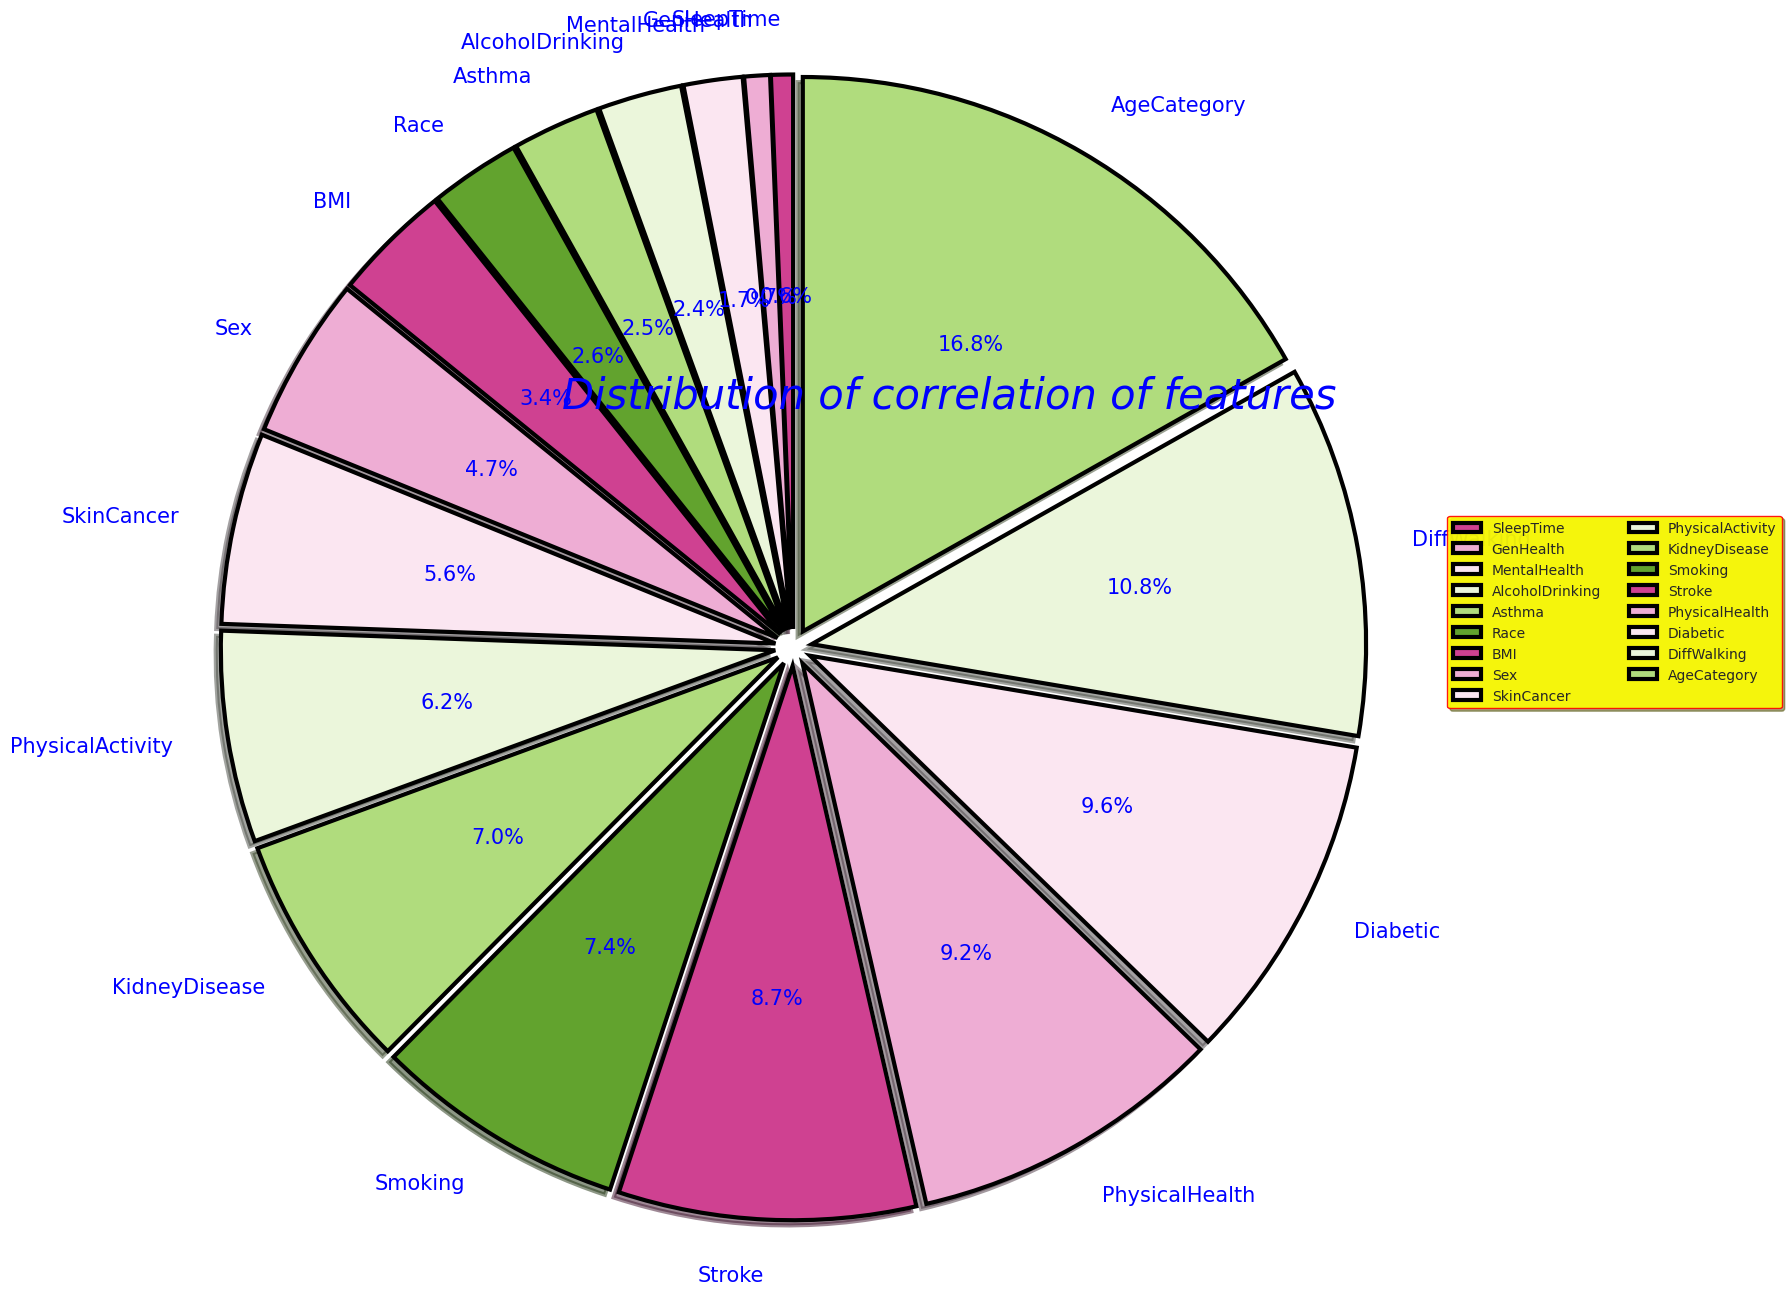

In [ ]:
# Get the Series of correlation values
corr_values = abs(data_encoded.corr()['HeartDisease']).sort_values()[:-1]
sns.set_style('white')
sns.set_palette('PiYG')
plt.figure(figsize = (13,6))
plt.title('Distribution of correlation of features',fontsize=30,color="blue",pad='2.0',
        loc="left",fontstyle='italic')
# Define the explode values based on the length of the Series
explode = [0.1] * len(corr_values) # Example: setting all explode values to 0.1
textprops = {'color':"blue","fontsize":15}
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
# Plot the pie chart with the correct explode values
corr_values.plot.pie(explode=explode, autopct="%2.1f%%", shadow=True, startangle=90, wedgeprops=w, textprops=textprops, radius=3.0)
plt.axis("off")
plt.legend(bbox_to_anchor=(1.9,0.8),ncol=2,facecolor="yellow",framealpha=0.9,shadow=True,edgecolor="red",fancybox=True)
#plt.tight_layout()
plt.show()



<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;textalign:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs Gender".</p>  

In [ ]:
data.Sex.value_counts()

Sex
1    28881
0    25865
Name: count, dtype: int64

In [ ]:
total_genders_count=len(data.Sex)
male_count=len(data[data['Sex']==1])
female_count=len(data[data['Sex']==0])
print('Total Genders :',total_genders_count)
print('Male Count :',male_count)
print('Female Count :',female_count)

Total Genders : 54746
Male Count : 28881
Female Count : 25865


In [ ]:
print("Male State: {:.2f}%".format((male_count / (total_genders_count)*100)))
print("Female State: {:.2f}%".format((female_count / (total_genders_count)*100)))

Male State: 52.75%
Female State: 47.25%


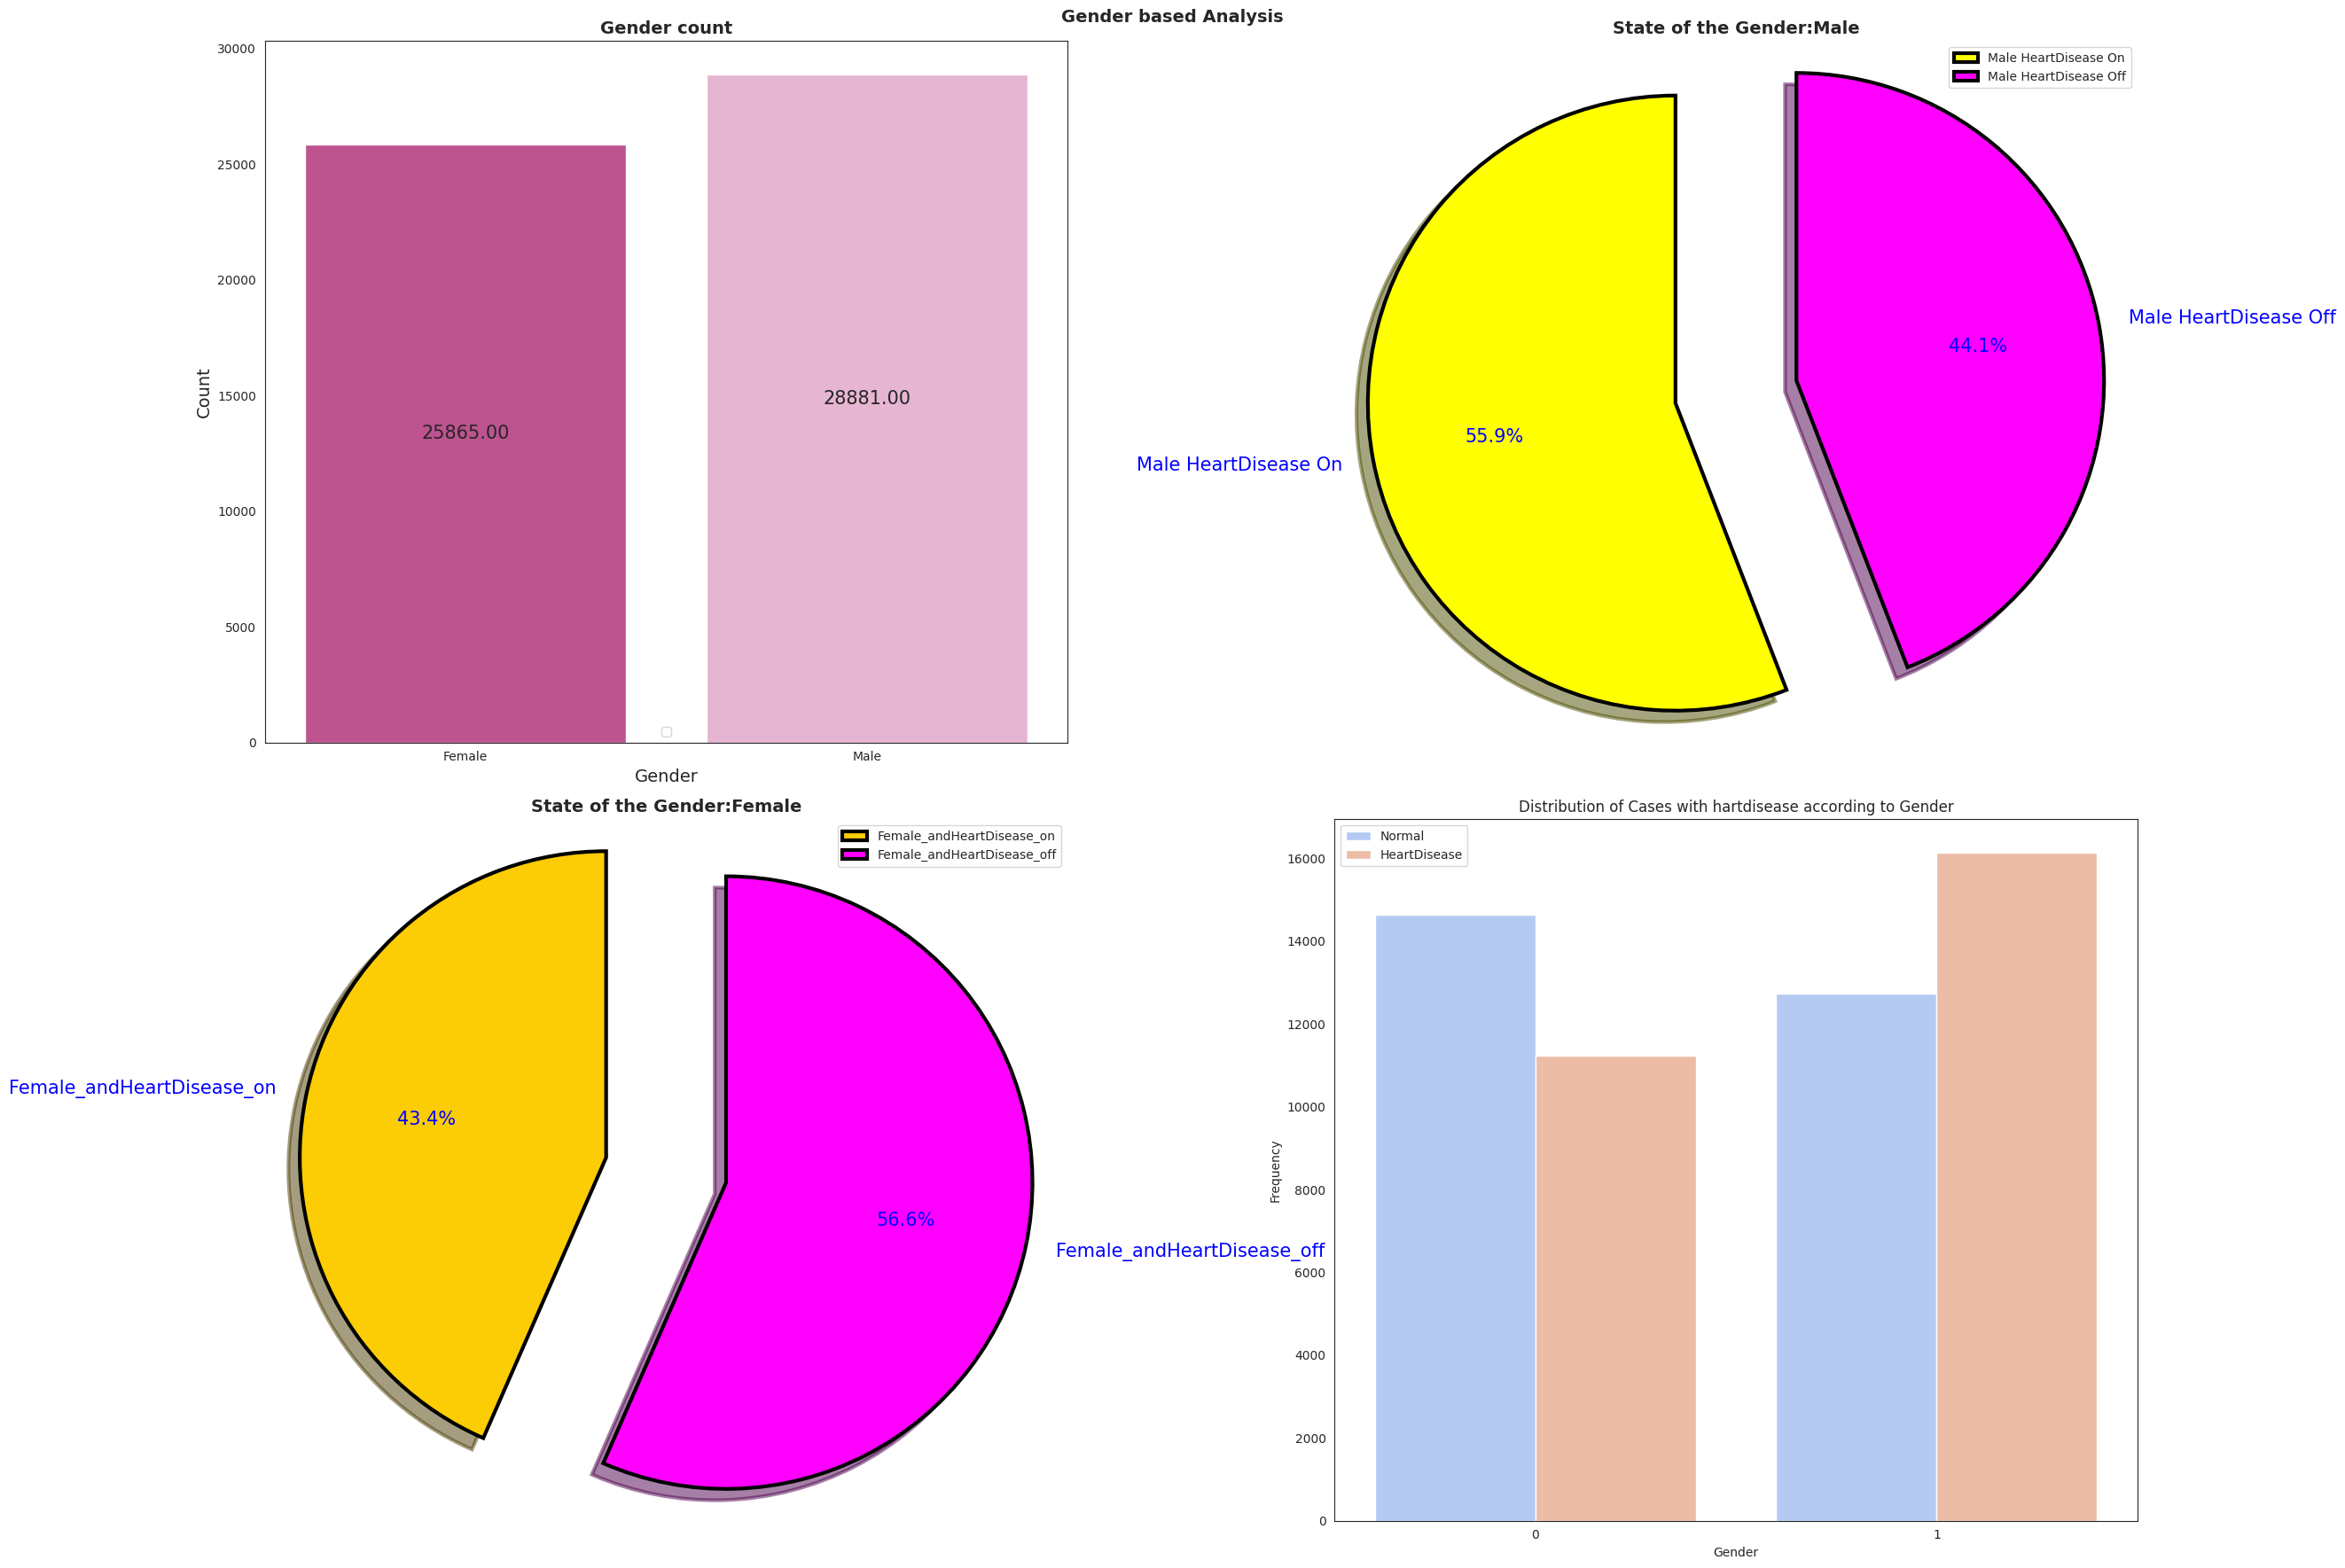

In [ ]:


fig=plt.figure(figsize=(25,18))
plt.suptitle("Gender based Analysis",fontsize=14,fontweight="bold")




plt.subplot(2,2,1)
data1 = {"Gender": ["Female", "Male"],
 "Count": [female_count, male_count]}
df = pd.DataFrame(data1, columns=['Gender', 'Count'])
plots = sns.barplot(x="Gender", y="Count", data=df,hue="Gender",hue_order=["Female","Male"],orient="v")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Gender", size=14)

plt.ylabel("Count", size=14)

plt.title("Gender count",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')




plt.subplot(2,2,2)
male_andHeartDisease_on=len(data[(data.Sex==1)&(data['HeartDisease']==1)])
male_andHeartDisease_off=len(data[(data.Sex==1)&(data['HeartDisease']==0)])
y=['Male HeartDisease On','Male HeartDisease Off']
x=[male_andHeartDisease_on,male_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.1,0.2]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend()
plt.title('State of the Gender:Male',fontsize=14,fontweight="bold")




plt.subplot(2,2,3)
female_andHeartDisease_on=len(data[(data.Sex==0)&(data['HeartDisease']==1)])
female_andHeartDisease_off=len(data[(data.Sex==0)&(data['HeartDisease']==0)])
y=['Female_andHeartDisease_on','Female_andHeartDisease_off']
x=[female_andHeartDisease_on,female_andHeartDisease_off]
c=['#FCCC05',"magenta"]
pct=[0.1,0.2]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend()
plt.title('State of the Gender:Female',fontsize=14,fontweight="bold")




plt.subplot(2,2,4)
sns.countplot(x = data['Sex'], hue = 'HeartDisease', data = data, palette = 'coolwarm')
plt.title("Distribution of Cases with hartdisease according to Gender")
plt.xlabel('Gender')
plt.legend(['Normal','HeartDisease'])
plt.ylabel('Frequency')




plt.tight_layout()
plt.show()

## Observations:
Although both men and women can experience cardiovascular disease (CVD), there are notable distinctions between the two. Men tend to be more susceptible to developing CVD.

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;textalign:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases by Age Category"</p>  

In [ ]:
data.AgeCategory.value_counts()

AgeCategory
70-74          7241
80 or older    7197
65-69          6886
60-64          6135
75-79          5645
55-59          4802
50-54          3626
45-49          2746
40-44          2440
35-39          2236
18-24          2194
30-34          1861
25-29          1737
Name: count, dtype: int64

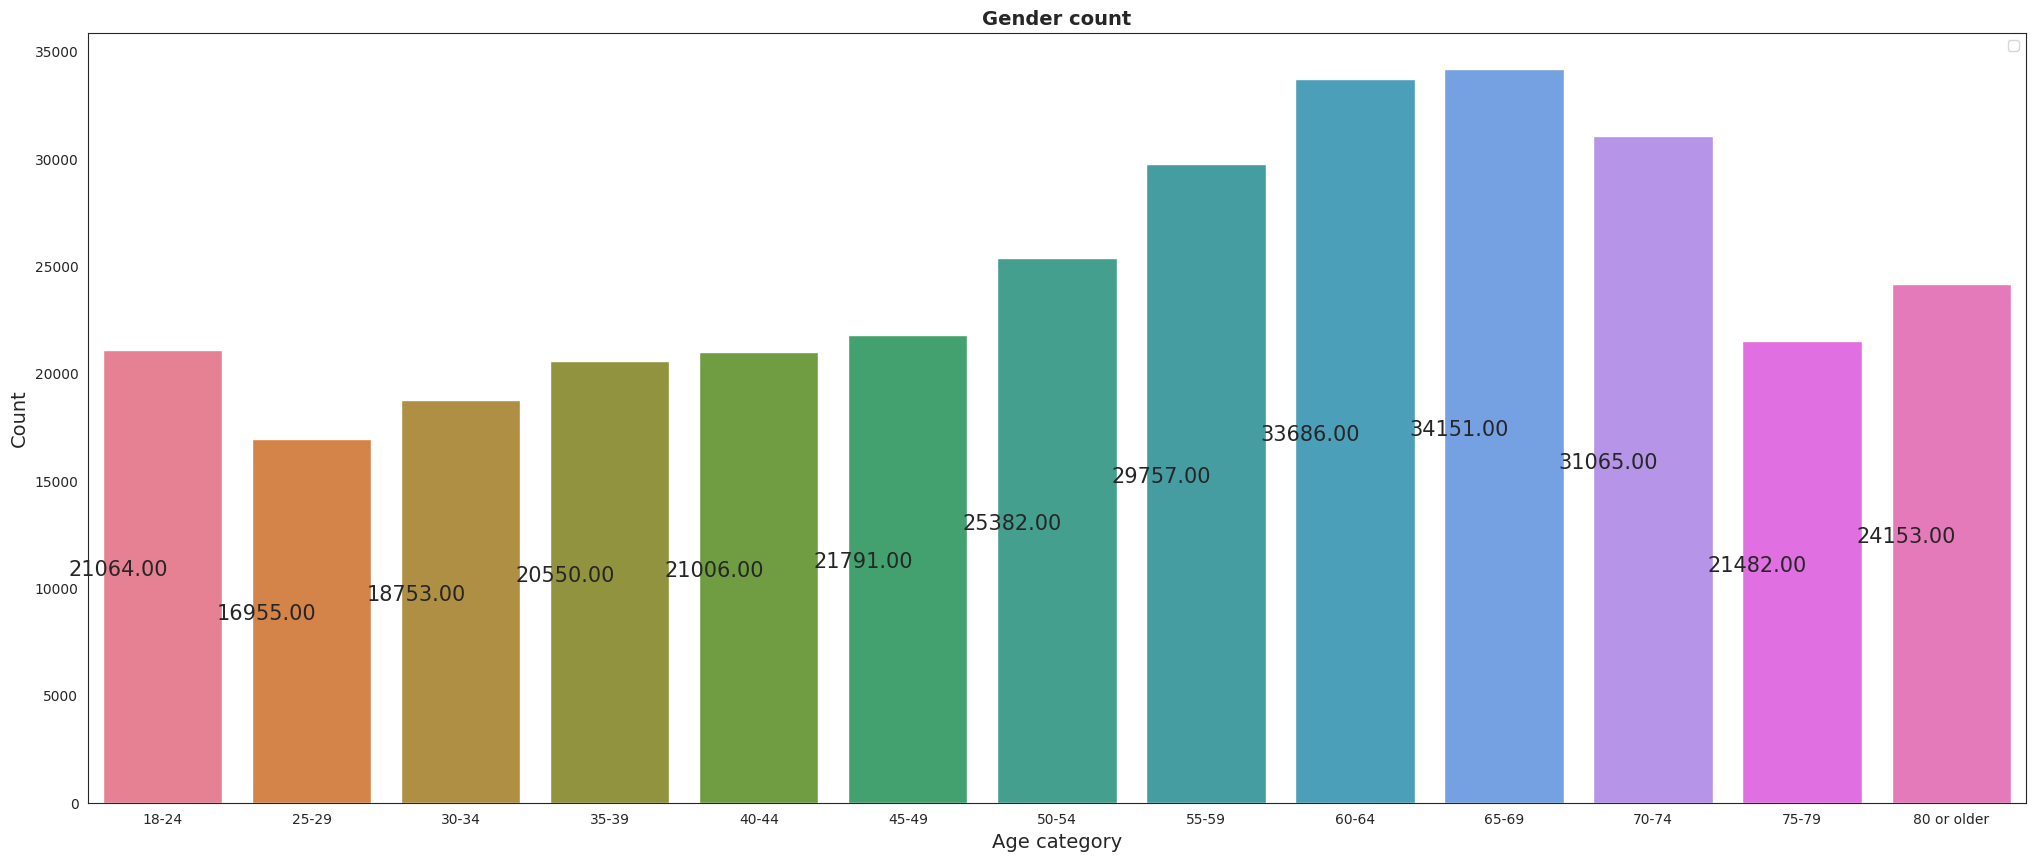

In [ ]:
data1 = {"Age category": ["18-24","25-29", "30-34","35-39","40-44","45-49","50-54","55-59","60-64",
                          "65-69","70-74","75-79","80 or older"],
         "Count": [21064,16955,18753,20550,21006,21791,25382,29757,
                   33686,34151,31065,21482,24153]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 10 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Gender count",fontsize=14,fontweight="bold")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

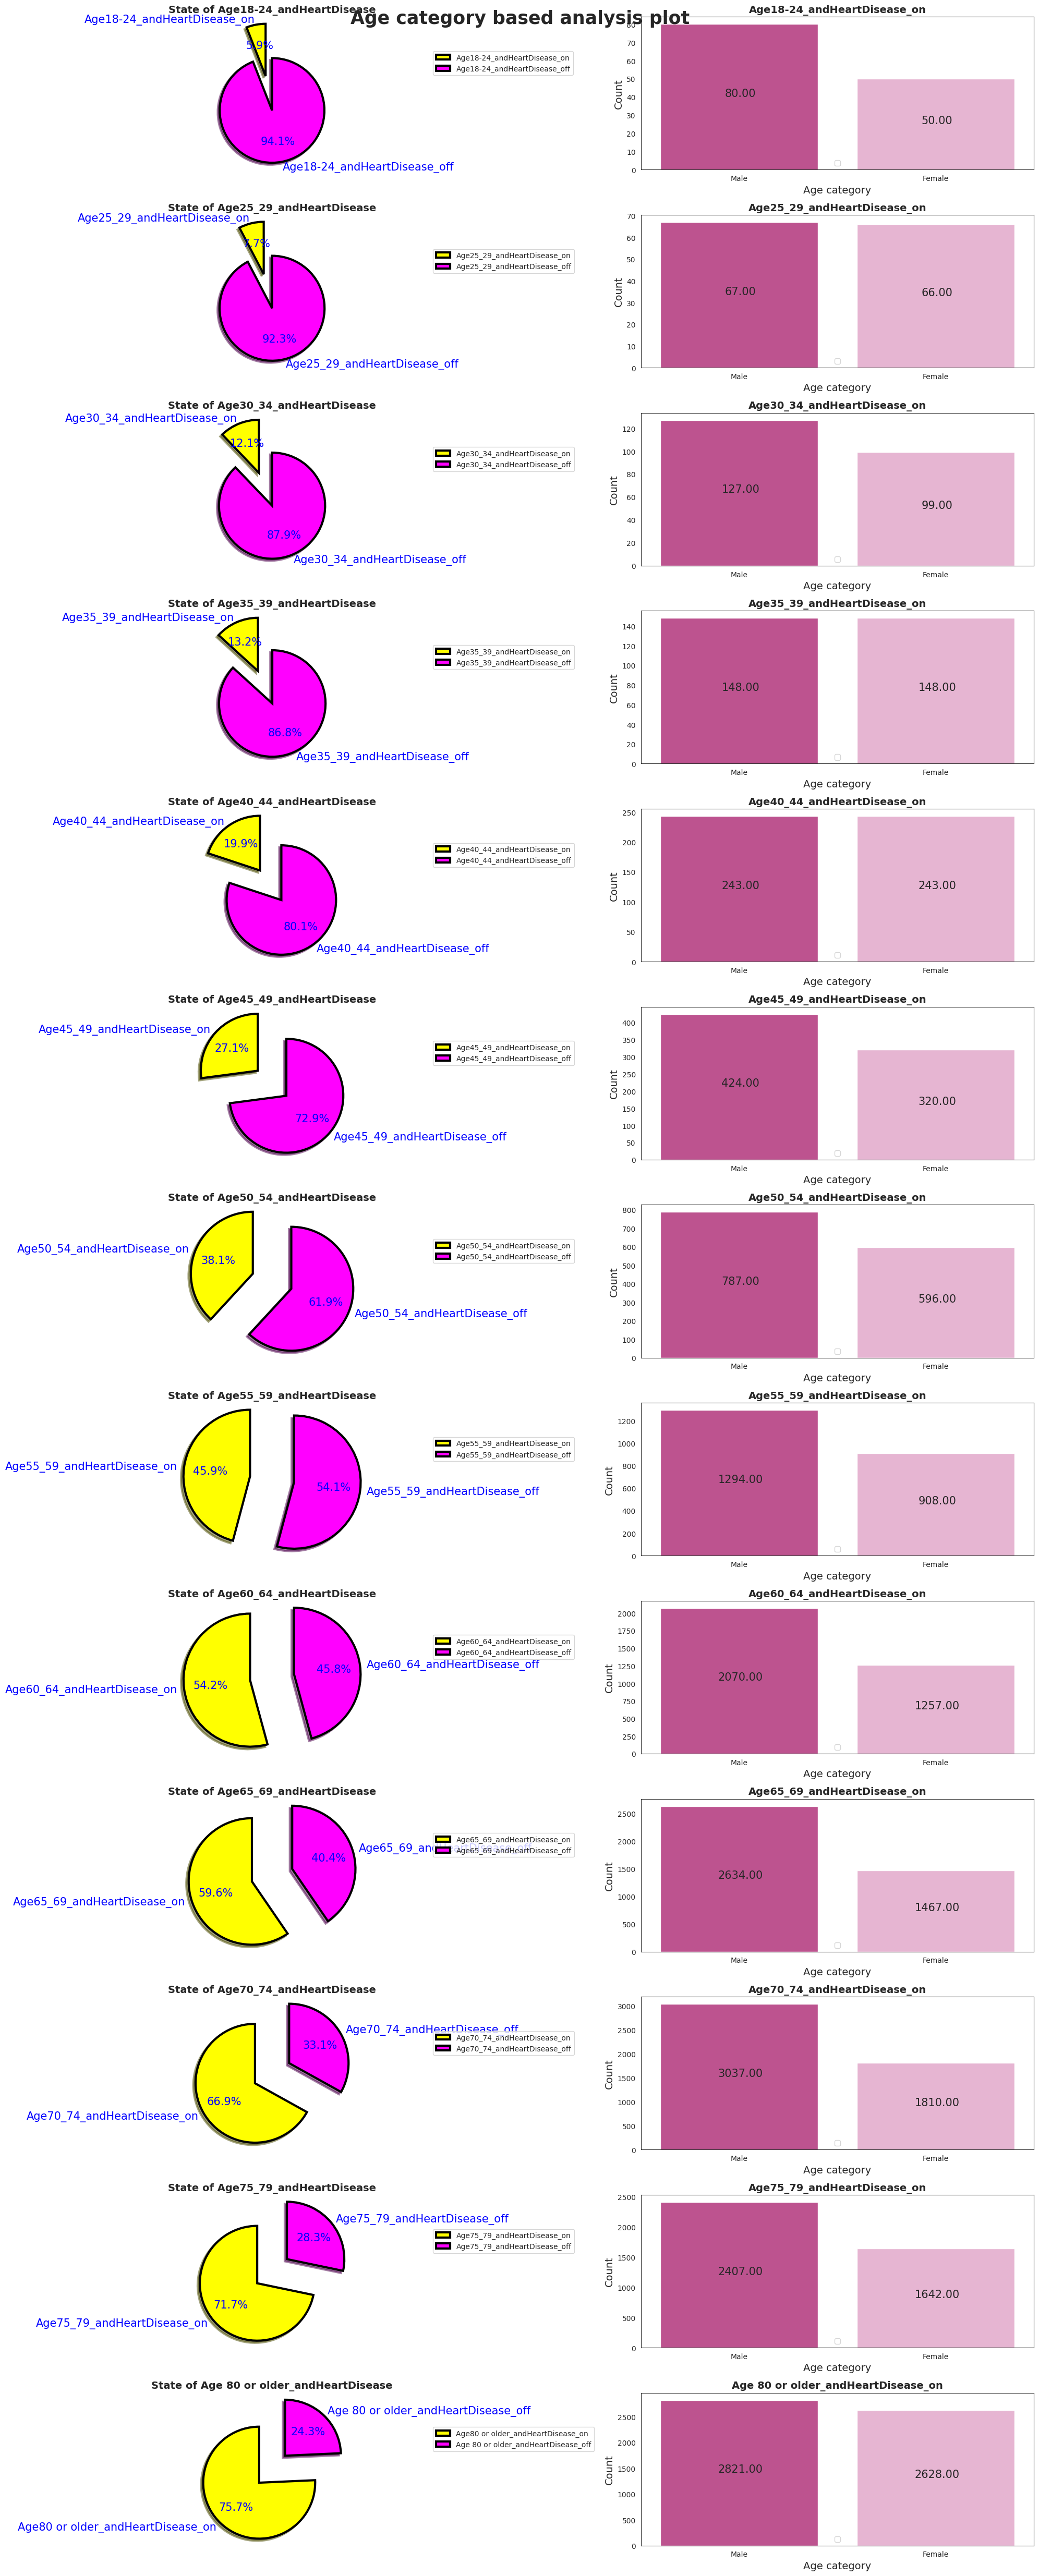

In [ ]:
fig=plt.figure(figsize=(20,50))
plt.suptitle("Age category based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(13,2,3)
Age25_29_andHeartDisease_on=len(data[(data.AgeCategory=='25-29')&(data['HeartDisease']==1)])
Age25_29_andHeartDisease_off=len(data[(data.AgeCategory=='25-29')&(data['HeartDisease']==0)])
y=['Age25_29_andHeartDisease_on','Age25_29_andHeartDisease_off']
x=[Age25_29_andHeartDisease_on,Age25_29_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age25_29_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(13,2,4)
Age25_29_andHeartDisease_onmale=len(data[(data.AgeCategory=='25-29')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age25_29_andHeartDisease_onfemale=len(data[(data.AgeCategory=='25-29')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age25_29_andHeartDisease_onmale,Age25_29_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age25_29_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(13,2,1)
Age18_24_andHeartDisease_on=len(data[(data.AgeCategory=='18-24')&(data['HeartDisease']==1)])
Age18_24_andHeartDisease_off=len(data[(data.AgeCategory=='18-24')&(data['HeartDisease']==0)])
y=['Age18-24_andHeartDisease_on','Age18-24_andHeartDisease_off']
x=[Age18_24_andHeartDisease_on,Age18_24_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age18-24_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(13,2,2)
Age18_24_andHeartDisease_onmale=len(data[(data.AgeCategory=='18-24')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age18_24_andHeartDisease_onfemale=len(data[(data.AgeCategory=='18-24')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age18_24_andHeartDisease_onmale,Age18_24_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age18-24_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(13,2,5)
Age30_34_andHeartDisease_on=len(data[(data.AgeCategory=='30-34')&(data['HeartDisease']==1)])
Age30_34_andHeartDisease_off=len(data[(data.AgeCategory=='30-34')&(data['HeartDisease']==0)])
y=['Age30_34_andHeartDisease_on','Age30_34_andHeartDisease_off']
x=[Age30_34_andHeartDisease_on,Age30_34_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age30_34_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(13,2,6)
Age30_34_andHeartDisease_onmale=len(data[(data.AgeCategory=='30-34')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age30_34_andHeartDisease_onfemale=len(data[(data.AgeCategory=='30-34')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age30_34_andHeartDisease_onmale,Age30_34_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age30_34_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(13,2,7)
Age35_39_andHeartDisease_on=len(data[(data.AgeCategory=='35-39')&(data['HeartDisease']==1)])
Age35_39_andHeartDisease_off=len(data[(data.AgeCategory=='35-39')&(data['HeartDisease']==0)])
y=['Age35_39_andHeartDisease_on','Age35_39_andHeartDisease_off']
x=[Age35_39_andHeartDisease_on,Age35_39_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age35_39_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,8)
Age35_39_andHeartDisease_onmale=len(data[(data.AgeCategory=='35-39')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age35_39_andHeartDisease_onfemale=len(data[(data.AgeCategory=='35-39')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age35_39_andHeartDisease_onmale,Age35_39_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age35_39_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(13,2,9)
Age40_44_andHeartDisease_on=len(data[(data.AgeCategory=='40-44')&(data['HeartDisease']==1)])
Age40_44_andHeartDisease_off=len(data[(data.AgeCategory=='40-44')&(data['HeartDisease']==0)])
y=['Age40_44_andHeartDisease_on','Age40_44_andHeartDisease_off']
x=[Age40_44_andHeartDisease_on,Age40_44_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age40_44_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,10)
Age40_44_andHeartDisease_onmale=len(data[(data.AgeCategory=='40-44')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age40_44_andHeartDisease_onfemale=len(data[(data.AgeCategory=='40-44')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age40_44_andHeartDisease_onmale,Age40_44_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age40_44_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(13,2,11)
Age45_49_andHeartDisease_on=len(data[(data.AgeCategory=='45-49')&(data['HeartDisease']==1)])
Age45_49_andHeartDisease_off=len(data[(data.AgeCategory=='45-49')&(data['HeartDisease']==0)])
y=['Age45_49_andHeartDisease_on','Age45_49_andHeartDisease_off']
x=[Age45_49_andHeartDisease_on,Age45_49_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age45_49_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(13,2,12)
Age45_49_andHeartDisease_onmale=len(data[(data.AgeCategory=='45-49')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age45_49_andHeartDisease_onfemale=len(data[(data.AgeCategory=='45-49')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age45_49_andHeartDisease_onmale,Age45_49_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age45_49_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')



plt.subplot(13,2,13)
Age50_54_andHeartDisease_on=len(data[(data.AgeCategory=='50-54')&(data['HeartDisease']==1)])
Age50_54_andHeartDisease_off=len(data[(data.AgeCategory=='50-54')&(data['HeartDisease']==0)])
y=['Age50_54_andHeartDisease_on','Age50_54_andHeartDisease_off']
x=[Age50_54_andHeartDisease_on,Age50_54_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age50_54_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,14)
Age50_54_andHeartDisease_onmale=len(data[(data.AgeCategory=='50-54')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age50_54_andHeartDisease_onfemale=len(data[(data.AgeCategory=='50-54')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age50_54_andHeartDisease_onmale,Age50_54_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age50_54_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(13,2,15)
Age55_59_andHeartDisease_on=len(data[(data.AgeCategory=='55-59')&(data['HeartDisease']==1)])
Age55_59_andHeartDisease_off=len(data[(data.AgeCategory=='55-59')&(data['HeartDisease']==0)])
y=['Age55_59_andHeartDisease_on','Age55_59_andHeartDisease_off']
x=[Age55_59_andHeartDisease_on,Age55_59_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age55_59_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,16)
Age55_59_andHeartDisease_onmale=len(data[(data.AgeCategory=='55-59')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age55_59_andHeartDisease_onfemale=len(data[(data.AgeCategory=='55-59')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age55_59_andHeartDisease_onmale,Age55_59_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age55_59_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(13,2,17)
Age60_64_andHeartDisease_on=len(data[(data.AgeCategory=='60-64')&(data['HeartDisease']==1)])
Age60_64_andHeartDisease_off=len(data[(data.AgeCategory=='60-64')&(data['HeartDisease']==0)])
y=['Age60_64_andHeartDisease_on','Age60_64_andHeartDisease_off']
x=[Age60_64_andHeartDisease_on,Age60_64_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age60_64_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,18)
Age60_64_andHeartDisease_onmale=len(data[(data.AgeCategory=='60-64')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age60_64_andHeartDisease_onfemale=len(data[(data.AgeCategory=='60-64')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age60_64_andHeartDisease_onmale,Age60_64_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age60_64_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(13,2,19)
Age65_69_andHeartDisease_on=len(data[(data.AgeCategory=='65-69')&(data['HeartDisease']==1)])
Age65_69_andHeartDisease_off=len(data[(data.AgeCategory=='65-69')&(data['HeartDisease']==0)])
y=['Age65_69_andHeartDisease_on','Age65_69_andHeartDisease_off']
x=[Age65_69_andHeartDisease_on,Age65_69_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age65_69_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,20)
Age65_69_andHeartDisease_onmale=len(data[(data.AgeCategory=='65-69')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age65_69_andHeartDisease_onfemale=len(data[(data.AgeCategory=='65-69')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age65_69_andHeartDisease_onmale,Age65_69_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age65_69_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(13,2,21)
Age70_74_andHeartDisease_on=len(data[(data.AgeCategory=='70-74')&(data['HeartDisease']==1)])
Age70_74_andHeartDisease_off=len(data[(data.AgeCategory=='70-74')&(data['HeartDisease']==0)])
y=['Age70_74_andHeartDisease_on','Age70_74_andHeartDisease_off']
x=[Age70_74_andHeartDisease_on,Age70_74_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age70_74_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,22)
Age70_74_andHeartDisease_onmale=len(data[(data.AgeCategory=='70-74')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age70_74_andHeartDisease_onfemale=len(data[(data.AgeCategory=='70-74')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age70_74_andHeartDisease_onmale,Age70_74_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age70_74_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(13,2,23)
Age75_79_andHeartDisease_on=len(data[(data.AgeCategory=='75-79')&(data['HeartDisease']==1)])
Age75_79_andHeartDisease_off=len(data[(data.AgeCategory=='75-79')&(data['HeartDisease']==0)])
y=['Age75_79_andHeartDisease_on','Age75_79_andHeartDisease_off']
x=[Age75_79_andHeartDisease_on,Age75_79_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age75_79_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,24)
Age75_79_andHeartDisease_onmale=len(data[(data.AgeCategory=='75-79')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age75_79_andHeartDisease_onfemale=len(data[(data.AgeCategory=='75-79')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age75_79_andHeartDisease_onmale,Age75_79_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age75_79_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(13,2,25)
Age80_older_andHeartDisease_on=len(data[(data.AgeCategory=='80 or older')&(data['HeartDisease']==1)])
Age80_older_andHeartDisease_off=len(data[(data.AgeCategory=='80 or older')&(data['HeartDisease']==0)])
y=['Age80 or older_andHeartDisease_on','Age 80 or older_andHeartDisease_off']
x=[Age80_older_andHeartDisease_on,Age80_older_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Age 80 or older_andHeartDisease',fontsize=14,fontweight="bold")

plt.subplot(13,2,26)
Age80_older_andHeartDisease_onmale=len(data[(data.AgeCategory=='80 or older')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

Age80_older_andHeartDisease_onfemale=len(data[(data.AgeCategory=='80 or older')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Age category": ["Male","Female"],
         "Count": [Age80_older_andHeartDisease_onmale,Age80_older_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Age category', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Age category", y="Count", data=df,hue="Age category")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Age category", size=14)

plt.ylabel("Count", size=14)

plt.title("Age 80 or older_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

#fig.legend(bbox_to_anchor=(0.9,1.3))
plt.tight_layout()
plt.show()


## Observations:
* The elderly and aging population are more prone to developing cardiovascular disease. Age is a significant risk factor for CVD in adults.

* Furthermore, gender is another potential risk factor in aging individuals, as  men are reported to have a higher risk of CVD as that of women of the same age.  

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs Race"</p>

In [ ]:
data.Race.value_counts()

Race
White                             43198
Hispanic                           3994
Black                              3719
Other                              1844
Asian                               999
American Indian/Alaskan Native      992
Name: count, dtype: int64

In [ ]:
d=list(dict(data.Race.value_counts()).values())
d

[43198, 3994, 3719, 1844, 999, 992]

<ipython-input-46-4cf41d0ff43b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plots.set_xticklabels(plots.get_xticklabels(), fontsize=14)


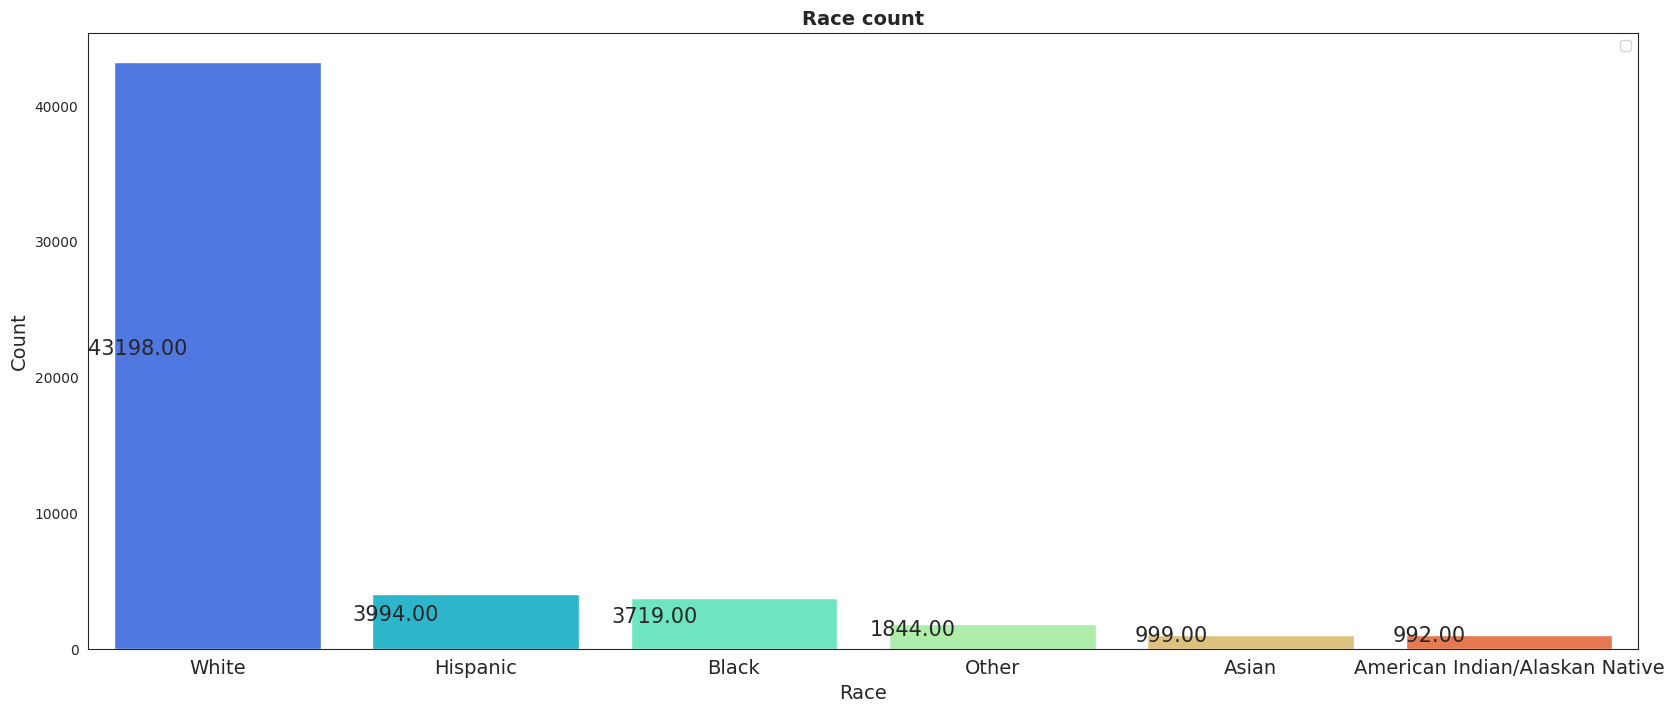

In [ ]:
fig=plt.figure(figsize=(20,8))
data1 = {"Race": list(dict(data.Race.value_counts()).keys()),
         "Count": list(dict(data.Race.value_counts()).values())}
df = pd.DataFrame(data1, columns=['Race', 'Count'])
#fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="Race", y="Count", data=df,hue="Race",n_boot=10,errorbar=('ci', 10),orient="v",
                    palette='rainbow')
plots.set_xticklabels(plots.get_xticklabels(), fontsize=14)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 10 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Race", size=14)

plt.ylabel("Count", size=14)

plt.title("Race count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

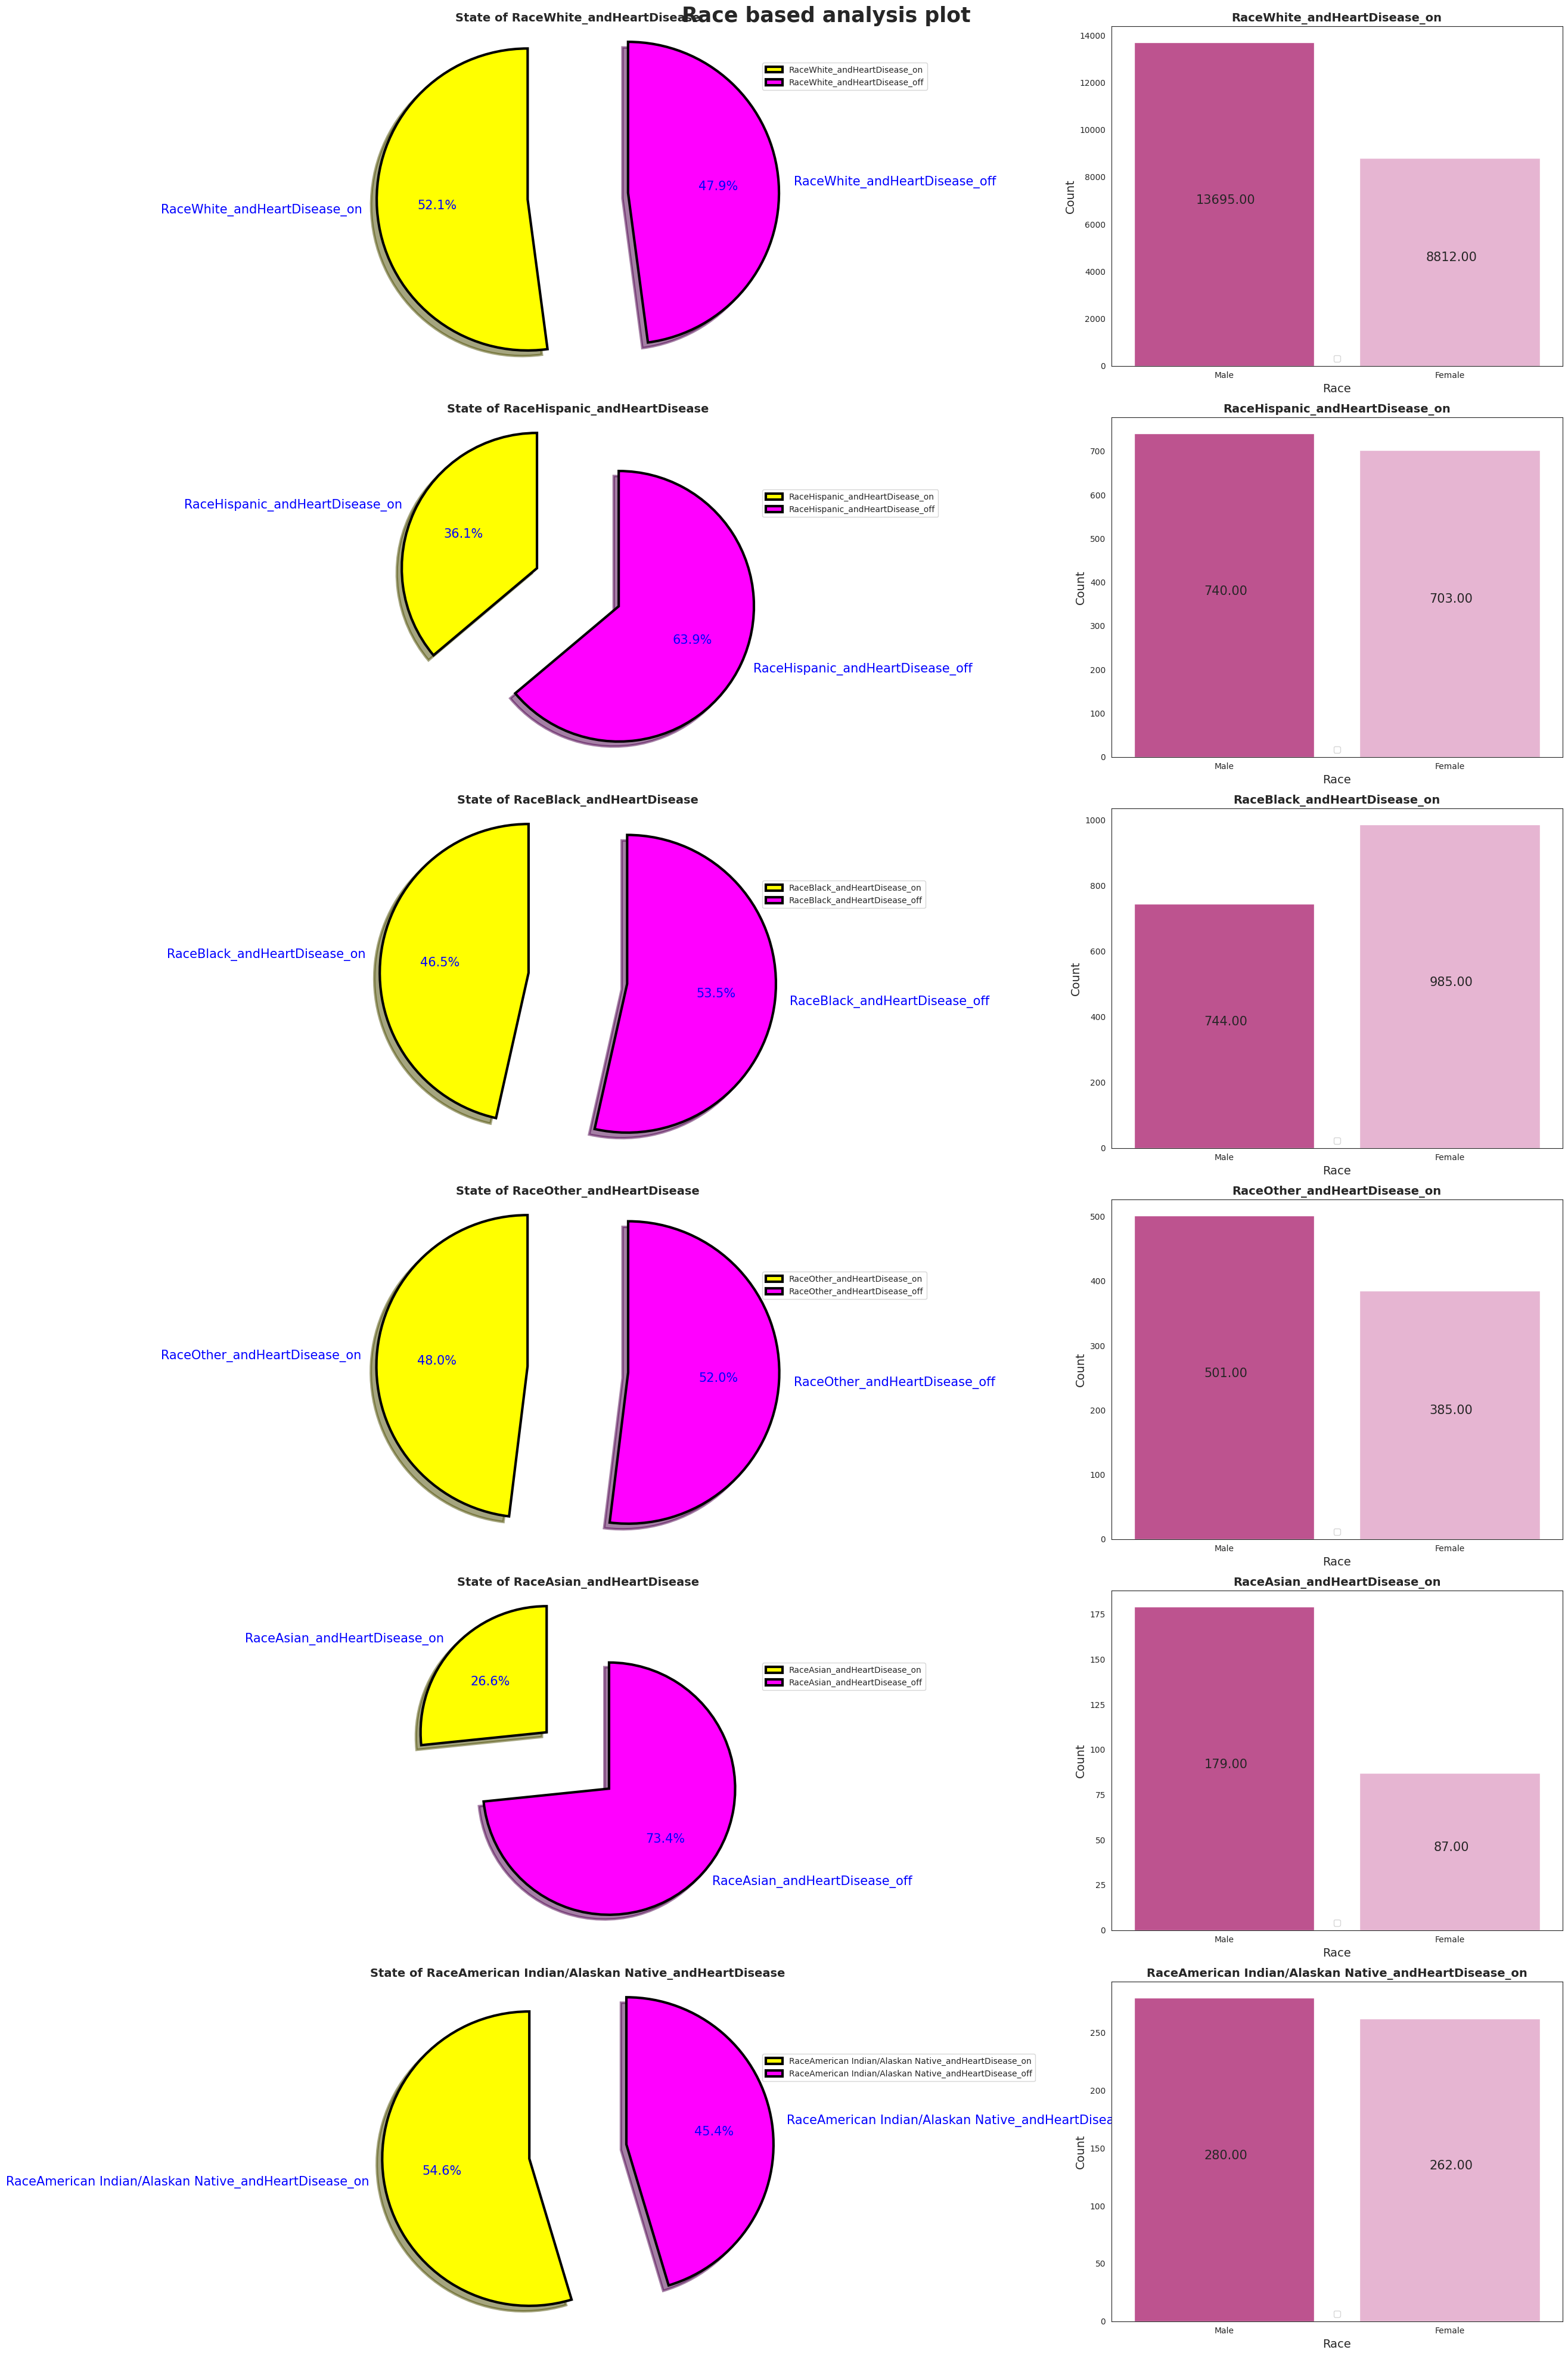

In [ ]:
fig=plt.figure(figsize=(25,40))
plt.suptitle("Race based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(6,2,1)
RaceWhite_andHeartDisease_on=len(data[(data.Race=='White')&(data['HeartDisease']==1)])
RaceWhite_andHeartDisease_off=len(data[(data.Race=='White')&(data['HeartDisease']==0)])
y=['RaceWhite_andHeartDisease_on','RaceWhite_andHeartDisease_off']
x=[RaceWhite_andHeartDisease_on,RaceWhite_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of RaceWhite_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(6,2,2)
RaceWhite_andHeartDisease_onmale=len(data[(data.Race=='White')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

RaceWhite_andHeartDisease_onfemale=len(data[(data.Race=='White')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Race": ["Male","Female"],
         "Count": [RaceWhite_andHeartDisease_onmale,RaceWhite_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Race', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Race",y="Count", data=df,hue="Race")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Race", size=14)

plt.ylabel("Count", size=14)

plt.title("RaceWhite_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(6,2,3)
RaceHispanic_andHeartDisease_on=len(data[(data.Race=='Hispanic')&(data['HeartDisease']==1)])
RaceHispanic_andHeartDisease_off=len(data[(data.Race=='Hispanic')&(data['HeartDisease']==0)])
y=['RaceHispanic_andHeartDisease_on','RaceHispanic_andHeartDisease_off']
x=[RaceHispanic_andHeartDisease_on,RaceHispanic_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of RaceHispanic_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(6,2,4)
RaceHispanic_andHeartDisease_onmale=len(data[(data.Race=='Hispanic')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

RaceHispanic_andHeartDisease_onfemale=len(data[(data.Race=='Hispanic')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Race": ["Male","Female"],
         "Count": [RaceHispanic_andHeartDisease_onmale,RaceHispanic_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Race', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Race",y="Count", data=df,hue="Race")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Race", size=14)

plt.ylabel("Count", size=14)

plt.title("RaceHispanic_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(6,2,5)
RaceBlack_andHeartDisease_on=len(data[(data.Race=='Black')&(data['HeartDisease']==1)])
RaceBlack_andHeartDisease_off=len(data[(data.Race=='Black')&(data['HeartDisease']==0)])
y=['RaceBlack_andHeartDisease_on','RaceBlack_andHeartDisease_off']
x=[RaceBlack_andHeartDisease_on,RaceBlack_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of RaceBlack_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(6,2,6)
RaceBlack_andHeartDisease_onmale=len(data[(data.Race=='Black')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

RaceBlack_andHeartDisease_onfemale=len(data[(data.Race=='Black')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Race": ["Male","Female"],
         "Count": [RaceBlack_andHeartDisease_onmale,RaceBlack_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Race', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Race",y="Count", data=df,hue="Race")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Race", size=14)

plt.ylabel("Count", size=14)

plt.title("RaceBlack_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(6,2,7)
RaceOther_andHeartDisease_on=len(data[(data.Race=='Other')&(data['HeartDisease']==1)])
RaceOther_andHeartDisease_off=len(data[(data.Race=='Other')&(data['HeartDisease']==0)])
y=['RaceOther_andHeartDisease_on','RaceOther_andHeartDisease_off']
x=[RaceOther_andHeartDisease_on,RaceOther_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of RaceOther_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(6,2,8)
RaceOther_andHeartDisease_onmale=len(data[(data.Race=='Other')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

RaceOther_andHeartDisease_onfemale=len(data[(data.Race=='Other')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Race": ["Male","Female"],
         "Count": [RaceOther_andHeartDisease_onmale,RaceOther_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Race', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Race",y="Count", data=df,hue="Race")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Race", size=14)

plt.ylabel("Count", size=14)

plt.title("RaceOther_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(6,2,9)
RaceAsian_andHeartDisease_on=len(data[(data.Race=='Asian')&(data['HeartDisease']==1)])
RaceAsian_andHeartDisease_off=len(data[(data.Race=='Asian')&(data['HeartDisease']==0)])
y=['RaceAsian_andHeartDisease_on','RaceAsian_andHeartDisease_off']
x=[RaceAsian_andHeartDisease_on,RaceAsian_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of RaceAsian_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(6,2,10)
RaceAsian_andHeartDisease_onmale=len(data[(data.Race=='Asian')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

RaceAsian_andHeartDisease_onfemale=len(data[(data.Race=='Asian')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Race": ["Male","Female"],
         "Count": [RaceAsian_andHeartDisease_onmale,RaceAsian_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Race', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Race",y="Count", data=df,hue="Race")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Race", size=14)

plt.ylabel("Count", size=14)

plt.title("RaceAsian_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(6,2,11)
RaceAmerican_Indian_Alaskan_Native_andHeartDisease_on=len(data[(data.Race=='American Indian/Alaskan Native')&(data['HeartDisease']==1)])
RaceAmerican_Indian_Alaskan_Native_andHeartDisease_off=len(data[(data.Race=='American Indian/Alaskan Native')&(data['HeartDisease']==0)])
y=['RaceAmerican Indian/Alaskan Native_andHeartDisease_on','RaceAmerican Indian/Alaskan Native_andHeartDisease_off']
x=[RaceAmerican_Indian_Alaskan_Native_andHeartDisease_on,RaceAmerican_Indian_Alaskan_Native_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of RaceAmerican Indian/Alaskan Native_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(6,2,12)
RaceAmerican_Indian_Alaskan_Native_andHeartDisease_onmale=len(data[(data.Race=='American Indian/Alaskan Native')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

RaceAmerican_Indian_Alaskan_Native_andHeartDisease_onfemale=len(data[(data.Race=='American Indian/Alaskan Native')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"Race": ["Male","Female"],
         "Count": [RaceAmerican_Indian_Alaskan_Native_andHeartDisease_onmale,RaceAmerican_Indian_Alaskan_Native_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['Race', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Race",y="Count", data=df,hue="Race")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Race", size=14)

plt.ylabel("Count", size=14)

plt.title("RaceAmerican Indian/Alaskan Native_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')





plt.tight_layout()
plt.show()

## Observations:

Among the different races, American Indian/Alaskan Natives have the highest risk of heart disease (10.4%), and among them, men are more likely to experience heart disease. However, when it comes to the Black race, women have a higher risk of heart disease compared to men.



<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs General Health"</p>

In [ ]:
data.GenHealth.value_counts()

GenHealth
Good         17358
Very good    15505
Fair          9638
Excellent     7687
Poor          4558
Name: count, dtype: int64

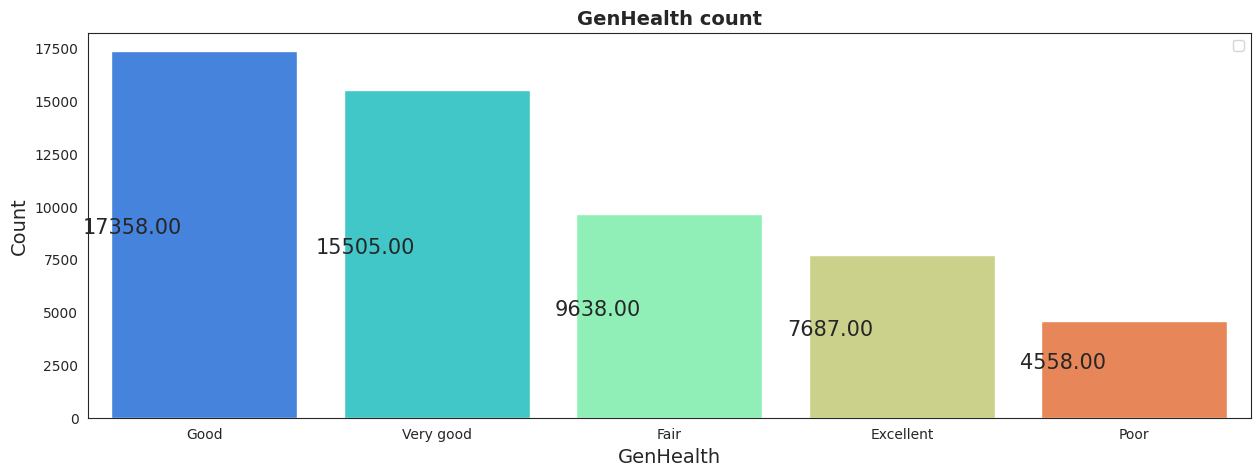

In [ ]:
data1 = {"GenHealth": list(dict(data.GenHealth.value_counts()).keys()),
         "Count": list(dict(data.GenHealth.value_counts()).values())}
df = pd.DataFrame(data1, columns=['GenHealth', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="GenHealth", y="Count", data=df,hue="GenHealth",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='rainbow')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 10 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("GenHealth", size=14)

plt.ylabel("Count", size=14)

plt.title("GenHealth count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

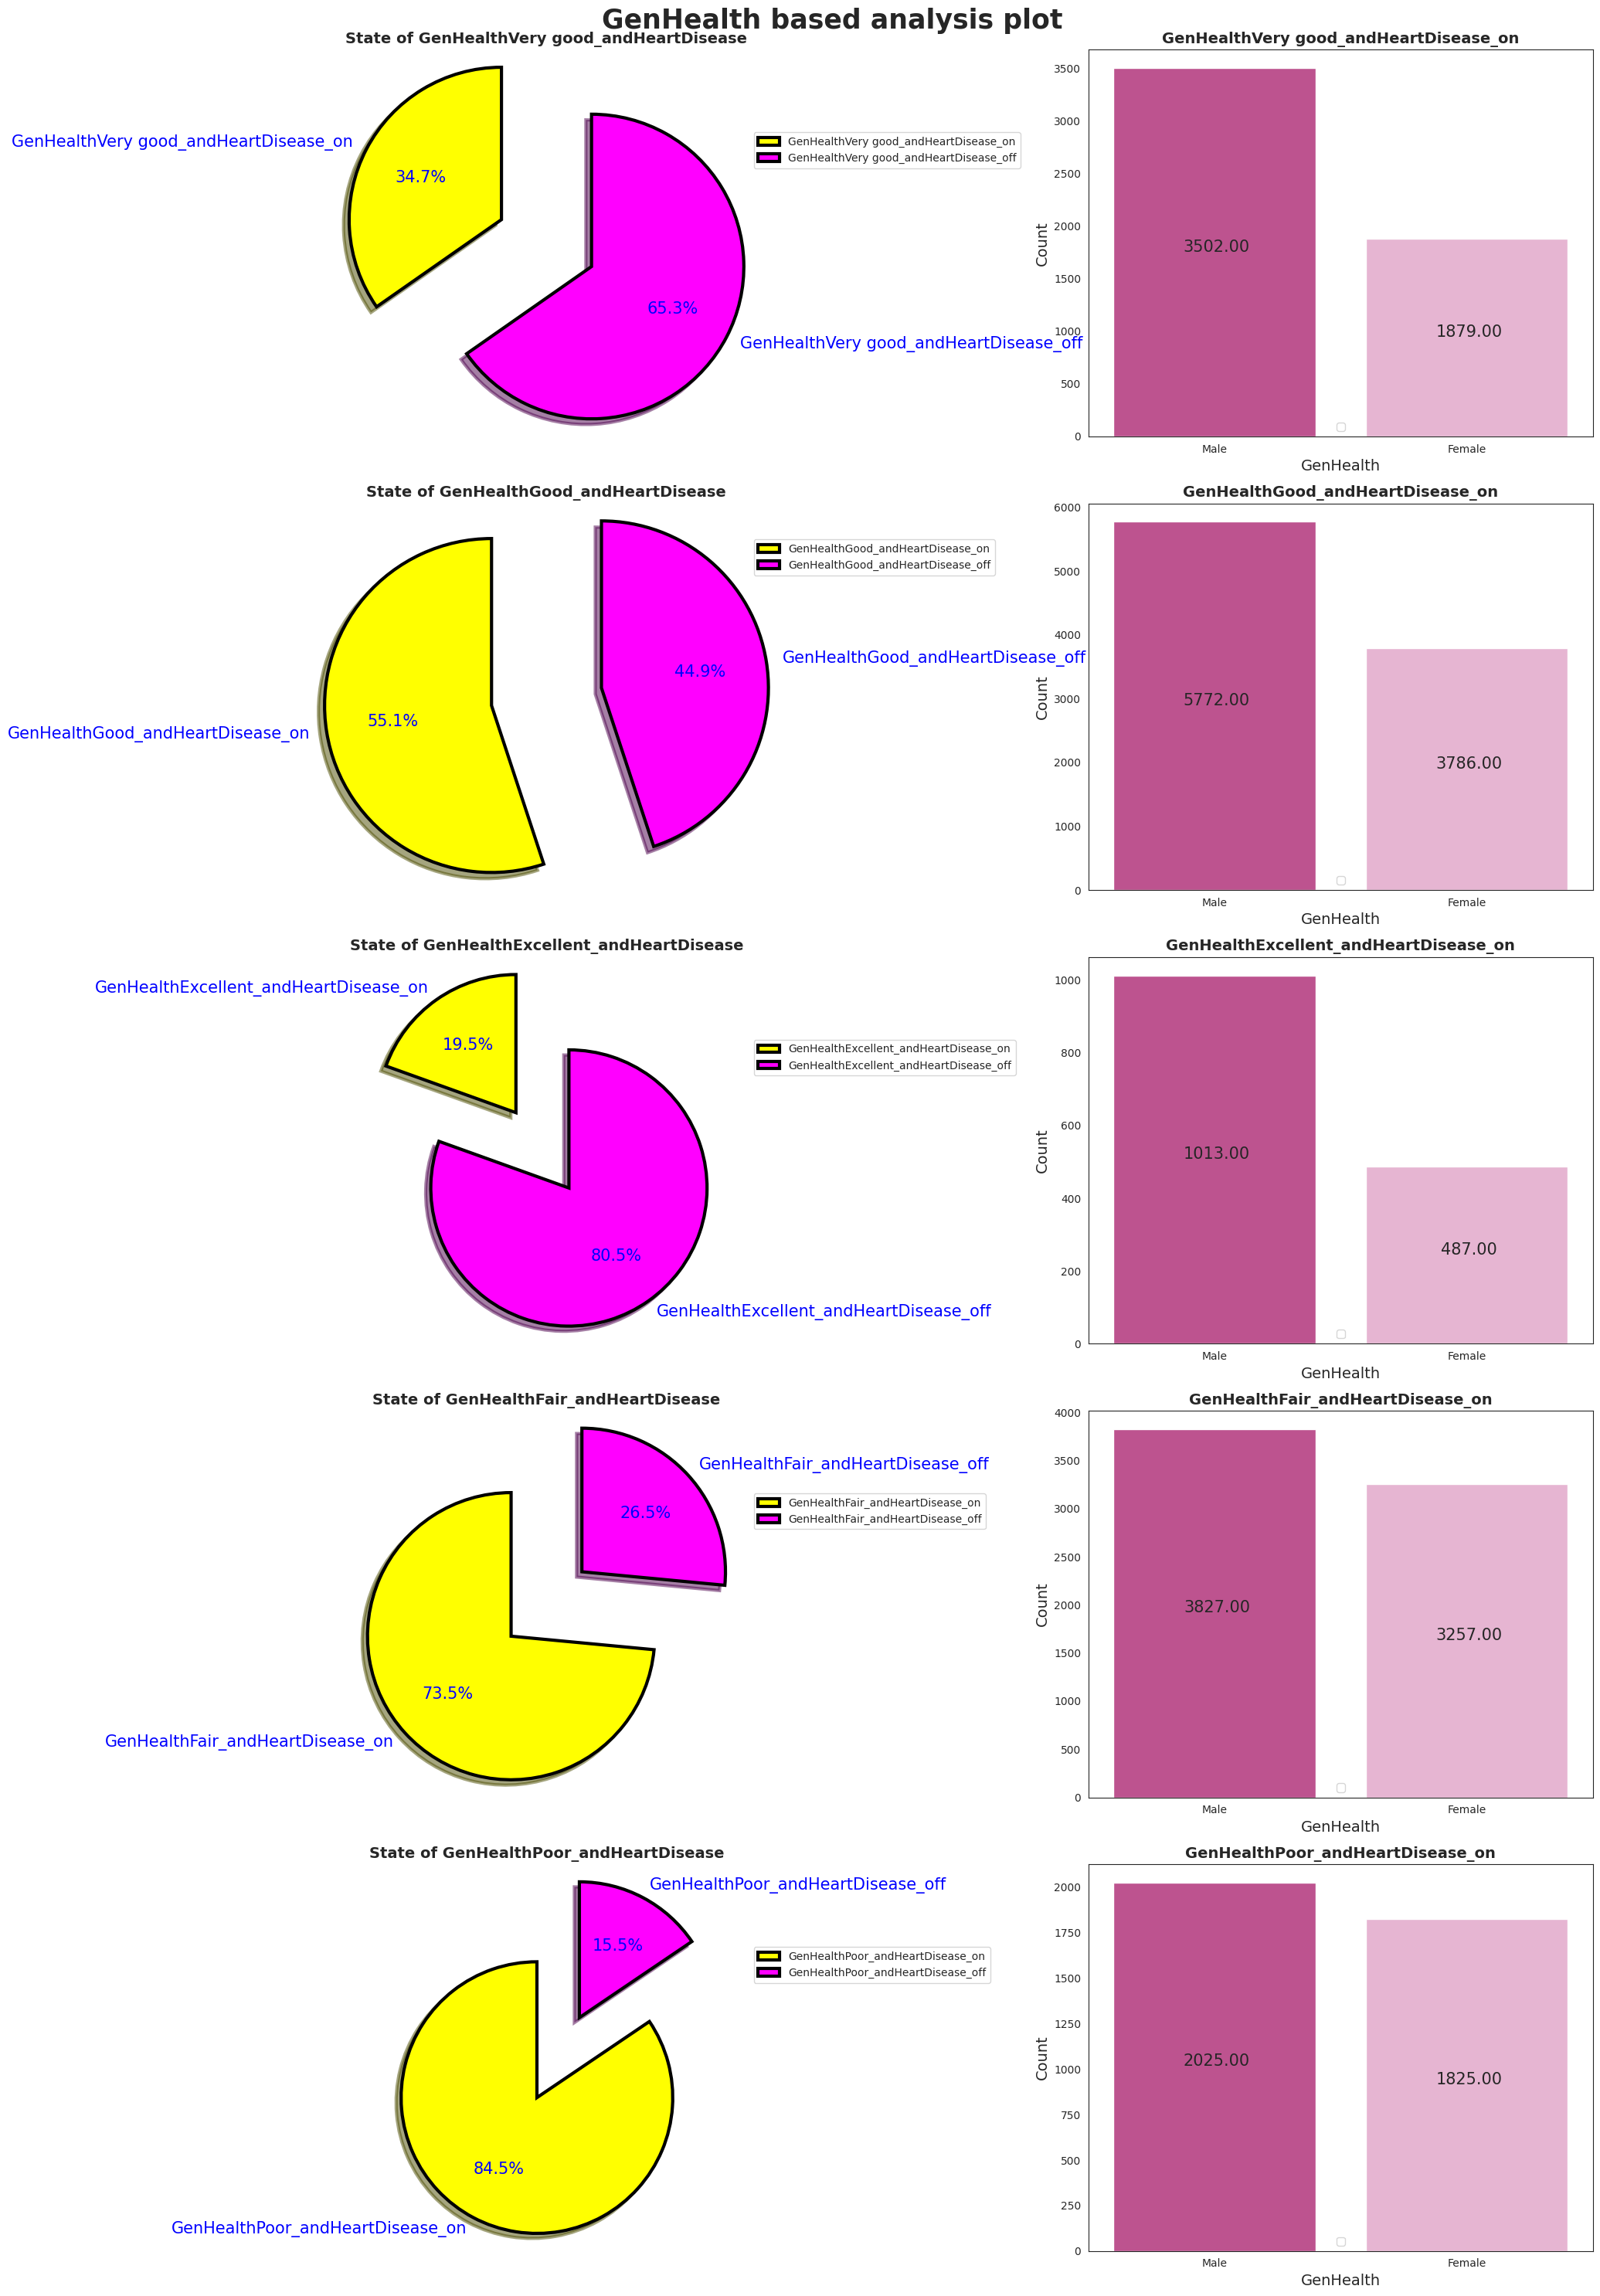

In [ ]:
fig=plt.figure(figsize=(20,30))
plt.suptitle("GenHealth based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(5,2,1)
GenHealthVery_good_andHeartDisease_on=len(data[(data.GenHealth=='Very good')&(data['HeartDisease']==1)])
GenHealthVery_good_andHeartDisease_off=len(data[(data.GenHealth=='Very good')&(data['HeartDisease']==0)])
y=['GenHealthVery good_andHeartDisease_on','GenHealthVery good_andHeartDisease_off']
x=[GenHealthVery_good_andHeartDisease_on,GenHealthVery_good_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of GenHealthVery good_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(5,2,2)
GenHealthVery_good_andHeartDisease_onmale=len(data[(data.GenHealth=='Very good')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

GenHealthVery_good_andHeartDisease_onfemale=len(data[(data.GenHealth=='Very good')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"GenHealth": ["Male","Female"],
         "Count": [GenHealthVery_good_andHeartDisease_onmale,GenHealthVery_good_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['GenHealth', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="GenHealth",y="Count", data=df,hue="GenHealth")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("GenHealth", size=14)

plt.ylabel("Count", size=14)

plt.title("GenHealthVery good_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(5,2,3)
GenHealthGood_andHeartDisease_on=len(data[(data.GenHealth=='Good')&(data['HeartDisease']==1)])
GenHealthGood_andHeartDisease_off=len(data[(data.GenHealth=='Good')&(data['HeartDisease']==0)])
y=['GenHealthGood_andHeartDisease_on','GenHealthGood_andHeartDisease_off']
x=[GenHealthGood_andHeartDisease_on,GenHealthGood_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of GenHealthGood_andHeartDisease',fontsize=14,fontweight="bold")



plt.subplot(5,2,4)
GenHealthGood_andHeartDisease_onmale=len(data[(data.GenHealth=='Good')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

GenHealthGood_andHeartDisease_onfemale=len(data[(data.GenHealth=='Good')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"GenHealth": ["Male","Female"],
         "Count": [GenHealthGood_andHeartDisease_onmale,GenHealthGood_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['GenHealth', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="GenHealth",y="Count", data=df,hue="GenHealth")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("GenHealth", size=14)

plt.ylabel("Count", size=14)

plt.title("GenHealthGood_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(5,2,5)
GenHealthExcellent_andHeartDisease_on=len(data[(data.GenHealth=='Excellent')&(data['HeartDisease']==1)])
GenHealthExcellent_andHeartDisease_off=len(data[(data.GenHealth=='Excellent')&(data['HeartDisease']==0)])
y=['GenHealthExcellent_andHeartDisease_on','GenHealthExcellent_andHeartDisease_off']
x=[GenHealthExcellent_andHeartDisease_on,GenHealthExcellent_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of GenHealthExcellent_andHeartDisease',fontsize=14,fontweight="bold")



plt.subplot(5,2,6)
GenHealthExcellent_andHeartDisease_onmale=len(data[(data.GenHealth=='Excellent')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

GenHealthExcellent_andHeartDisease_onfemale=len(data[(data.GenHealth=='Excellent')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"GenHealth": ["Male","Female"],
         "Count": [GenHealthExcellent_andHeartDisease_onmale,GenHealthExcellent_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['GenHealth', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="GenHealth",y="Count", data=df,hue="GenHealth")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("GenHealth", size=14)

plt.ylabel("Count", size=14)

plt.title("GenHealthExcellent_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(5,2,7)
GenHealthFair_andHeartDisease_on=len(data[(data.GenHealth=='Fair')&(data['HeartDisease']==1)])
GenHealthFair_andHeartDisease_off=len(data[(data.GenHealth=='Fair')&(data['HeartDisease']==0)])
y=['GenHealthFair_andHeartDisease_on','GenHealthFair_andHeartDisease_off']
x=[GenHealthFair_andHeartDisease_on,GenHealthFair_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of GenHealthFair_andHeartDisease',fontsize=14,fontweight="bold")


plt.subplot(5,2,8)
GenHealthFair_andHeartDisease_onmale=len(data[(data.GenHealth=='Fair')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

GenHealthFair_andHeartDisease_onfemale=len(data[(data.GenHealth=='Fair')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"GenHealth": ["Male","Female"],
         "Count": [GenHealthFair_andHeartDisease_onmale,GenHealthFair_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['GenHealth', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="GenHealth",y="Count", data=df,hue="GenHealth")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("GenHealth", size=14)

plt.ylabel("Count", size=14)

plt.title("GenHealthFair_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')

plt.subplot(5,2,9)
GenHealthPoor_andHeartDisease_on=len(data[(data.GenHealth=='Poor')&(data['HeartDisease']==1)])
GenHealthPoor_andHeartDisease_off=len(data[(data.GenHealth=='Poor')&(data['HeartDisease']==0)])
y=['GenHealthPoor_andHeartDisease_on','GenHealthPoor_andHeartDisease_off']
x=[GenHealthPoor_andHeartDisease_on,GenHealthPoor_andHeartDisease_off]
c=["yellow","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"black",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of GenHealthPoor_andHeartDisease',fontsize=14,fontweight="bold")



plt.subplot(5,2,10)
GenHealthPoor_andHeartDisease_onmale=len(data[(data.GenHealth=='Poor')&(data['HeartDisease']==1)
                                    &(data['Sex']==1)])

GenHealthPoor_andHeartDisease_onfemale=len(data[(data.GenHealth=='Poor')&(data['HeartDisease']==1)
                                    &(data['Sex']==0)])

data1 = {"GenHealth": ["Male","Female"],
         "Count": [GenHealthPoor_andHeartDisease_onmale,GenHealthPoor_andHeartDisease_onfemale]}
df = pd.DataFrame(data1, columns=['GenHealth', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="GenHealth",y="Count", data=df,hue="GenHealth")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("GenHealth", size=14)

plt.ylabel("Count", size=14)

plt.title("GenHealthPoor_andHeartDisease_on",fontsize=14,fontweight="bold")
plt.legend(loc='lower center')







plt.tight_layout()
plt.show()

## Observations:

Among various general health conditions, individuals with poor health have the highest risk of developing heart disease (34.1%). Additionally, among this group, men are more prone to experiencing heart disease.


<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs Difficulty in walking"</p>  

In [ ]:
data.DiffWalking.value_counts()

DiffWalking
0    41416
1    13330
Name: count, dtype: int64

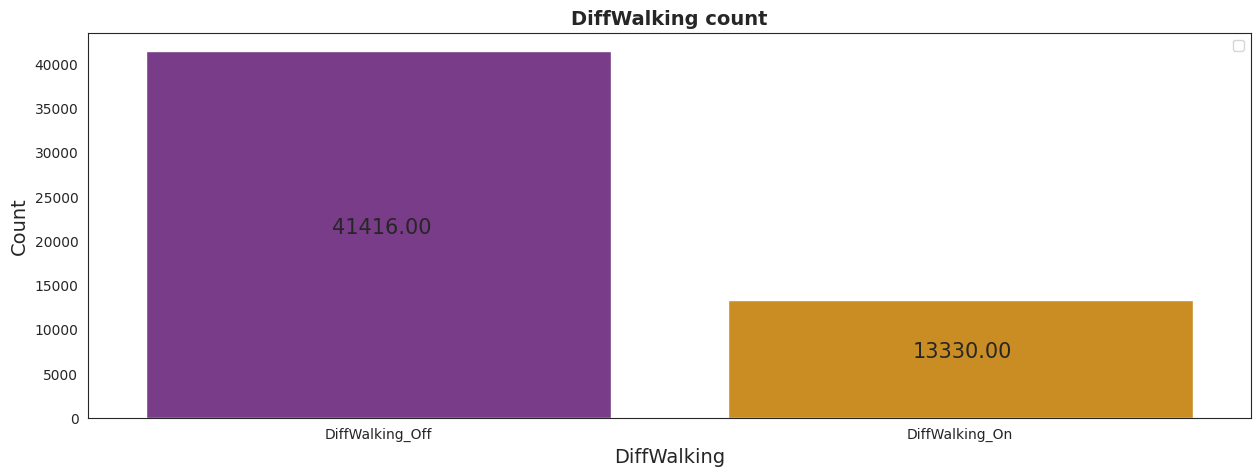

In [ ]:
data1 = {"DiffWalking":["DiffWalking_Off","DiffWalking_On"],
         "Count": list(dict(data.DiffWalking.value_counts()).values())}
df = pd.DataFrame(data1, columns=['DiffWalking', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="DiffWalking", y="Count", data=df,hue="DiffWalking",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("DiffWalking", size=14)

plt.ylabel("Count", size=14)

plt.title("DiffWalking count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

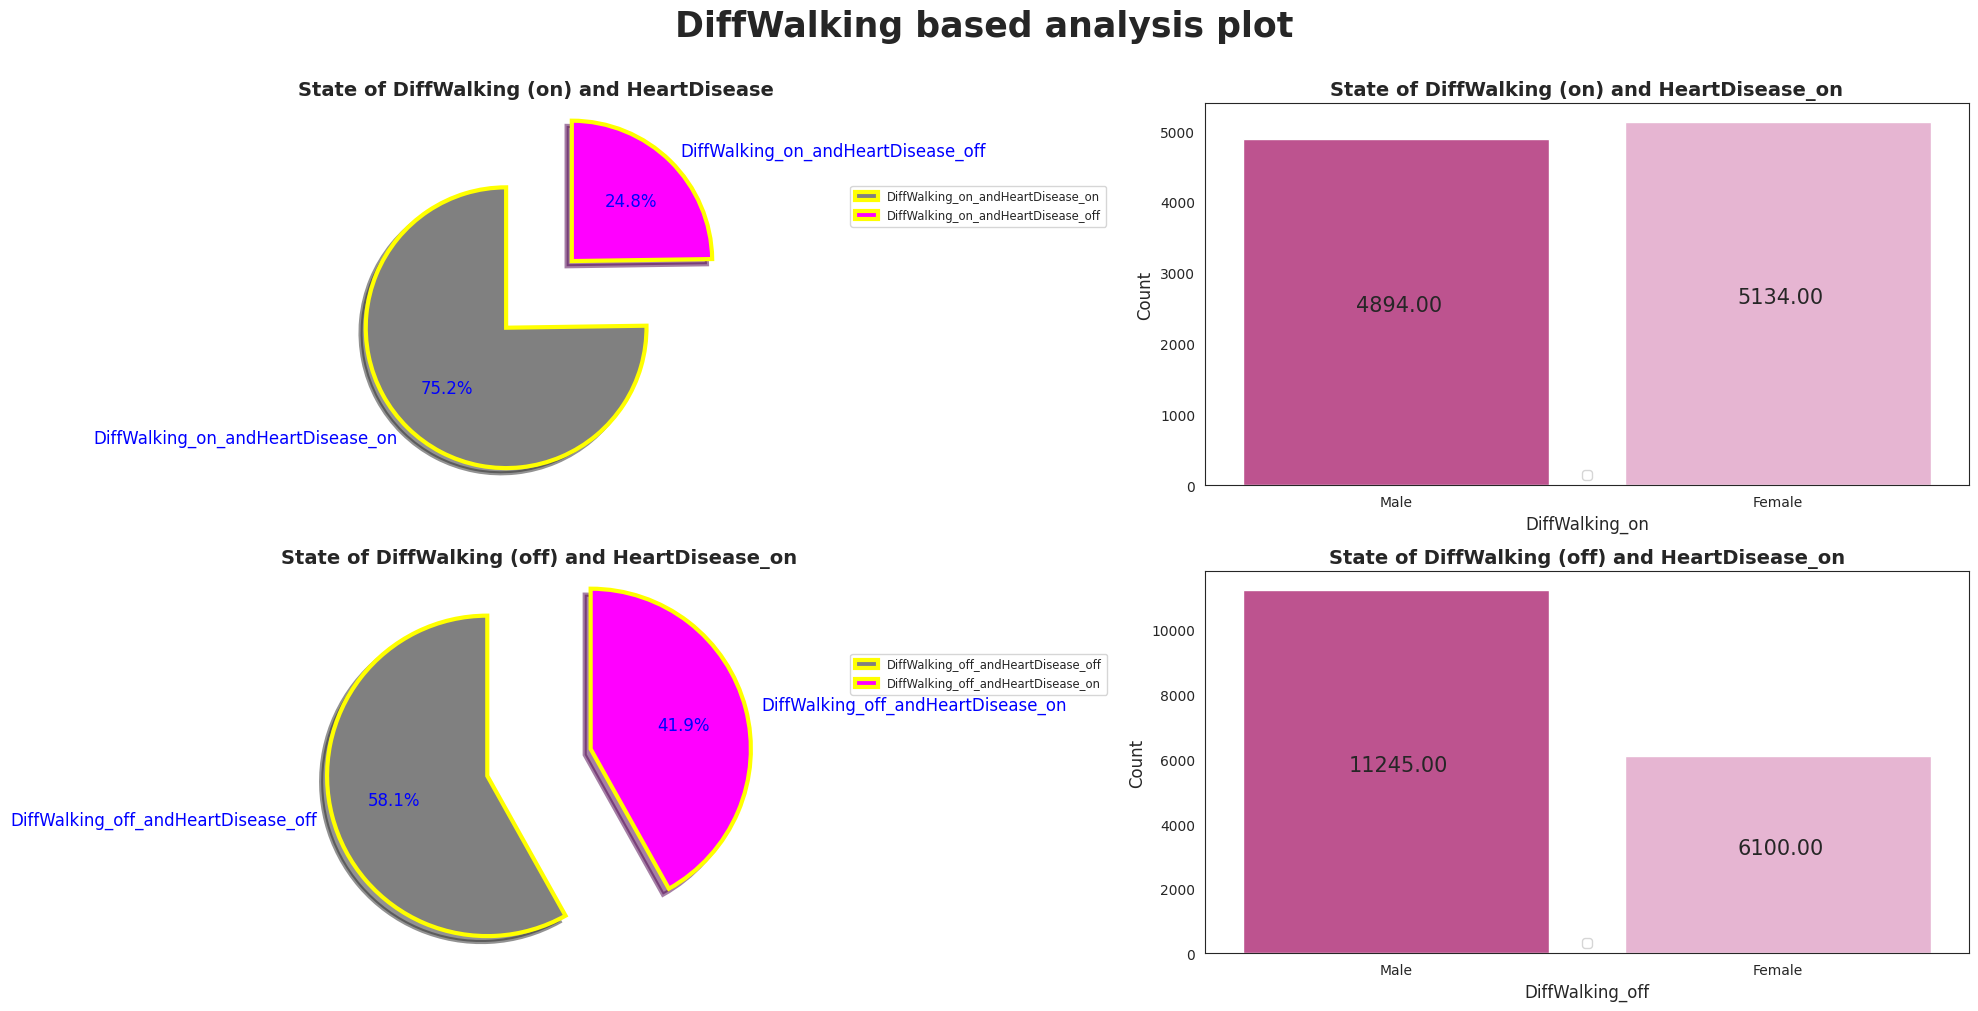

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("DiffWalking based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
DiffWalking_on_andHeartDisease_on=len(data[(data.DiffWalking==1)&(data['HeartDisease']==1)])
DiffWalking_on_andHeartDisease_off=len(data[(data.DiffWalking==1)&(data['HeartDisease']==0)])
y=['DiffWalking_on_andHeartDisease_on','DiffWalking_on_andHeartDisease_off']
x=[DiffWalking_on_andHeartDisease_on,DiffWalking_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":12}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of DiffWalking (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
DiffWalking_on_andHeartDisease_on_onmale=len(data[(data.DiffWalking==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
DiffWalking_on_andHeartDisease_on_onfemale=len(data[(data.DiffWalking==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"DiffWalking_on": ["Male","Female"],
         "Count": [DiffWalking_on_andHeartDisease_on_onmale,DiffWalking_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['DiffWalking_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="DiffWalking_on",y="Count", data=df,hue="DiffWalking_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("DiffWalking_on", size=12)

plt.ylabel("Count", size=12)

plt.title('State of DiffWalking (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center',fontsize='small')


plt.subplot(2,2,3)
DiffWalking_off_andHeartDisease_off=len(data[(data.DiffWalking==0)&(data['HeartDisease']==0)])
DiffWalking_off_andHeartDisease_on=len(data[(data.DiffWalking==0)&(data['HeartDisease']==1)])
y=['DiffWalking_off_andHeartDisease_off','DiffWalking_off_andHeartDisease_on']
x=[DiffWalking_off_andHeartDisease_off,DiffWalking_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":12}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of DiffWalking (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
DiffWalking_off_andHeartDisease_on_onmale=len(data[(data.DiffWalking==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
DiffWalking_off_andHeartDisease_on_onfemale=len(data[(data.DiffWalking==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"DiffWalking_off": ["Male","Female"],
         "Count": [DiffWalking_off_andHeartDisease_on_onmale,DiffWalking_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['DiffWalking_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="DiffWalking_off",y="Count", data=df,hue="DiffWalking_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("DiffWalking_off", size=12)

plt.ylabel("Count", size=12)

plt.title('State of DiffWalking (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center',fontsize='small')


plt.tight_layout()
plt.show()


## Observations:
People who have difficulty in walking are at a higher risk of heart disease, and among them, women have more cases of heart disease. However, in the case of people with heart disease but without difficulty in walking, the number of cases of heart disease is more for  men than women.   

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs Stroke"</p>

In [ ]:
data.Stroke .value_counts()

Stroke
0    49620
1     5126
Name: count, dtype: int64

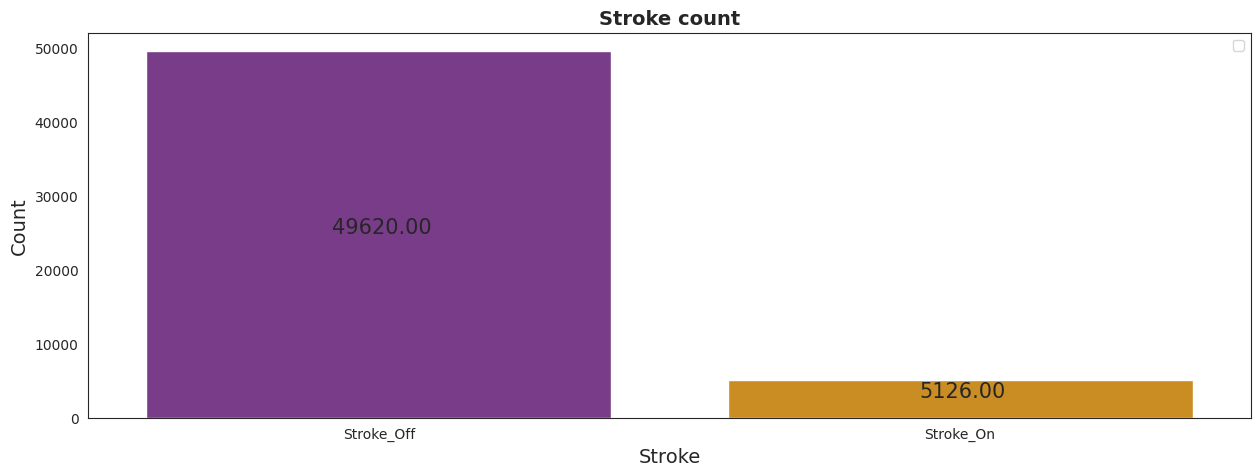

In [ ]:
data1 = {"Stroke":["Stroke_Off","Stroke_On"],
         "Count": list(dict(data.Stroke.value_counts()).values())}
df = pd.DataFrame(data1, columns=['Stroke', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="Stroke", y="Count", data=df,hue="Stroke",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Stroke", size=14)

plt.ylabel("Count", size=14)

plt.title("Stroke count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

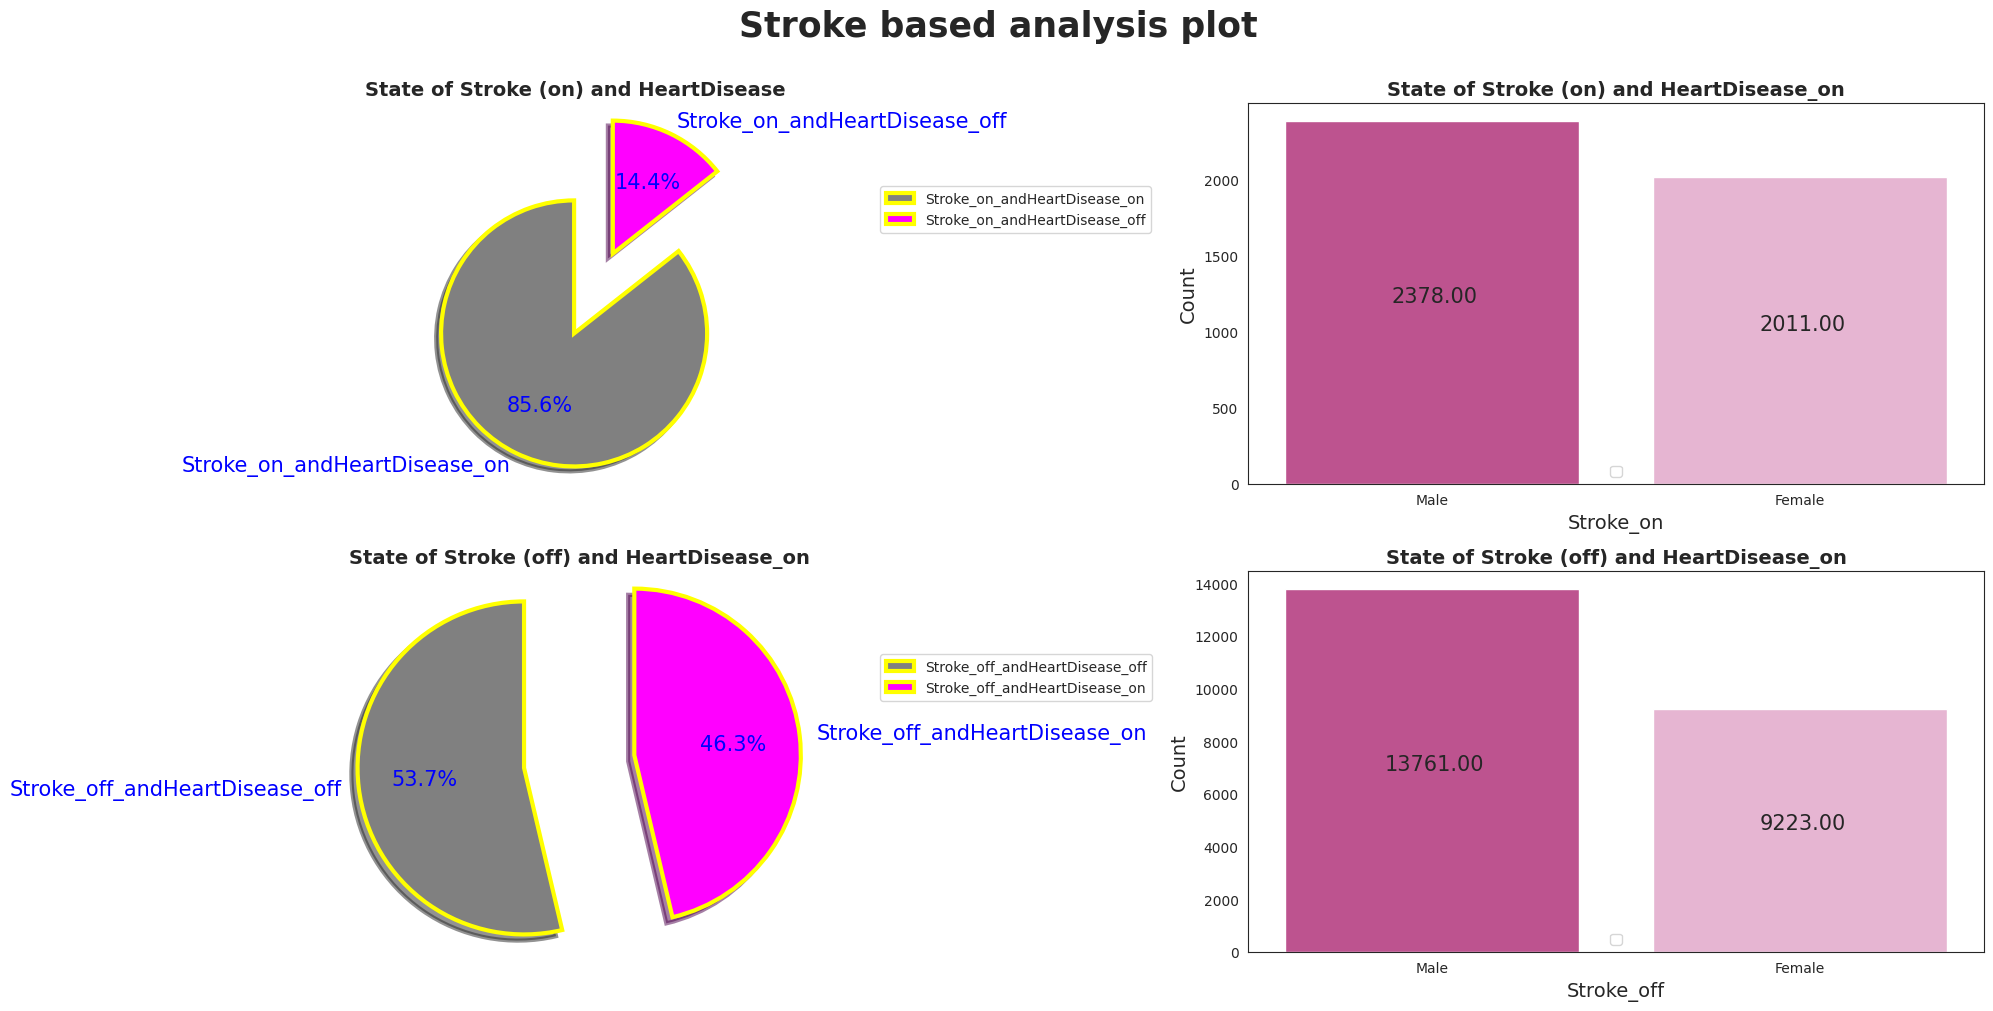

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("Stroke based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
Stroke_on_andHeartDisease_on=len(data[(data.Stroke==1)&(data['HeartDisease']==1)])
Stroke_on_andHeartDisease_off=len(data[(data.Stroke==1)&(data['HeartDisease']==0)])
y=['Stroke_on_andHeartDisease_on','Stroke_on_andHeartDisease_off']
x=[Stroke_on_andHeartDisease_on,Stroke_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Stroke (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
Stroke_on_andHeartDisease_on_onmale=len(data[(data.Stroke==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Stroke_on_andHeartDisease_on_onfemale=len(data[(data.Stroke==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Stroke_on": ["Male","Female"],
         "Count": [Stroke_on_andHeartDisease_on_onmale,Stroke_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Stroke_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Stroke_on",y="Count", data=df,hue="Stroke_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Stroke_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Stroke (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
Stroke_off_andHeartDisease_off=len(data[(data.Stroke==0)&(data['HeartDisease']==0)])
Stroke_off_andHeartDisease_on=len(data[(data.Stroke==0)&(data['HeartDisease']==1)])
y=['Stroke_off_andHeartDisease_off','Stroke_off_andHeartDisease_on']
x=[Stroke_off_andHeartDisease_off,Stroke_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Stroke (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
Stroke_off_andHeartDisease_on_onmale=len(data[(data.Stroke==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Stroke_off_andHeartDisease_on_onfemale=len(data[(data.Stroke==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Stroke_off": ["Male","Female"],
         "Count": [Stroke_off_andHeartDisease_on_onmale,Stroke_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Stroke_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Stroke_off",y="Count", data=df,hue="Stroke_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Stroke_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Stroke (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()


## Observations:
Individuals who have suffered from a stroke are at an elevated risk of developing heart disease, with men experiencing a greater incidence of this condition.

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs Diabetic"</p>

In [ ]:
data.Diabetic.value_counts()

Diabetic
0    42423
1    12323
Name: count, dtype: int64

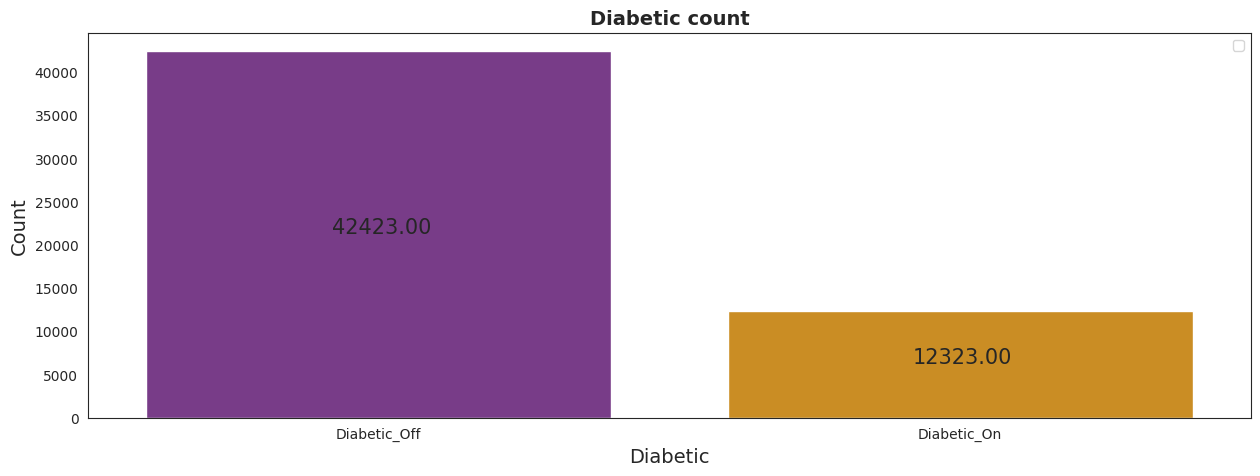

In [ ]:
data1 = {"Diabetic":["Diabetic_Off","Diabetic_On"],
         "Count": list(dict(data.Diabetic.value_counts()).values())}
df = pd.DataFrame(data1, columns=['Diabetic', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="Diabetic", y="Count", data=df,hue="Diabetic",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Diabetic", size=14)

plt.ylabel("Count", size=14)

plt.title("Diabetic count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

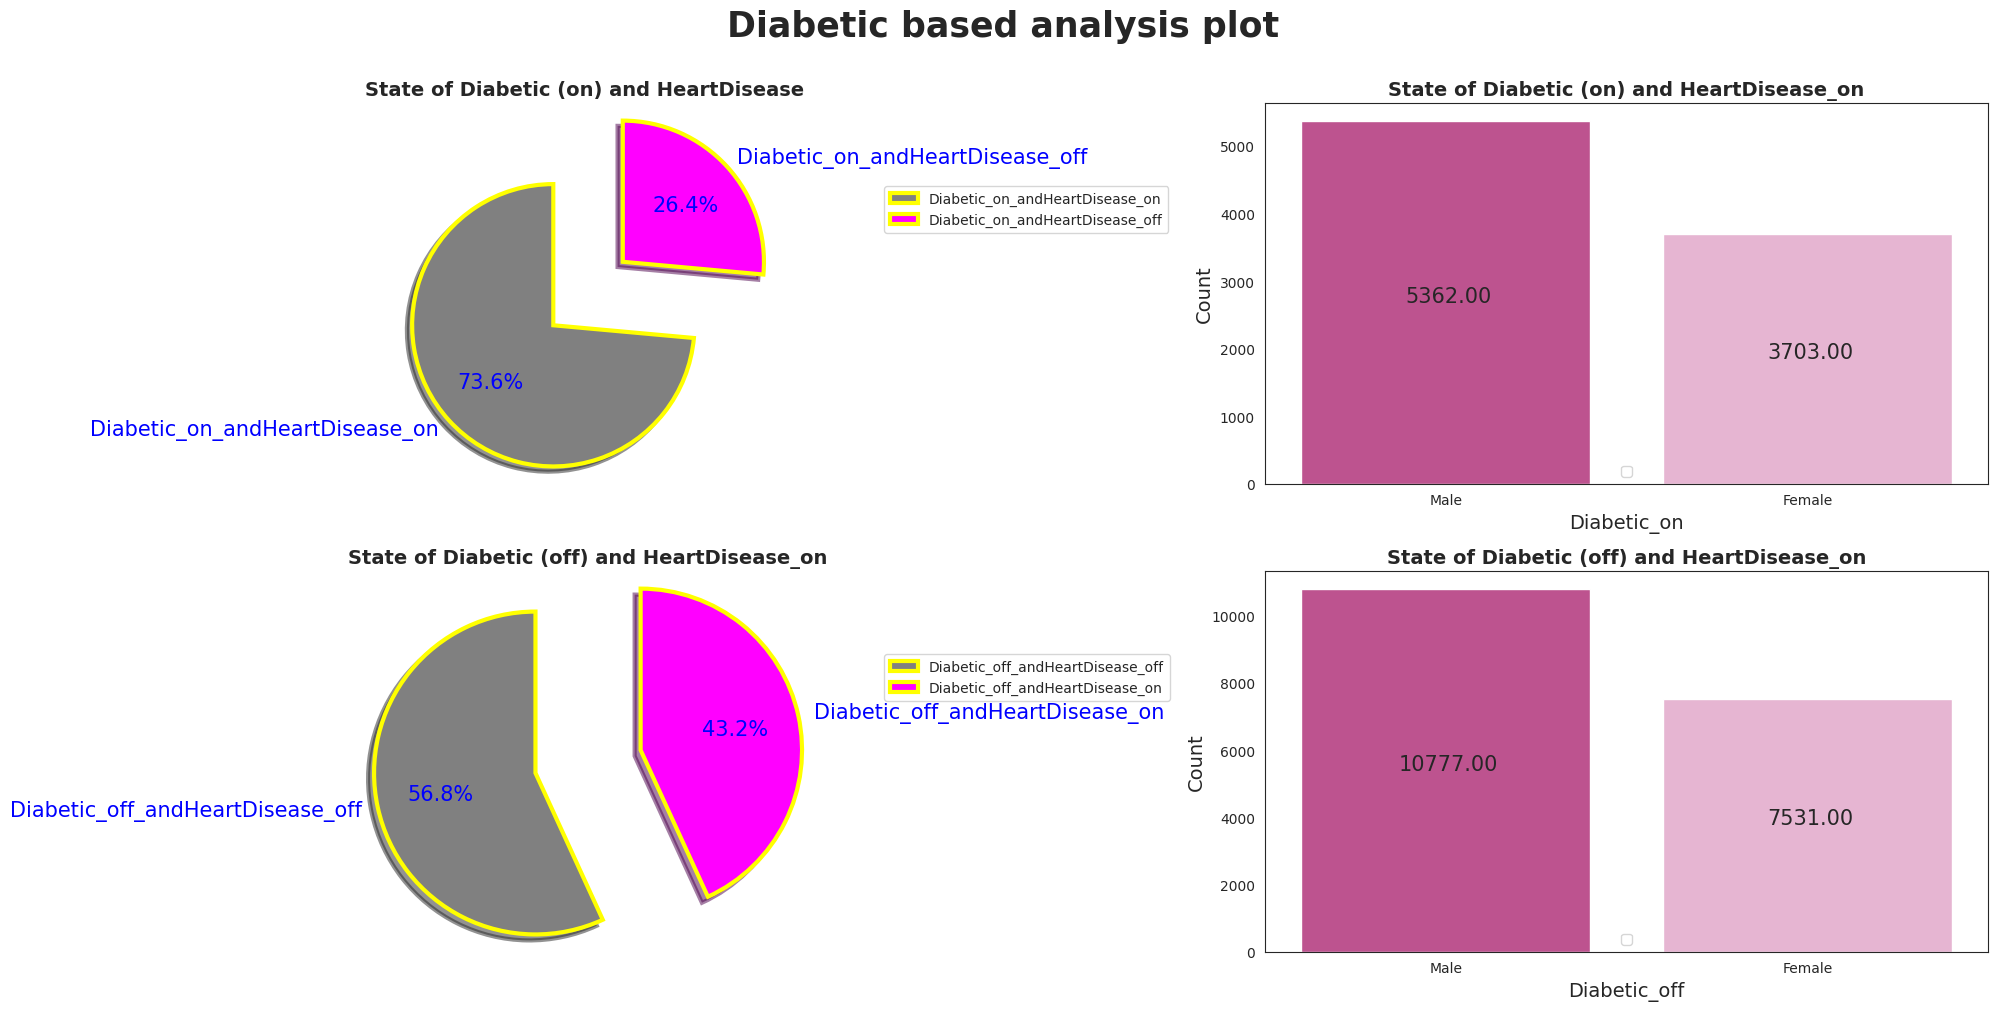

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("Diabetic based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
Diabetic_on_andHeartDisease_on=len(data[(data.Diabetic==1)&(data['HeartDisease']==1)])
Diabetic_on_andHeartDisease_off=len(data[(data.Diabetic==1)&(data['HeartDisease']==0)])
y=['Diabetic_on_andHeartDisease_on','Diabetic_on_andHeartDisease_off']
x=[Diabetic_on_andHeartDisease_on,Diabetic_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Diabetic (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
Diabetic_on_andHeartDisease_on_onmale=len(data[(data.Diabetic==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Diabetic_on_andHeartDisease_on_onfemale=len(data[(data.Diabetic==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Diabetic_on": ["Male","Female"],
         "Count": [Diabetic_on_andHeartDisease_on_onmale,Diabetic_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Diabetic_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Diabetic_on",y="Count", data=df,hue="Diabetic_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Diabetic_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Diabetic (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
Diabetic_off_andHeartDisease_off=len(data[(data.Diabetic==0)&(data['HeartDisease']==0)])
Diabetic_off_andHeartDisease_on=len(data[(data.Diabetic==0)&(data['HeartDisease']==1)])
y=['Diabetic_off_andHeartDisease_off','Diabetic_off_andHeartDisease_on']
x=[Diabetic_off_andHeartDisease_off,Diabetic_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Diabetic (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
Diabetic_off_andHeartDisease_on_onmale=len(data[(data.Diabetic==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Diabetic_off_andHeartDisease_on_onfemale=len(data[(data.Diabetic==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Diabetic_off": ["Male","Female"],
         "Count": [Diabetic_off_andHeartDisease_on_onmale,Diabetic_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Diabetic_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Diabetic_off",y="Count", data=df,hue="Diabetic_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Diabetic_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Diabetic (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()

## Observations:
People who have diabetes are at an increased risk of developing heart disease, and among them, men have a higher likelihood of experiencing this condition.  

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs KidneyDisease"</p>

In [ ]:
data.KidneyDisease.value_counts()

KidneyDisease
0    50530
1     4216
Name: count, dtype: int64

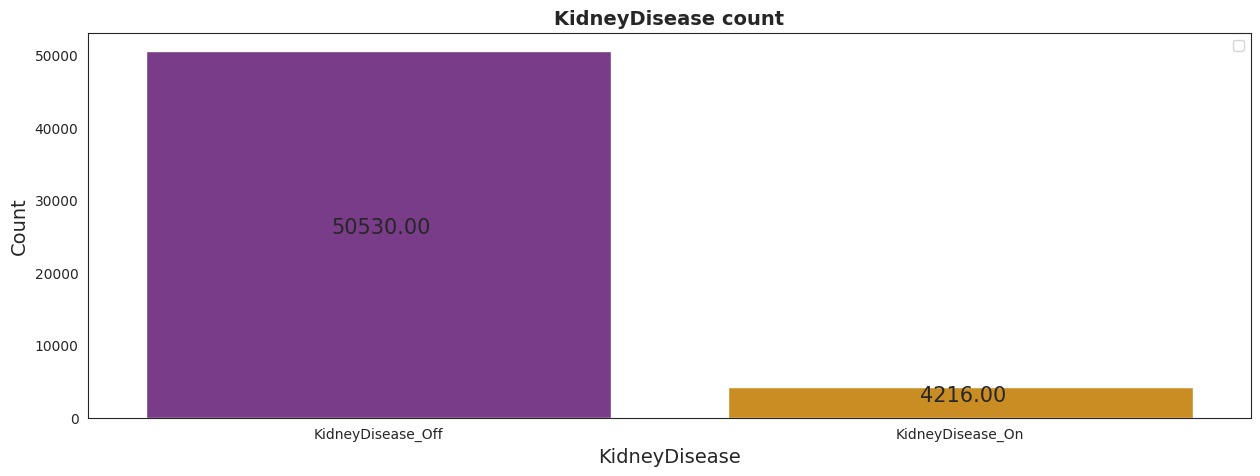

In [ ]:
data1 = {"KidneyDisease":["KidneyDisease_Off","KidneyDisease_On"],
         "Count": list(dict(data.KidneyDisease.value_counts()).values())}
df = pd.DataFrame(data1, columns=['KidneyDisease', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="KidneyDisease", y="Count", data=df,hue="KidneyDisease",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("KidneyDisease", size=14)

plt.ylabel("Count", size=14)

plt.title("KidneyDisease count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

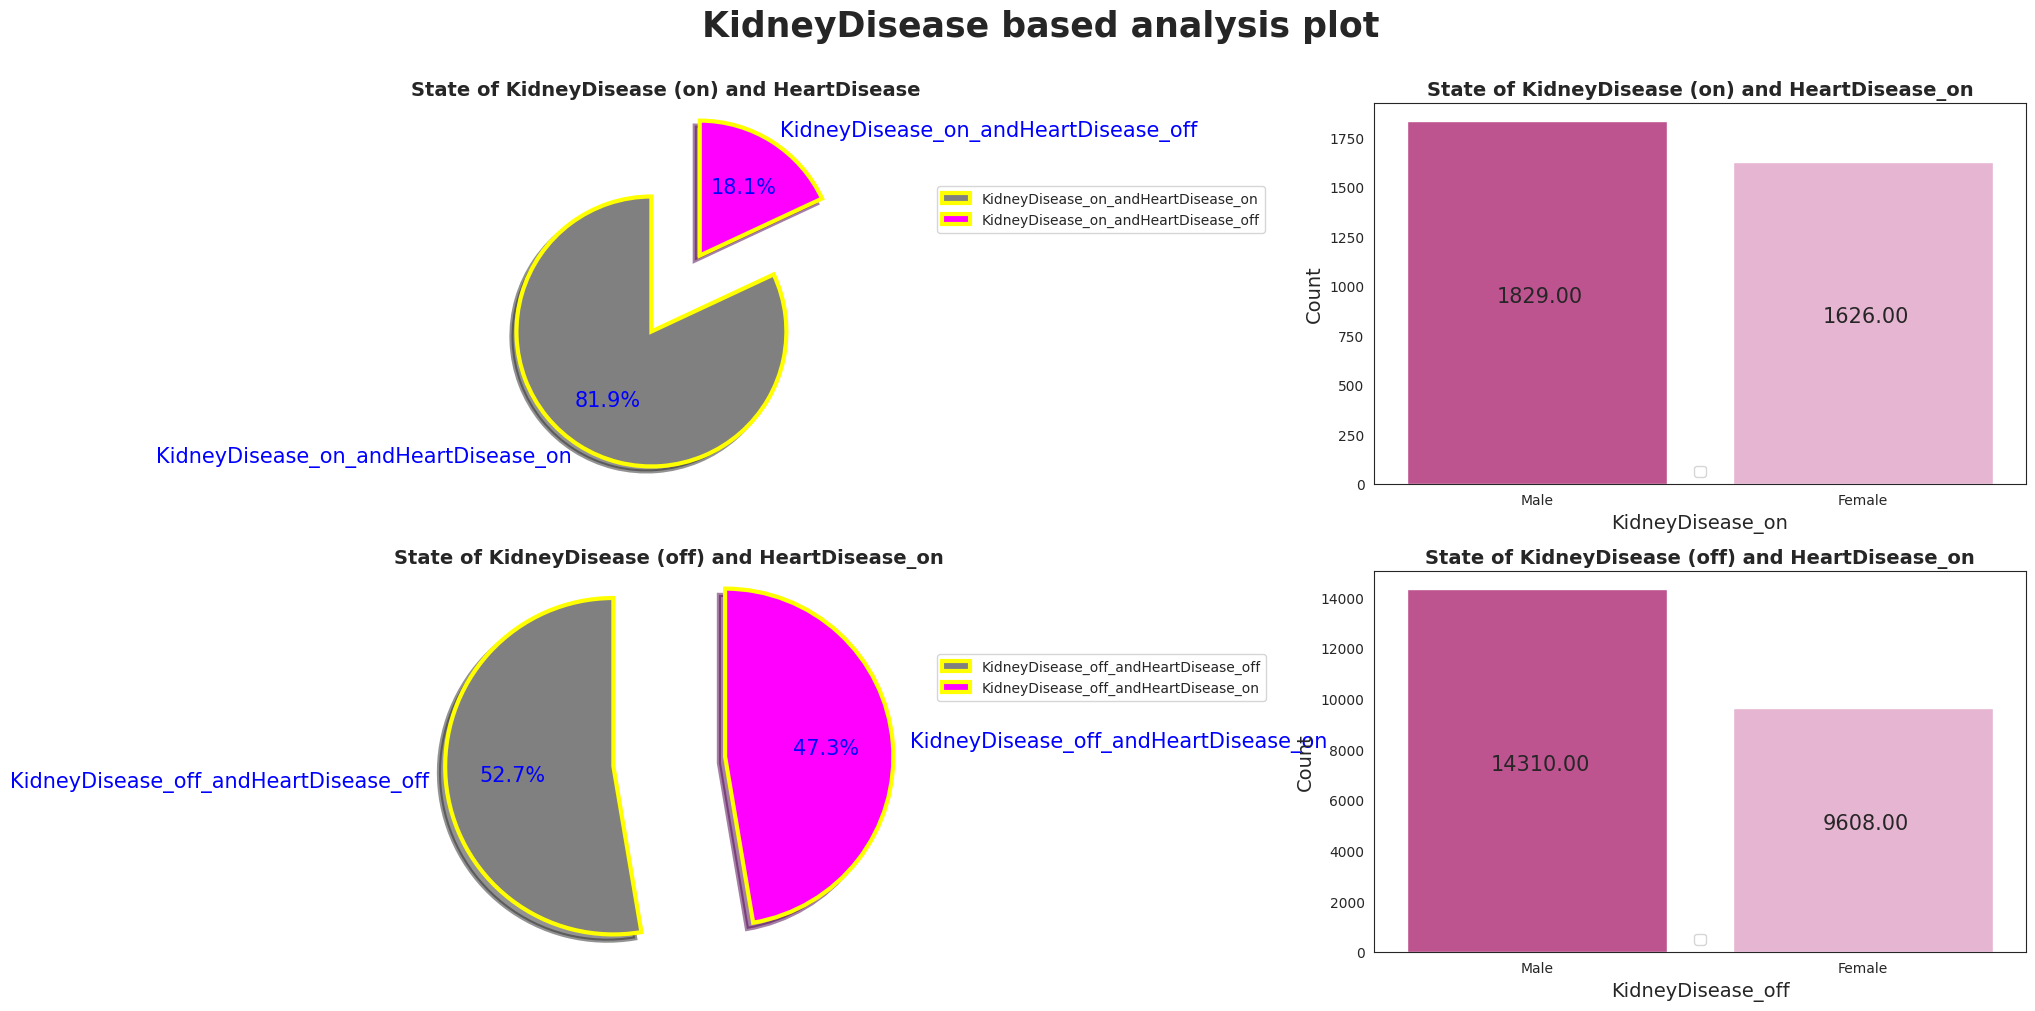

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("KidneyDisease based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
KidneyDisease_on_andHeartDisease_on=len(data[(data.KidneyDisease==1)&(data['HeartDisease']==1)])
KidneyDisease_on_andHeartDisease_off=len(data[(data.KidneyDisease==1)&(data['HeartDisease']==0)])
y=['KidneyDisease_on_andHeartDisease_on','KidneyDisease_on_andHeartDisease_off']
x=[KidneyDisease_on_andHeartDisease_on,KidneyDisease_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of KidneyDisease (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
KidneyDisease_on_andHeartDisease_on_onmale=len(data[(data.KidneyDisease==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
KidneyDisease_on_andHeartDisease_on_onfemale=len(data[(data.KidneyDisease==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"KidneyDisease_on": ["Male","Female"],
         "Count": [KidneyDisease_on_andHeartDisease_on_onmale,KidneyDisease_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['KidneyDisease_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="KidneyDisease_on",y="Count", data=df,hue="KidneyDisease_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("KidneyDisease_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of KidneyDisease (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
KidneyDisease_off_andHeartDisease_off=len(data[(data.KidneyDisease==0)&(data['HeartDisease']==0)])
KidneyDisease_off_andHeartDisease_on=len(data[(data.KidneyDisease==0)&(data['HeartDisease']==1)])
y=['KidneyDisease_off_andHeartDisease_off','KidneyDisease_off_andHeartDisease_on']
x=[KidneyDisease_off_andHeartDisease_off,KidneyDisease_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of KidneyDisease (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
KidneyDisease_off_andHeartDisease_on_onmale=len(data[(data.KidneyDisease==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
KidneyDisease_off_andHeartDisease_on_onfemale=len(data[(data.KidneyDisease==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"KidneyDisease_off": ["Male","Female"],
         "Count": [KidneyDisease_off_andHeartDisease_on_onmale,KidneyDisease_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['KidneyDisease_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="KidneyDisease_off",y="Count", data=df,hue="KidneyDisease_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("KidneyDisease_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of KidneyDisease (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()

## Observations:
Individuals with kidney disease have a higher risk of developing heart disease, with men being more prone to this condition.

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs Smoking"</p>

In [ ]:
data.Smoking.value_counts()

Smoking
0    27992
1    26754
Name: count, dtype: int64

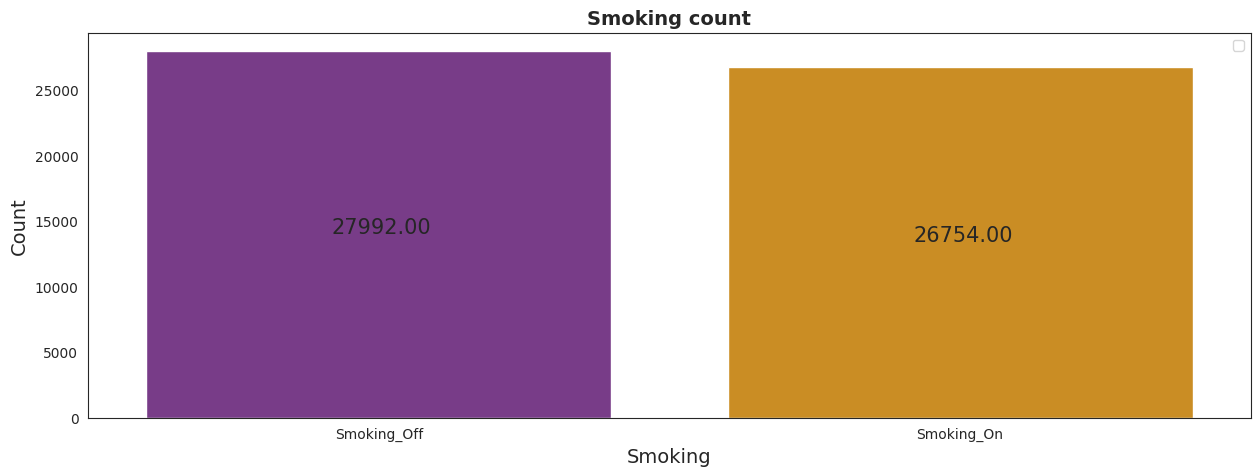

In [ ]:
data1 = {"Smoking":["Smoking_Off","Smoking_On"],
         "Count": list(dict(data.Smoking.value_counts()).values())}
df = pd.DataFrame(data1, columns=['Smoking', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="Smoking", y="Count", data=df,hue="Smoking",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Smoking", size=14)

plt.ylabel("Count", size=14)

plt.title("Smoking count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

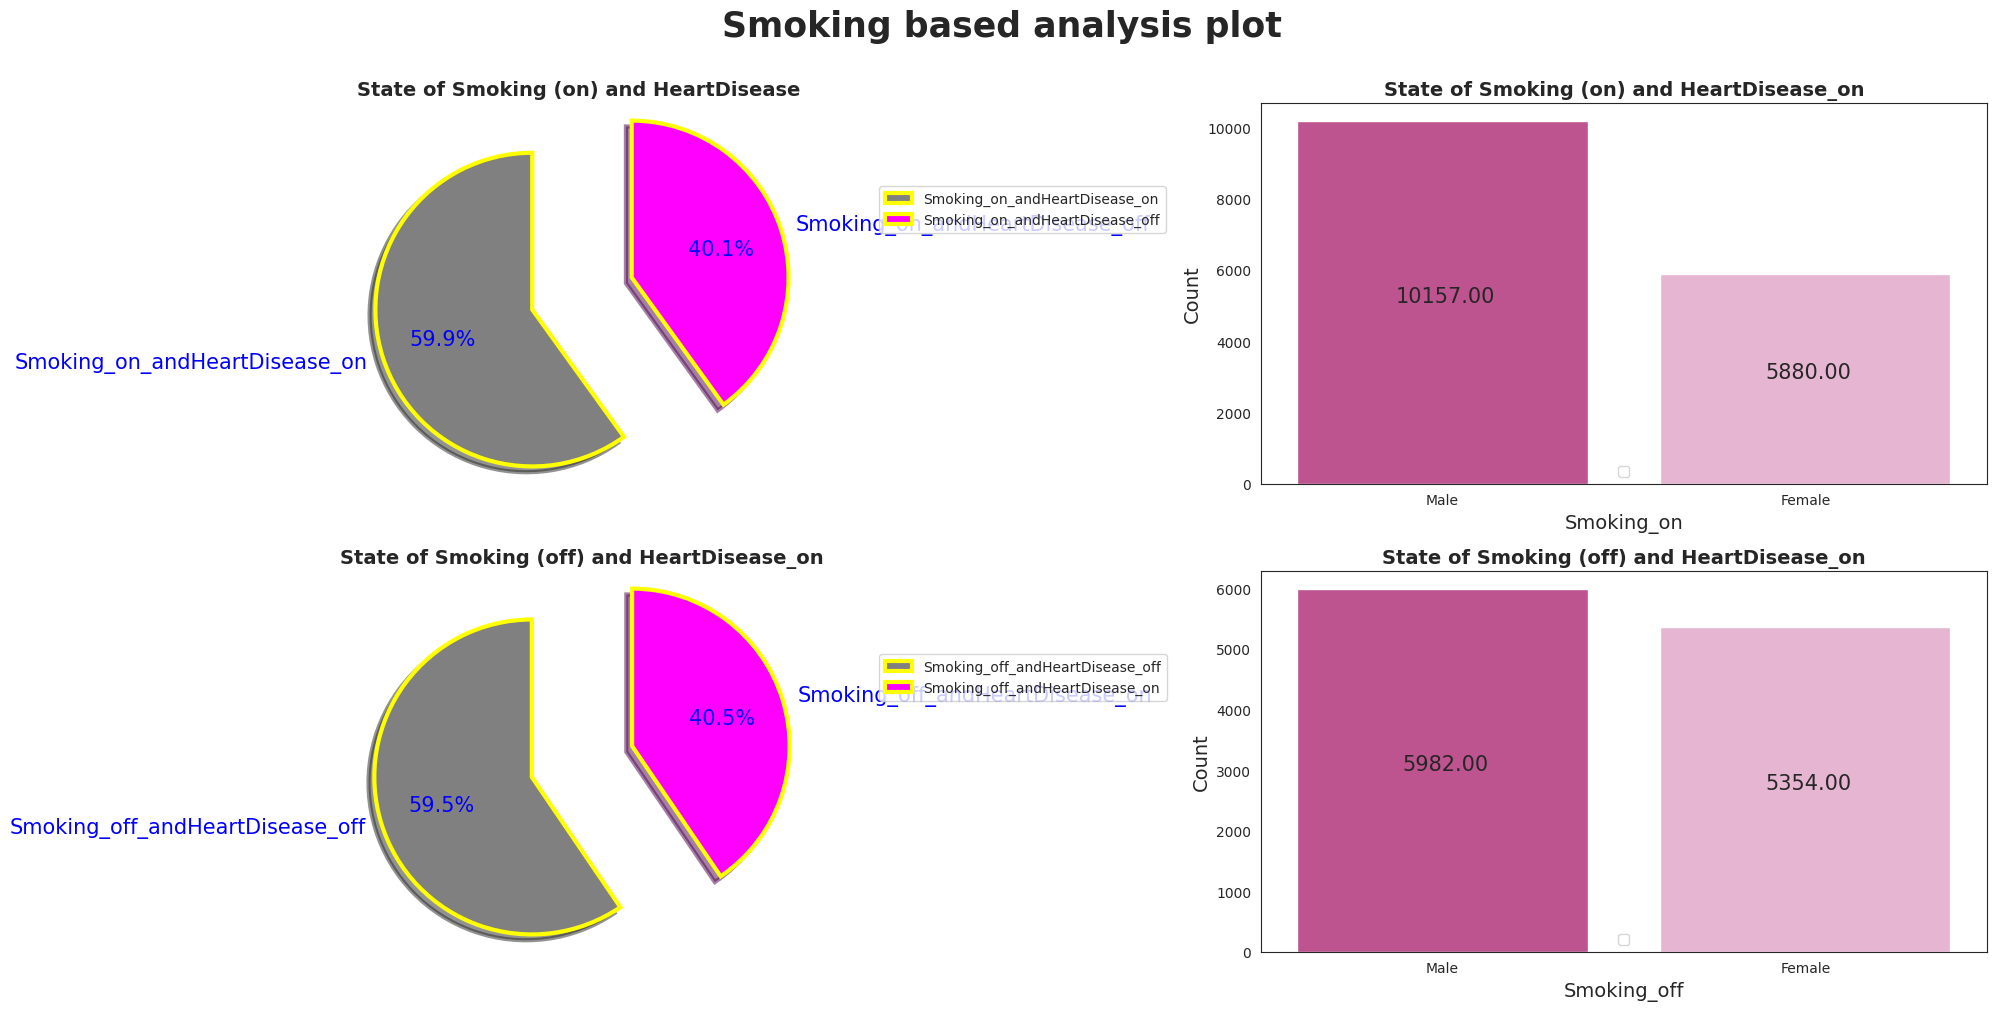

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("Smoking based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
Smoking_on_andHeartDisease_on=len(data[(data.Smoking==1)&(data['HeartDisease']==1)])
Smoking_on_andHeartDisease_off=len(data[(data.Smoking==1)&(data['HeartDisease']==0)])
y=['Smoking_on_andHeartDisease_on','Smoking_on_andHeartDisease_off']
x=[Smoking_on_andHeartDisease_on,Smoking_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Smoking (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
Smoking_on_andHeartDisease_on_onmale=len(data[(data.Smoking==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Smoking_on_andHeartDisease_on_onfemale=len(data[(data.Smoking==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Smoking_on": ["Male","Female"],
         "Count": [Smoking_on_andHeartDisease_on_onmale,Smoking_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Smoking_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Smoking_on",y="Count", data=df,hue="Smoking_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Smoking_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Smoking (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
Smoking_off_andHeartDisease_off=len(data[(data.Smoking==0)&(data['HeartDisease']==0)])
Smoking_off_andHeartDisease_on=len(data[(data.Smoking==0)&(data['HeartDisease']==1)])
y=['Smoking_off_andHeartDisease_off','Smoking_off_andHeartDisease_on']
x=[Smoking_off_andHeartDisease_off,Smoking_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Smoking (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
Smoking_off_andHeartDisease_on_onmale=len(data[(data.Smoking==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Smoking_off_andHeartDisease_on_onfemale=len(data[(data.Smoking==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Smoking_off": ["Male","Female"],
         "Count": [Smoking_off_andHeartDisease_on_onmale,Smoking_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Smoking_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Smoking_off",y="Count", data=df,hue="Smoking_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Smoking_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Smoking (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()

## Observations:
Smoking increases the likelihood of developing heart disease, with men are more likely to experience this condition. However, in individuals with heart disease but no history of smoking, both men and women being at a similar risk.

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs PhysicalActivity"</p>

In [ ]:
data.PhysicalActivity.value_counts()

PhysicalActivity
1    39013
0    15733
Name: count, dtype: int64

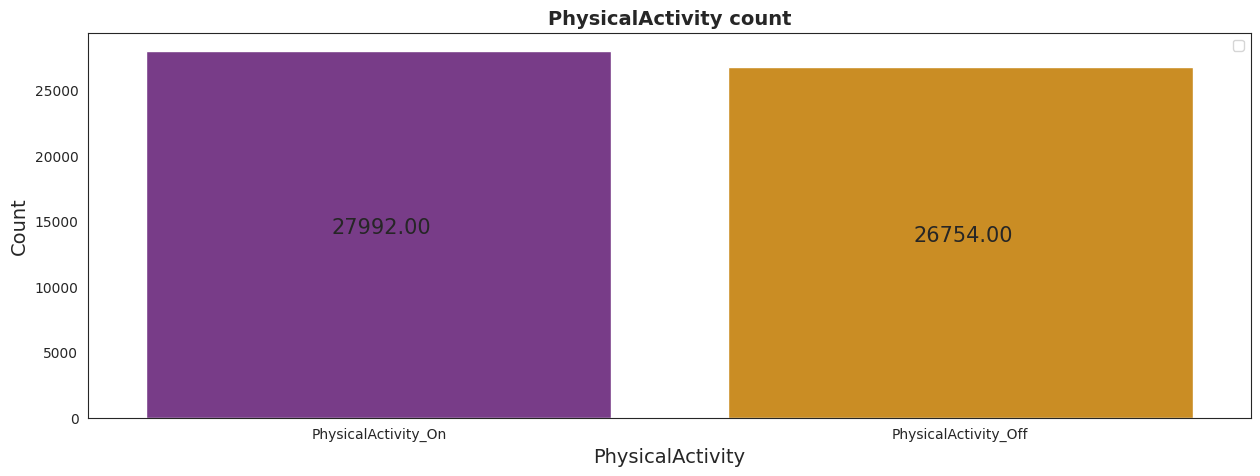

In [ ]:
data1 = {"PhysicalActivity":["PhysicalActivity_On","PhysicalActivity_Off"],
         "Count": list(dict(data.Smoking.value_counts()).values())}
df = pd.DataFrame(data1, columns=['PhysicalActivity', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="PhysicalActivity", y="Count", data=df,hue="PhysicalActivity",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("PhysicalActivity", size=14)

plt.ylabel("Count", size=14)

plt.title("PhysicalActivity count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

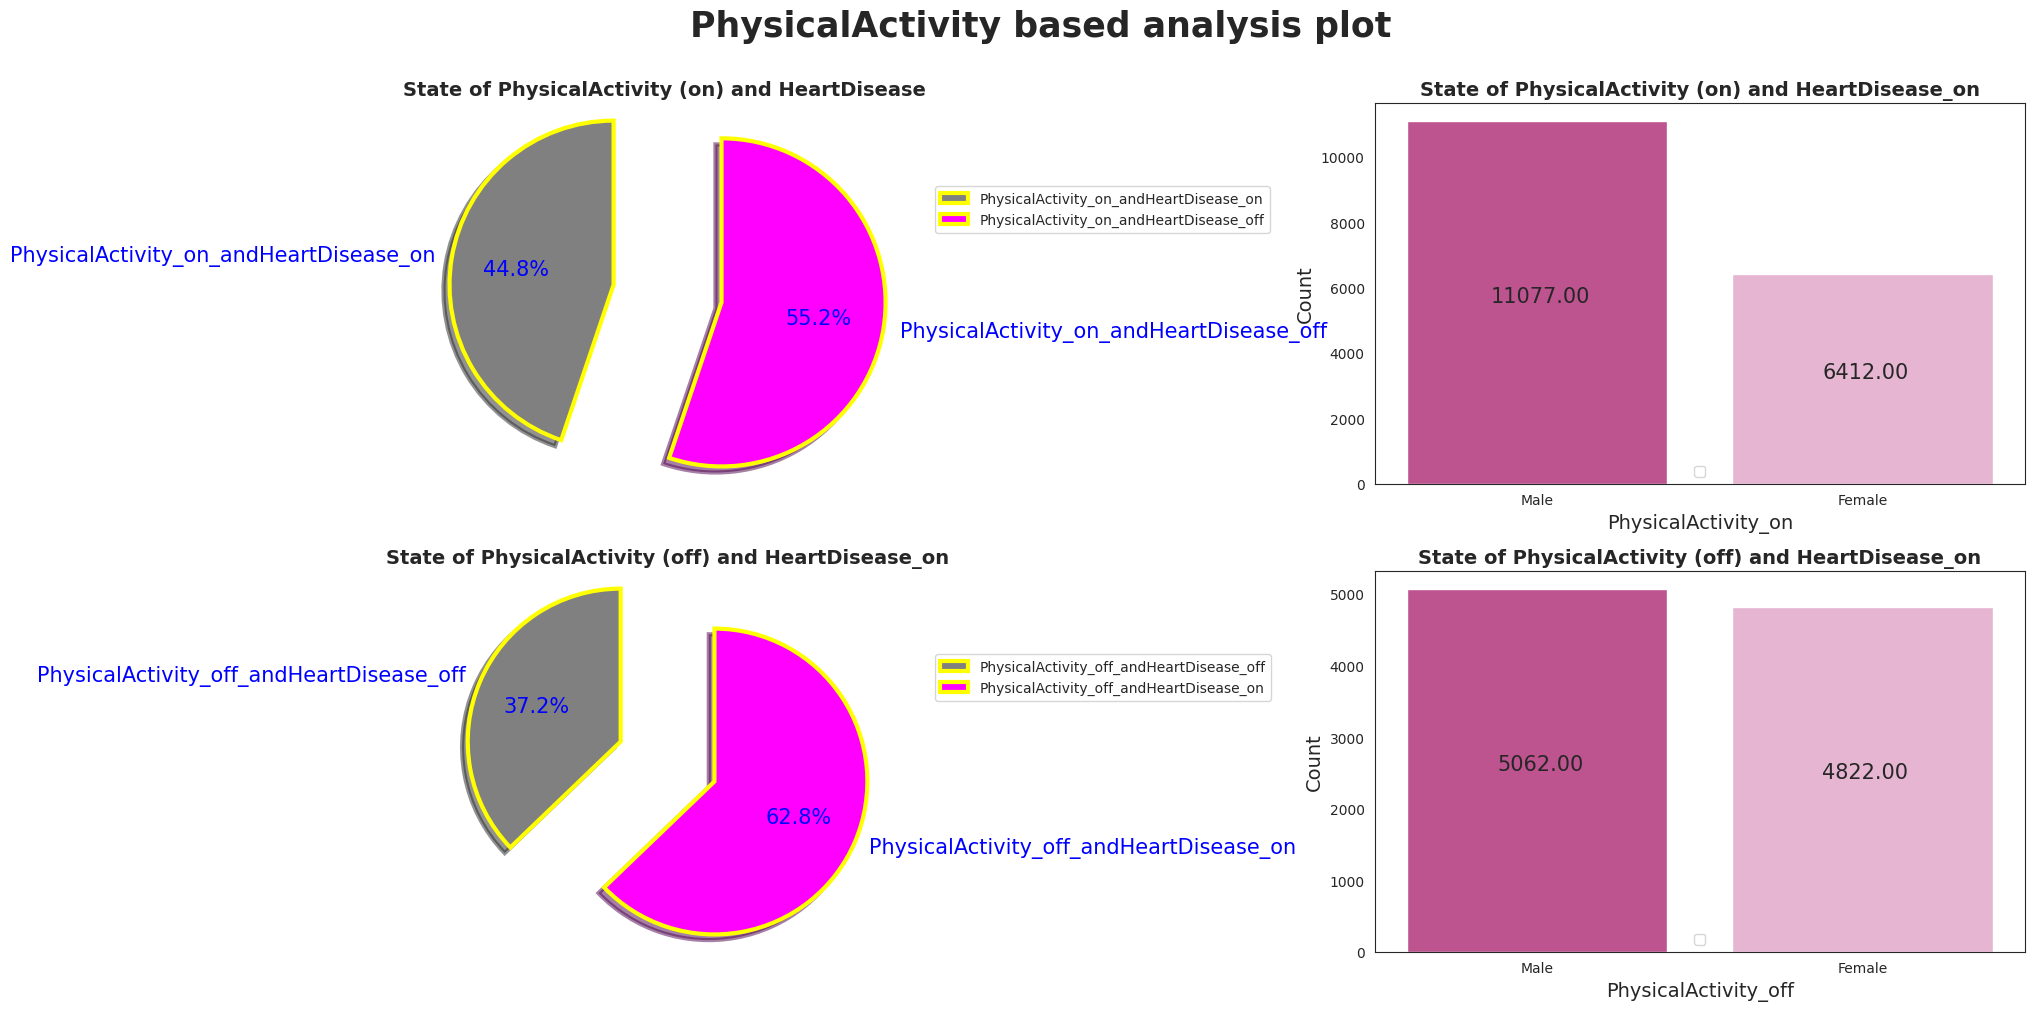

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("PhysicalActivity based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
PhysicalActivity_on_andHeartDisease_on=len(data[(data.PhysicalActivity==1)&(data['HeartDisease']==1)])
PhysicalActivity_on_andHeartDisease_off=len(data[(data.PhysicalActivity==1)&(data['HeartDisease']==0)])
y=['PhysicalActivity_on_andHeartDisease_on','PhysicalActivity_on_andHeartDisease_off']
x=[PhysicalActivity_on_andHeartDisease_on,PhysicalActivity_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of PhysicalActivity (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
PhysicalActivity_on_andHeartDisease_on_onmale=len(data[(data.PhysicalActivity==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
PhysicalActivity_on_andHeartDisease_on_onfemale=len(data[(data.PhysicalActivity==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"PhysicalActivity_on": ["Male","Female"],
         "Count": [PhysicalActivity_on_andHeartDisease_on_onmale,PhysicalActivity_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['PhysicalActivity_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="PhysicalActivity_on",y="Count", data=df,hue="PhysicalActivity_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("PhysicalActivity_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of PhysicalActivity (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
PhysicalActivity_off_andHeartDisease_off=len(data[(data.PhysicalActivity==0)&(data['HeartDisease']==0)])
PhysicalActivity_off_andHeartDisease_on=len(data[(data.PhysicalActivity==0)&(data['HeartDisease']==1)])
y=['PhysicalActivity_off_andHeartDisease_off','PhysicalActivity_off_andHeartDisease_on']
x=[PhysicalActivity_off_andHeartDisease_off,PhysicalActivity_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of PhysicalActivity (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
PhysicalActivity_off_andHeartDisease_on_onmale=len(data[(data.PhysicalActivity==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
PhysicalActivity_off_andHeartDisease_on_onfemale=len(data[(data.PhysicalActivity==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"PhysicalActivity_off": ["Male","Female"],
         "Count": [PhysicalActivity_off_andHeartDisease_on_onmale,PhysicalActivity_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['PhysicalActivity_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="PhysicalActivity_off",y="Count", data=df,hue="PhysicalActivity_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("PhysicalActivity_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of PhysicalActivity (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()

## Observations:
Regular exercise lowers the risk of developing heart disease. However, in individuals with heart disease but no history of exercise or physical activity, both men and women being almost equally experience this condition.  

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs SkinCancer"</p>

In [ ]:
data.SkinCancer.value_counts()

SkinCancer
0    47521
1     7225
Name: count, dtype: int64

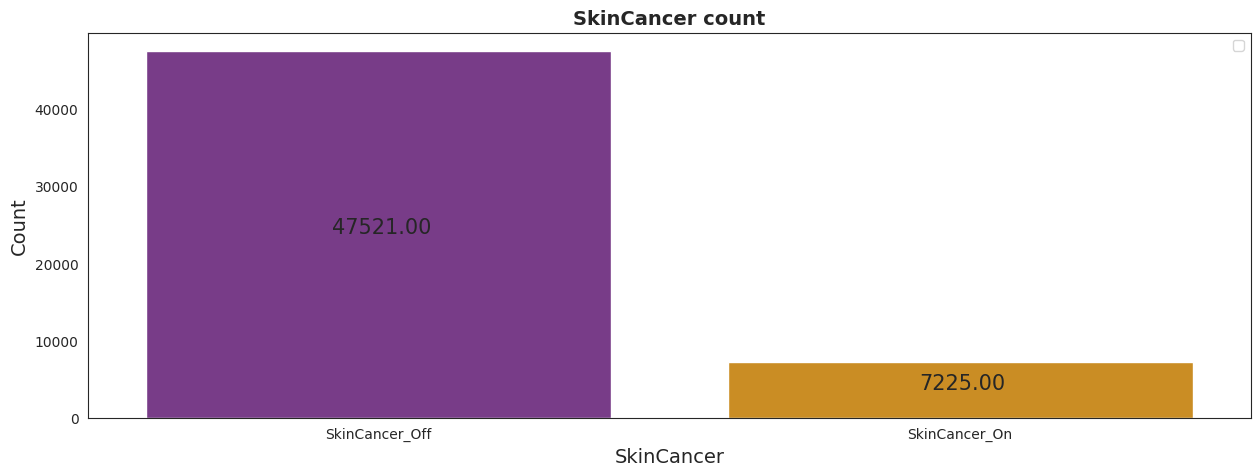

In [ ]:
data1 = {"SkinCancer":["SkinCancer_Off","SkinCancer_On"],
         "Count": list(dict(data.SkinCancer.value_counts()).values())}
df = pd.DataFrame(data1, columns=['SkinCancer', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="SkinCancer", y="Count", data=df,hue="SkinCancer",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("SkinCancer", size=14)

plt.ylabel("Count", size=14)

plt.title("SkinCancer count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

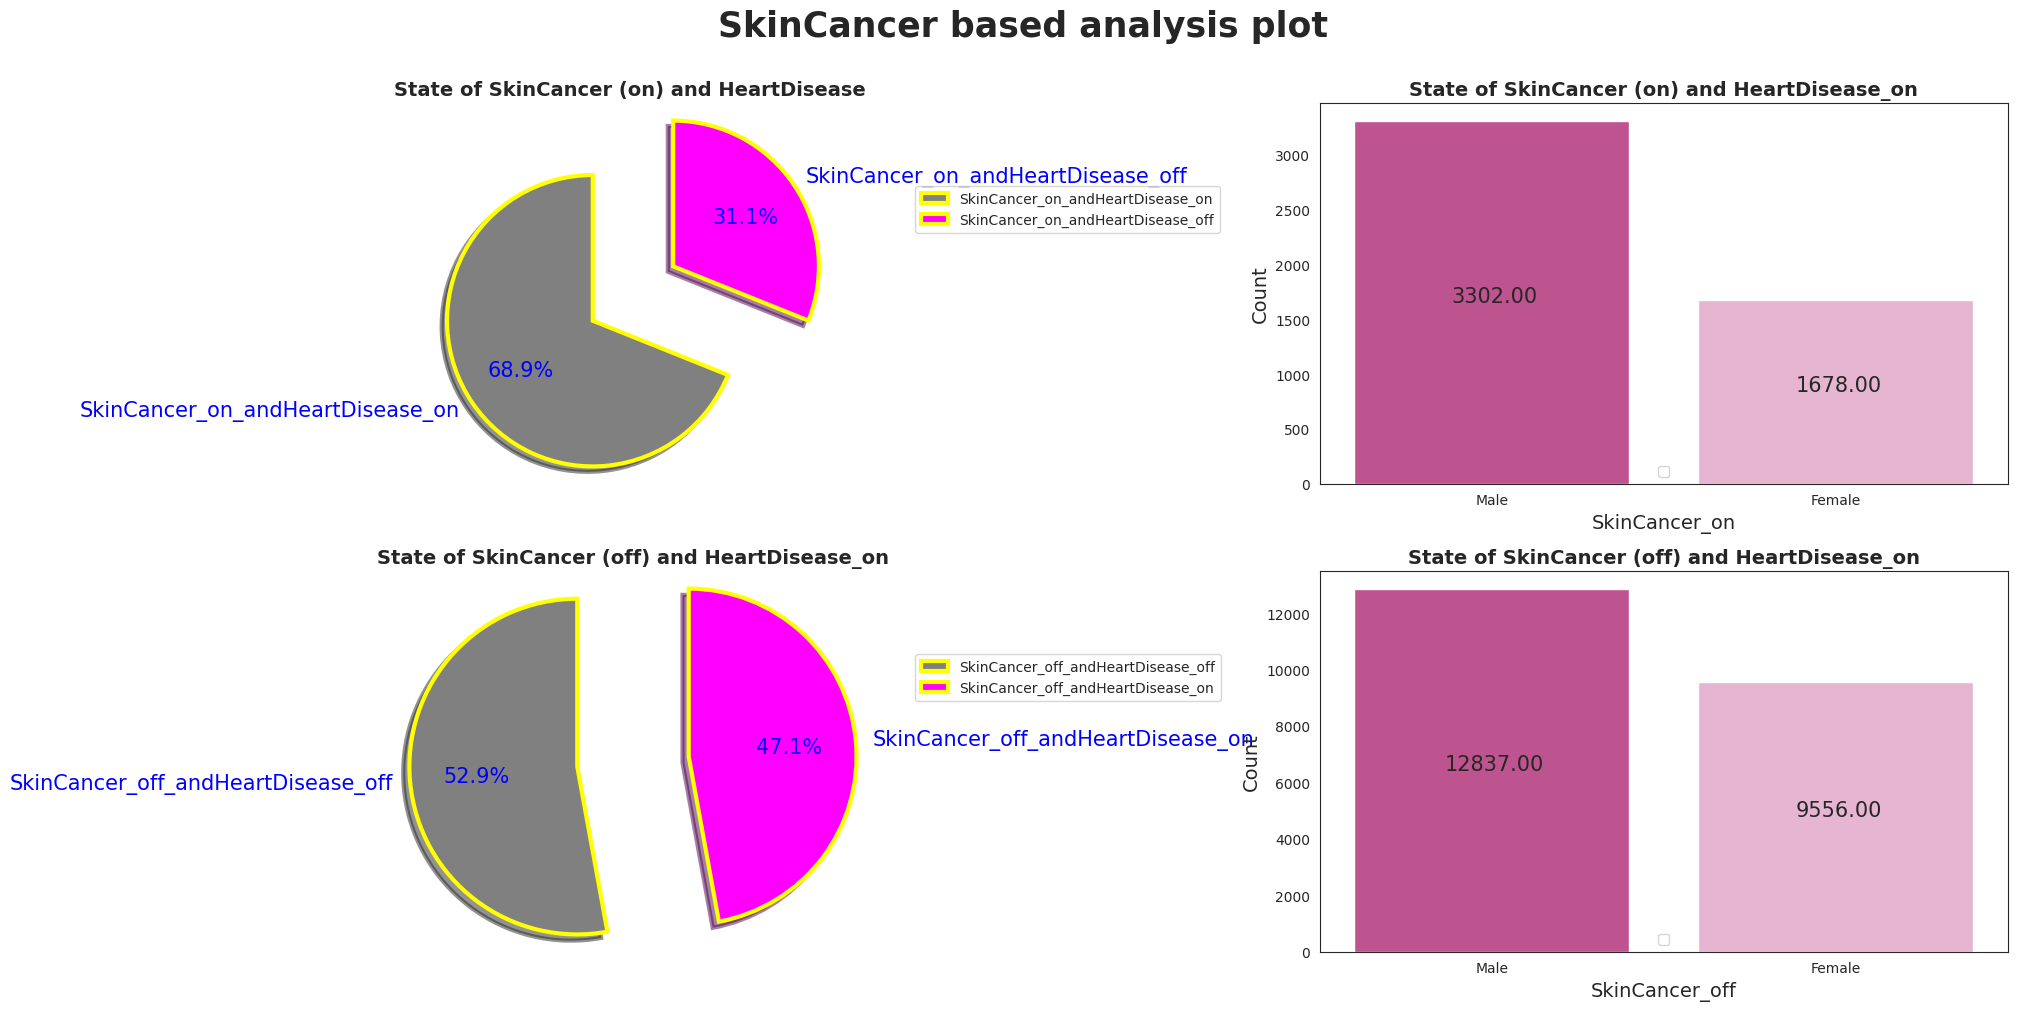

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("SkinCancer based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
SkinCancer_on_andHeartDisease_on=len(data[(data.SkinCancer==1)&(data['HeartDisease']==1)])
SkinCancer_on_andHeartDisease_off=len(data[(data.SkinCancer==1)&(data['HeartDisease']==0)])
y=['SkinCancer_on_andHeartDisease_on','SkinCancer_on_andHeartDisease_off']
x=[SkinCancer_on_andHeartDisease_on,SkinCancer_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of SkinCancer (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
SkinCancer_on_andHeartDisease_on_onmale=len(data[(data.SkinCancer==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
SkinCancer_on_andHeartDisease_on_onfemale=len(data[(data.SkinCancer==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"SkinCancer_on": ["Male","Female"],
         "Count": [SkinCancer_on_andHeartDisease_on_onmale,SkinCancer_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['SkinCancer_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="SkinCancer_on",y="Count", data=df,hue="SkinCancer_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("SkinCancer_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of SkinCancer (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
SkinCancer_off_andHeartDisease_off=len(data[(data.SkinCancer==0)&(data['HeartDisease']==0)])
SkinCancer_off_andHeartDisease_on=len(data[(data.SkinCancer==0)&(data['HeartDisease']==1)])
y=['SkinCancer_off_andHeartDisease_off','SkinCancer_off_andHeartDisease_on']
x=[SkinCancer_off_andHeartDisease_off,SkinCancer_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of SkinCancer (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
SkinCancer_off_andHeartDisease_on_onmale=len(data[(data.SkinCancer==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
SkinCancer_off_andHeartDisease_on_onfemale=len(data[(data.SkinCancer==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"SkinCancer_off": ["Male","Female"],
         "Count": [SkinCancer_off_andHeartDisease_on_onmale,SkinCancer_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['SkinCancer_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="SkinCancer_off",y="Count", data=df,hue="SkinCancer_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("SkinCancer_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of SkinCancer (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()

## Observations:
Skin cancer raises the risk of developing heart disease, with men having a higher likelihood of experiencing this condition.

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs Asthma"</p>

In [ ]:
data.Asthma.value_counts()

Asthma
0    46213
1     8533
Name: count, dtype: int64

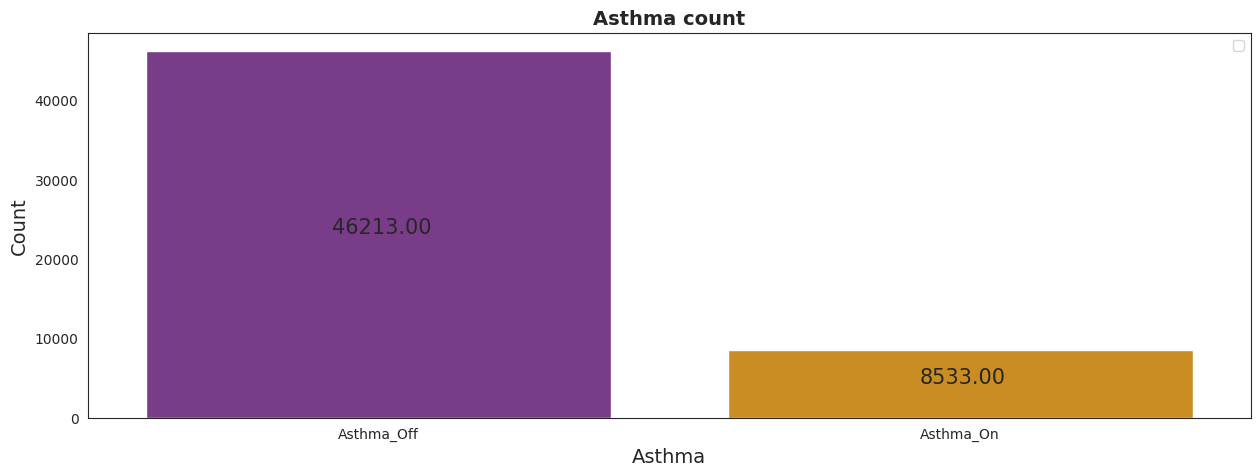

In [ ]:
data1 = {"Asthma":["Asthma_Off","Asthma_On"],
         "Count": list(dict(data.Asthma.value_counts()).values())}
df = pd.DataFrame(data1, columns=['Asthma', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="Asthma", y="Count", data=df,hue="Asthma",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Asthma", size=14)

plt.ylabel("Count", size=14)

plt.title("Asthma count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

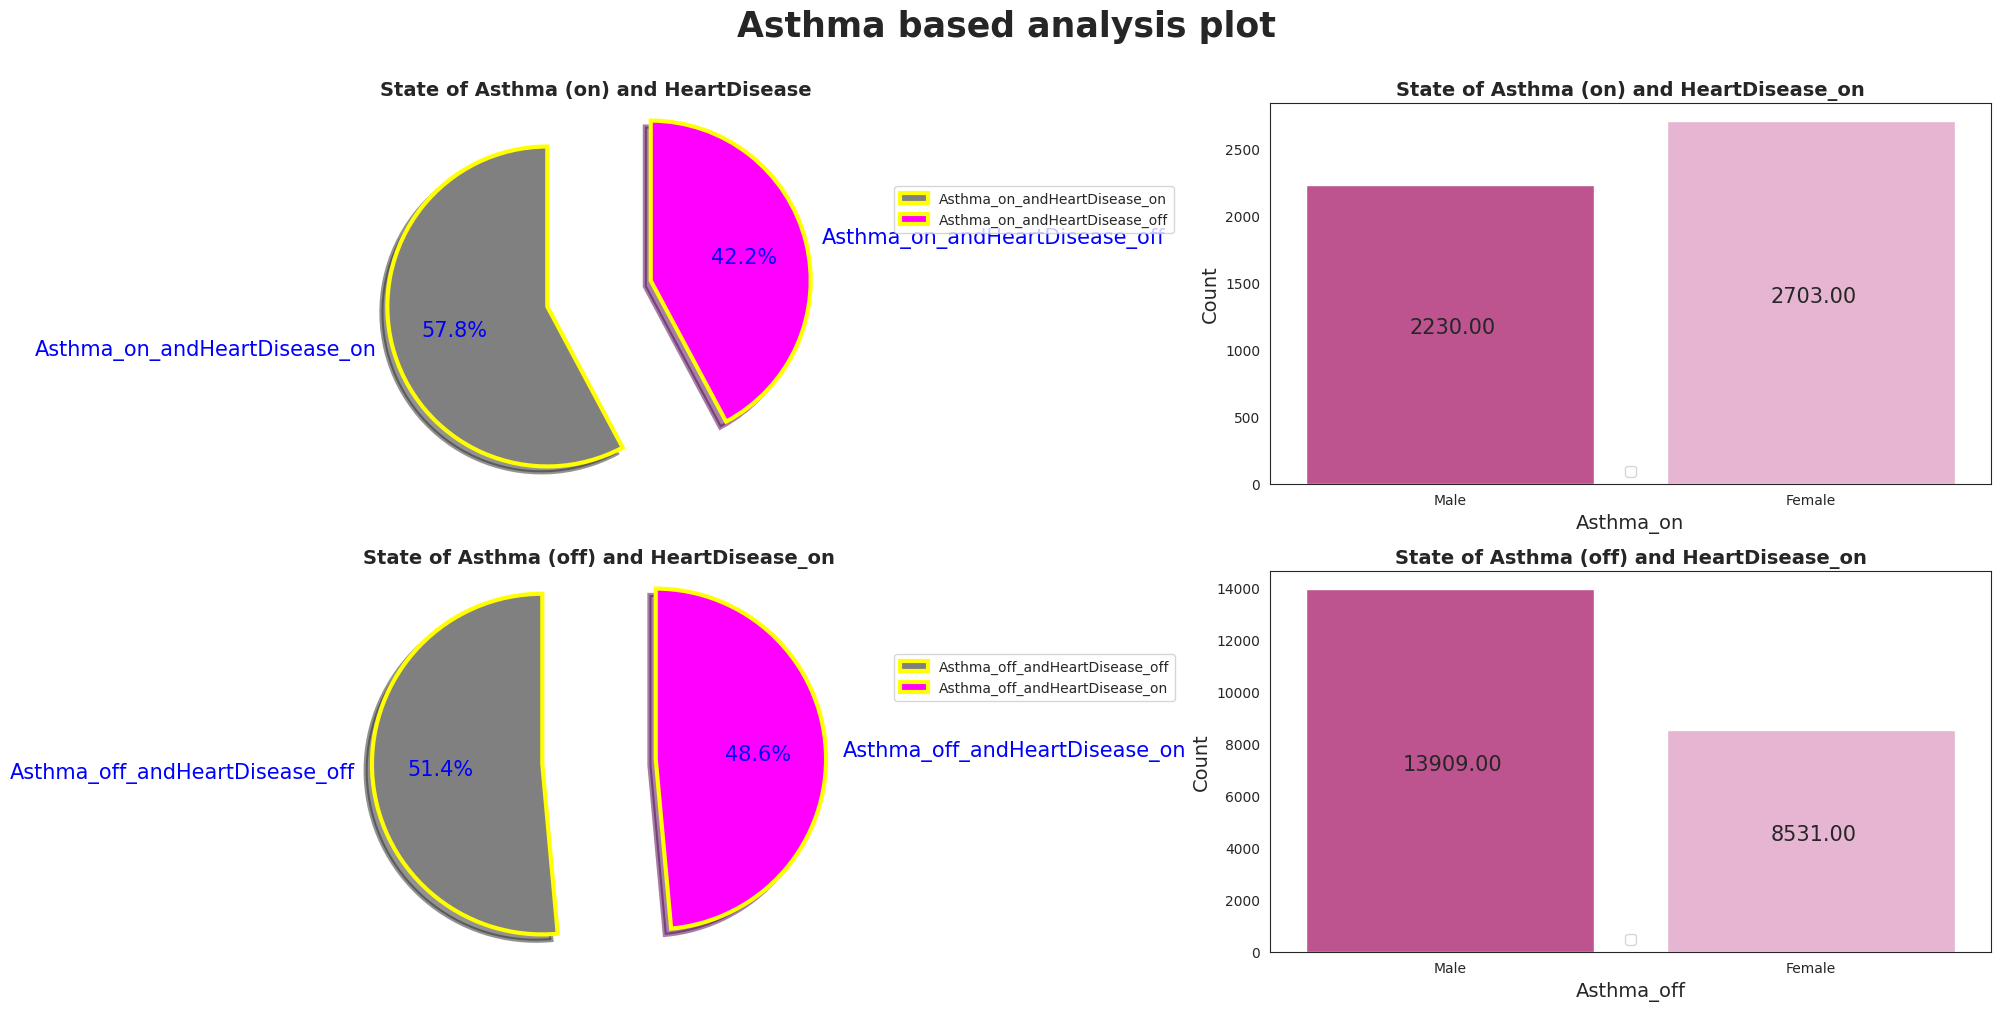

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("Asthma based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
Asthma_on_andHeartDisease_on=len(data[(data.Asthma==1)&(data['HeartDisease']==1)])
Asthma_on_andHeartDisease_off=len(data[(data.Asthma==1)&(data['HeartDisease']==0)])
y=['Asthma_on_andHeartDisease_on','Asthma_on_andHeartDisease_off']
x=[Asthma_on_andHeartDisease_on,Asthma_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Asthma (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
Asthma_on_andHeartDisease_on_onmale=len(data[(data.Asthma==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Asthma_on_andHeartDisease_on_onfemale=len(data[(data.Asthma==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Asthma_on": ["Male","Female"],
         "Count": [Asthma_on_andHeartDisease_on_onmale,Asthma_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Asthma_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Asthma_on",y="Count", data=df,hue="Asthma_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Asthma_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Asthma (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
Asthma_off_andHeartDisease_off=len(data[(data.Asthma==0)&(data['HeartDisease']==0)])
Asthma_off_andHeartDisease_on=len(data[(data.Asthma==0)&(data['HeartDisease']==1)])
y=['Asthma_off_andHeartDisease_off','Asthma_off_andHeartDisease_on']
x=[Asthma_off_andHeartDisease_off,Asthma_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of Asthma (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
Asthma_off_andHeartDisease_on_onmale=len(data[(data.Asthma==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
Asthma_off_andHeartDisease_on_onfemale=len(data[(data.Asthma==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"Asthma_off": ["Male","Female"],
         "Count": [Asthma_off_andHeartDisease_on_onmale,Asthma_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['Asthma_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="Asthma_off",y="Count", data=df,hue="Asthma_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("Asthma_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of Asthma (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()

## Observations:
Asthma increase the risk of developing heart disease, with women are more likely to experience this condition . However, in individuals with heart disease but no history of Asthma, men are more likely to experience this condition.  

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs AlcoholDrinking"</p>  

In [ ]:
data.AlcoholDrinking.value_counts()

AlcoholDrinking
0    51647
1     3099
Name: count, dtype: int64

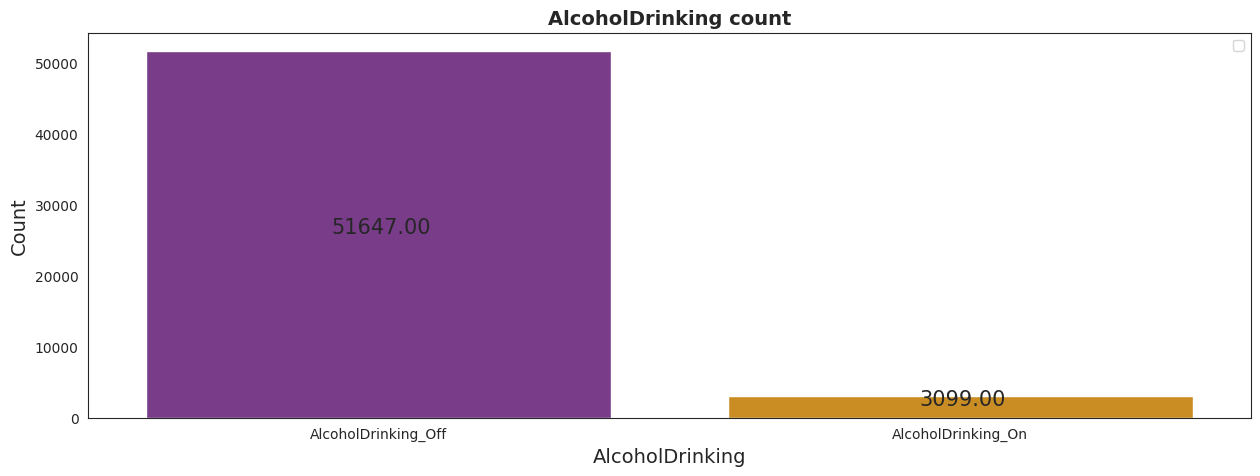

In [ ]:
data1 = {"AlcoholDrinking":["AlcoholDrinking_Off","AlcoholDrinking_On"],
         "Count": list(dict(data.AlcoholDrinking.value_counts()).values())}
df = pd.DataFrame(data1, columns=['AlcoholDrinking', 'Count'])
fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="AlcoholDrinking", y="Count", data=df,hue="AlcoholDrinking",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("AlcoholDrinking", size=14)

plt.ylabel("Count", size=14)

plt.title("AlcoholDrinking count",fontsize=14,fontweight="bold")
plt.legend(loc='best')
plt.show()

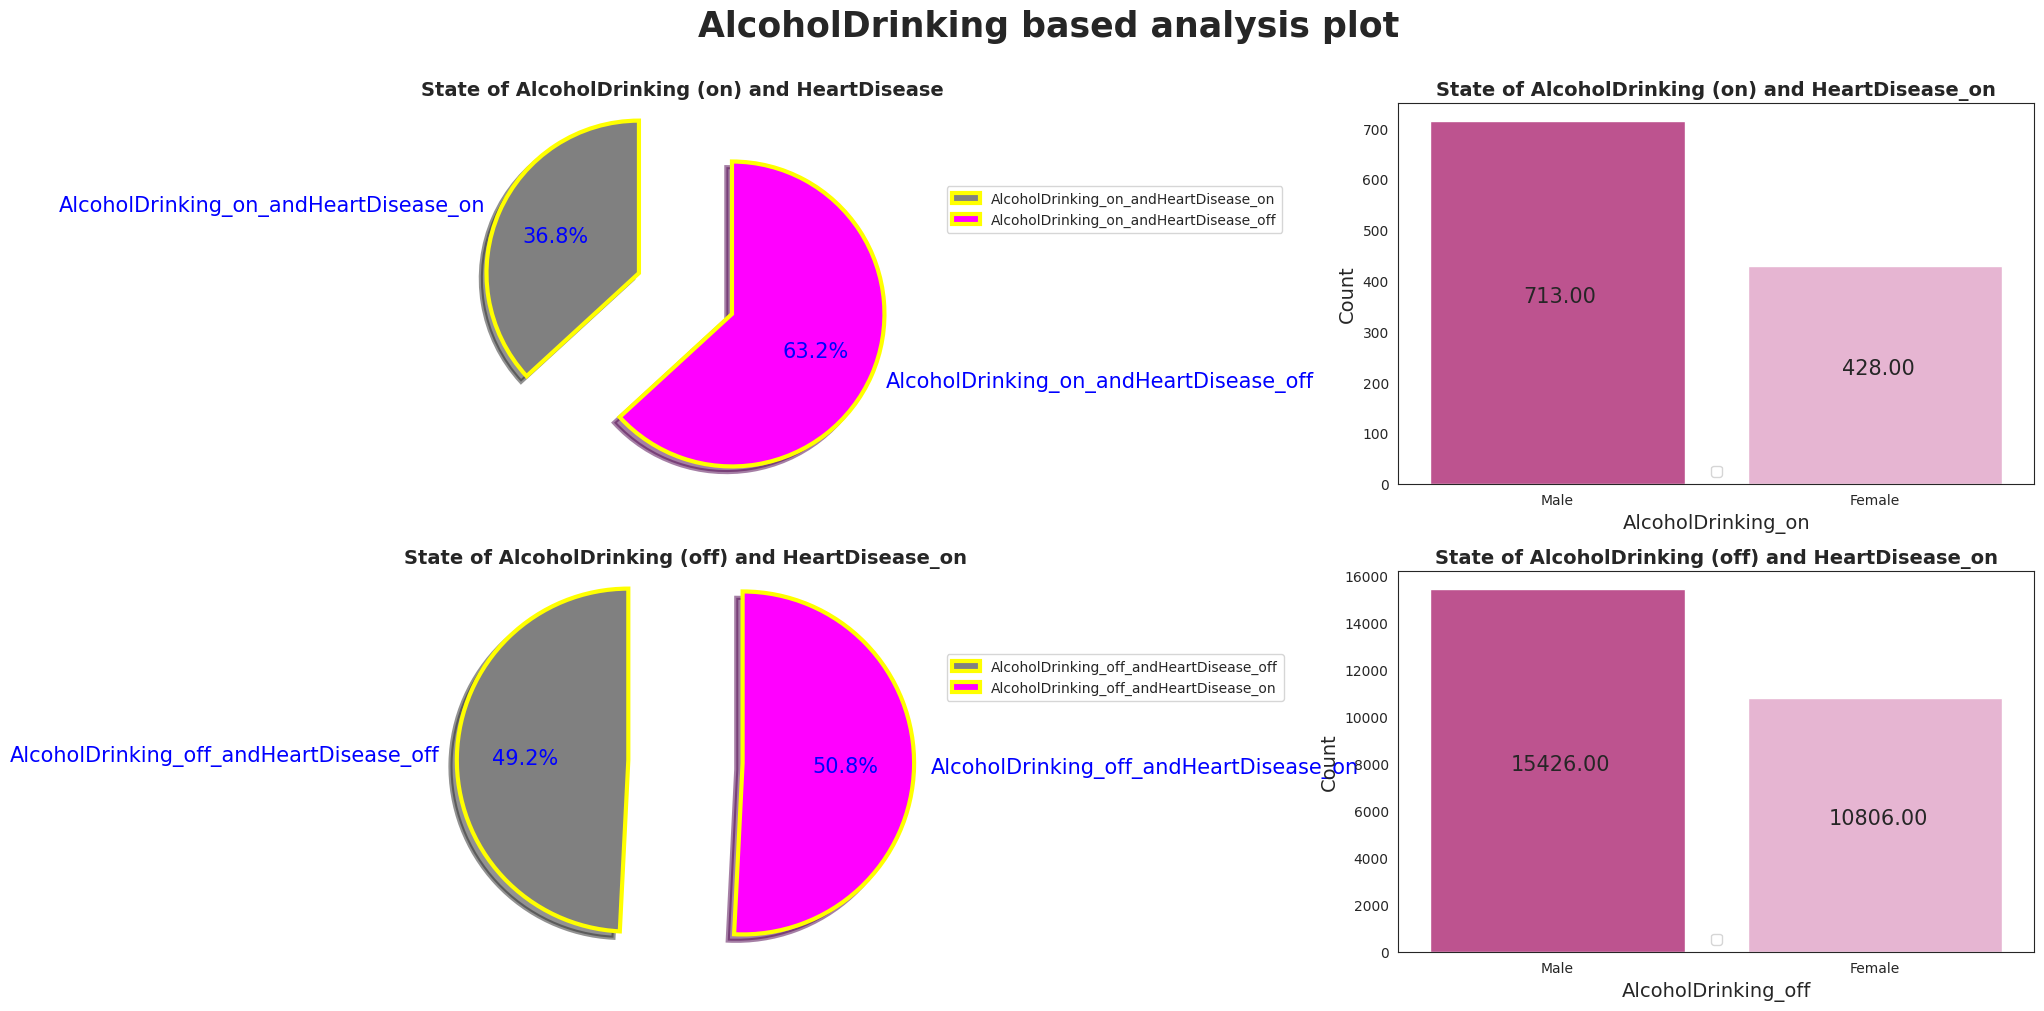

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.suptitle("AlcoholDrinking based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
AlcoholDrinking_on_andHeartDisease_on=len(data[(data.AlcoholDrinking==1)&(data['HeartDisease']==1)])
AlcoholDrinking_on_andHeartDisease_off=len(data[(data.AlcoholDrinking==1)&(data['HeartDisease']==0)])
y=['AlcoholDrinking_on_andHeartDisease_on','AlcoholDrinking_on_andHeartDisease_off']
x=[AlcoholDrinking_on_andHeartDisease_on,AlcoholDrinking_on_andHeartDisease_off]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of AlcoholDrinking (on) and HeartDisease ',fontsize=14,fontweight="bold")


plt.subplot(2,2,2)
AlcoholDrinking_on_andHeartDisease_on_onmale=len(data[(data.AlcoholDrinking==1)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
AlcoholDrinking_on_andHeartDisease_on_onfemale=len(data[(data.AlcoholDrinking==1)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"AlcoholDrinking_on": ["Male","Female"],
         "Count": [AlcoholDrinking_on_andHeartDisease_on_onmale,AlcoholDrinking_on_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['AlcoholDrinking_on', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="AlcoholDrinking_on",y="Count", data=df,hue="AlcoholDrinking_on")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("AlcoholDrinking_on", size=14)

plt.ylabel("Count", size=14)

plt.title('State of AlcoholDrinking (on) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.subplot(2,2,3)
AlcoholDrinking_off_andHeartDisease_off=len(data[(data.AlcoholDrinking==0)&(data['HeartDisease']==0)])
AlcoholDrinking_off_andHeartDisease_on=len(data[(data.AlcoholDrinking==0)&(data['HeartDisease']==1)])
y=['AlcoholDrinking_off_andHeartDisease_off','AlcoholDrinking_off_andHeartDisease_on']
x=[AlcoholDrinking_off_andHeartDisease_off,AlcoholDrinking_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=0.75)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8))
plt.title('State of AlcoholDrinking (off) and HeartDisease_on',fontsize=14,fontweight="bold")


plt.subplot(2,2,4)
AlcoholDrinking_off_andHeartDisease_on_onmale=len(data[(data.AlcoholDrinking==0)&(data['HeartDisease']==1)
                                                                    &(data['Sex']==1)])
AlcoholDrinking_off_andHeartDisease_on_onfemale=len(data[(data.AlcoholDrinking==0)&(data['HeartDisease']==1)
                                                                   &(data['Sex']==0)])



data1 = {"AlcoholDrinking_off": ["Male","Female"],
         "Count": [AlcoholDrinking_off_andHeartDisease_on_onmale,AlcoholDrinking_off_andHeartDisease_on_onfemale]}
df = pd.DataFrame(data1, columns=['AlcoholDrinking_off', 'Count'])
#fig=plt.figure(figsize=(25,10))
plots = sns.barplot(x="AlcoholDrinking_off",y="Count", data=df,hue="AlcoholDrinking_off")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("AlcoholDrinking_off", size=14)

plt.ylabel("Count", size=14)

plt.title('State of AlcoholDrinking (off) and HeartDisease_on',fontsize=14,fontweight="bold")
plt.legend(loc='lower center')


plt.tight_layout()
plt.show()

## Observations:
The moderate consumption of alcohol can lower the risk of developing heart disease, with  men are more likely to experience CVD.

There is some evidence to suggest that moderate alcohol consumption may have a protective effect against heart disease. Studies have shown that moderate drinking, which is defined as up to one drink per day for women and up to two drinks per day for men, can help raise levels of "good" HDL cholesterol, lower levels of "bad" LDL cholesterol, and reduce the formation of blood clots, all of which are risk factors for heart disease. However, excessive alcohol consumption can have the opposite effect and increase the risk of heart disease and other health problems, including liver disease, cancer, and mental health issues.

Overall, it's important to remember that alcohol consumption should be approached with caution and in moderation. Drinking in excess can have serious consequences for one's health, including an increased risk of heart disease. People with a history of heart disease or other health conditions should consult their doctor before consuming alcohol.  

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs PhysicalHealth"</p>  

In [ ]:
data.PhysicalHealth.value_counts()

PhysicalHealth
0.0     34133
30.0     6001
2.0      2494
3.0      1589
5.0      1558
1.0      1508
15.0     1323
10.0     1296
4.0       904
20.0      892
7.0       865
14.0      562
25.0      336
6.0       276
8.0       189
12.0      152
21.0      141
28.0      137
29.0       75
18.0       46
9.0        43
27.0       41
16.0       33
17.0       27
24.0       24
22.0       22
13.0       19
26.0       18
11.0       17
23.0       14
19.0       11
Name: count, dtype: int64

In [ ]:
x1=list(dict(data.PhysicalHealth.value_counts()).keys())
x=[]
for i in x1:
    x.append(int(i))
y=list(dict(data.PhysicalHealth.value_counts()).values())

data1 = {"PhysicalHealth":x,
         "Count": y}
df = pd.DataFrame(data1, columns=['PhysicalHealth', 'Count'])
if data['Sex'].duplicated().any():
    print("Duplicate values found in the 'Sex' column")
else:
    # If no duplicates, assign the 'Sex' column to the DataFrame
    df["Sex"] = data['Sex']
#df["Sex"]=data.Sex
df1=df.sort_values("PhysicalHealth")
df2=df1.drop(0)

Duplicate values found in the 'Sex' column


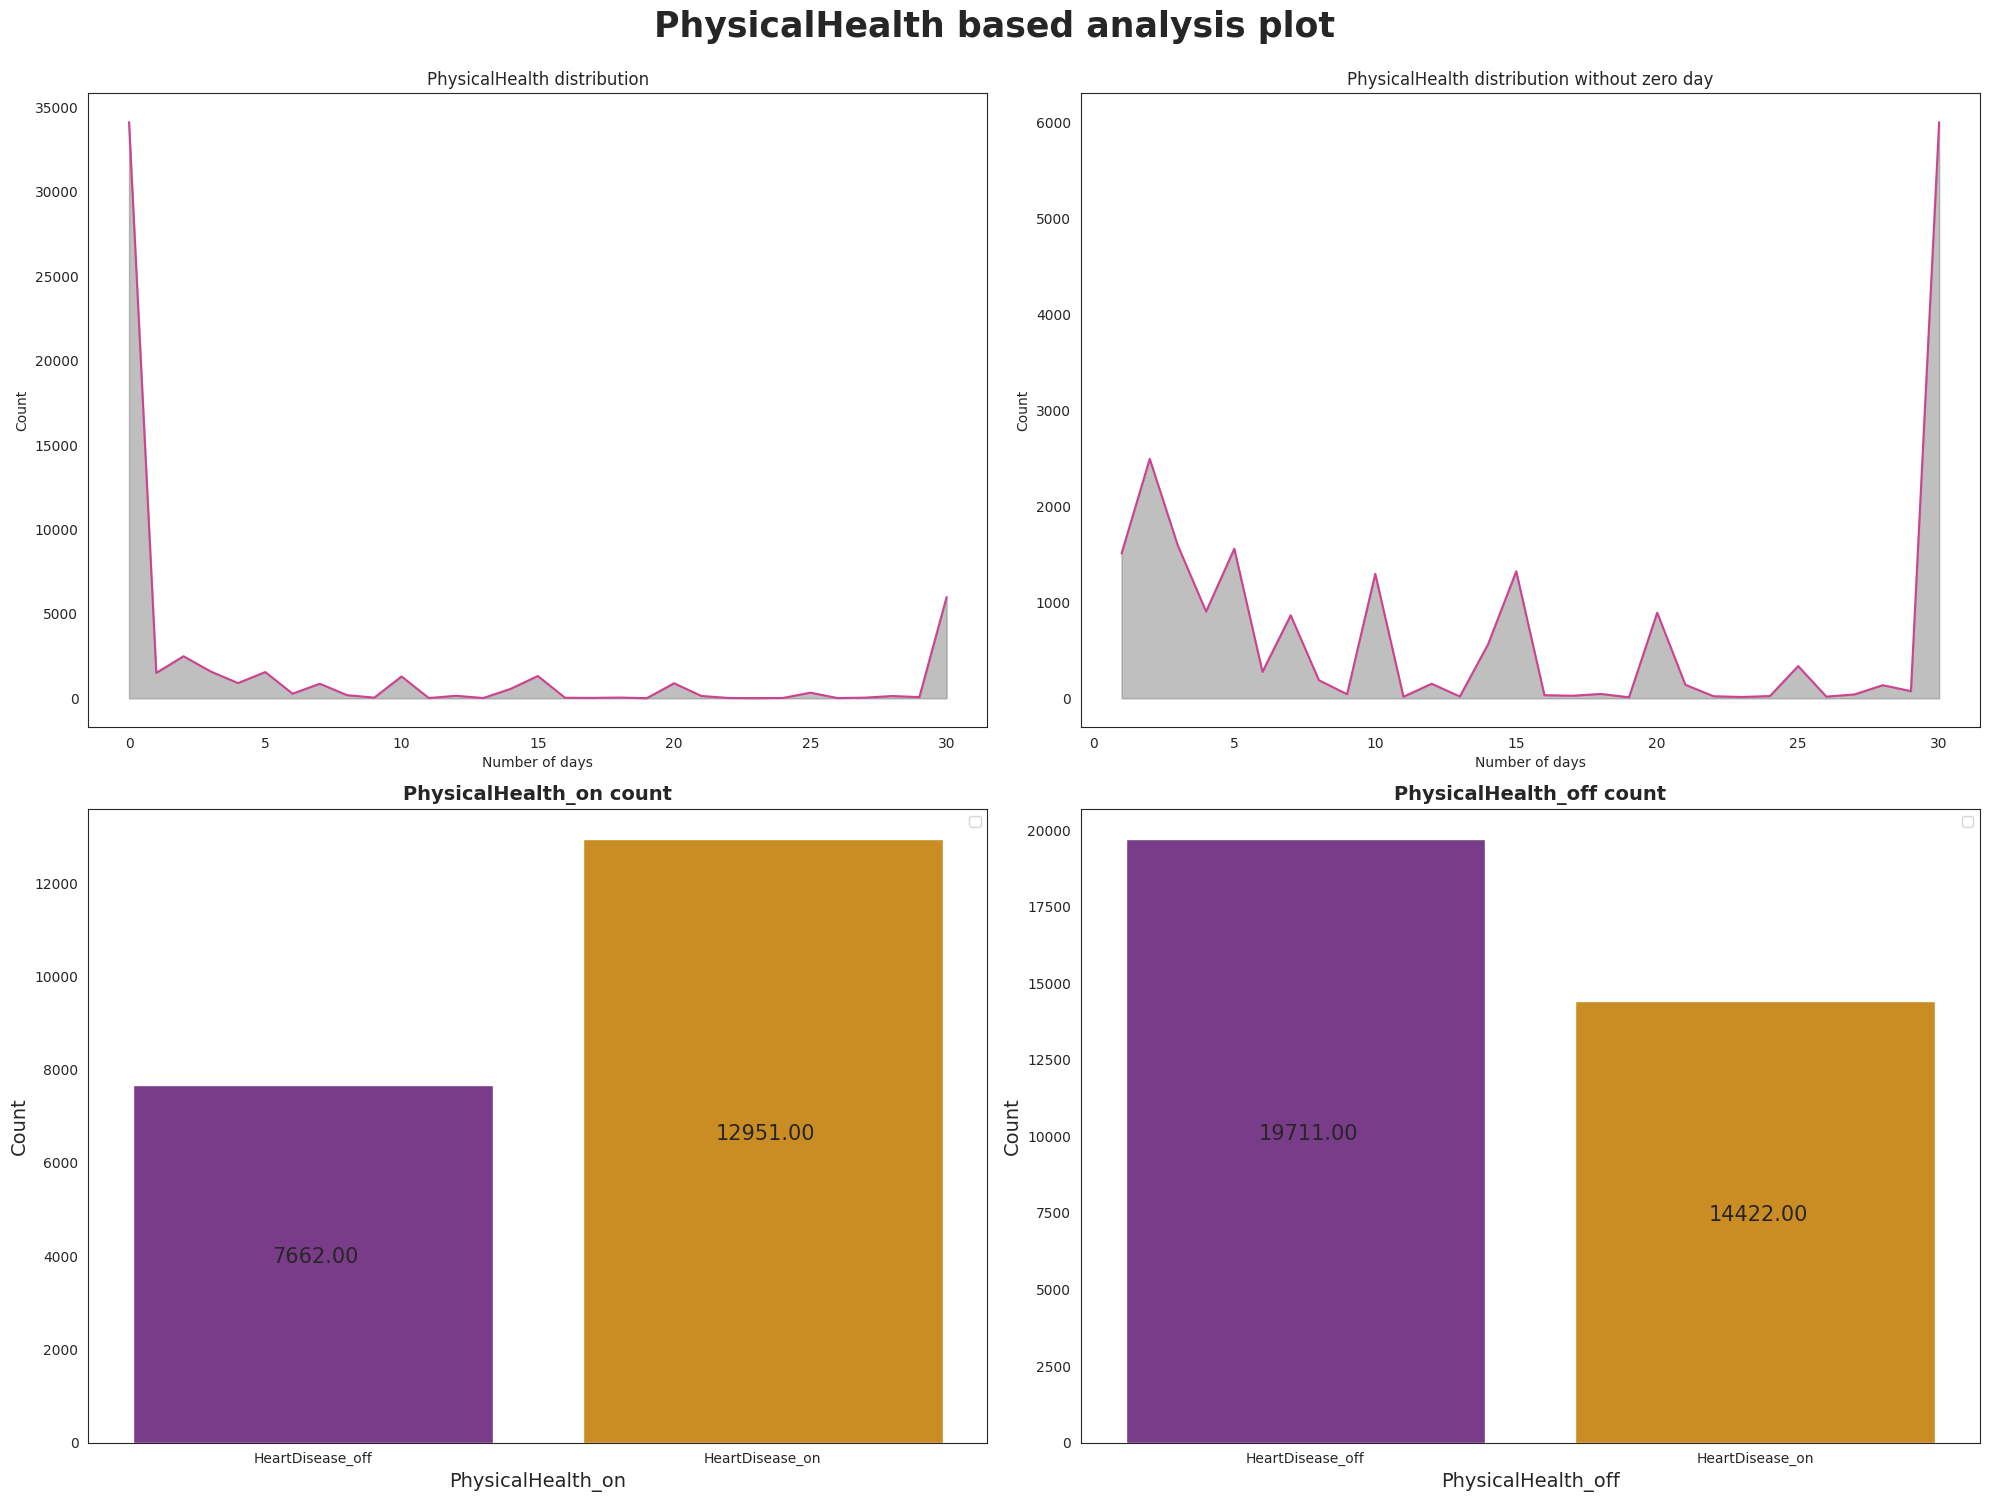

In [ ]:
fig=plt.figure(figsize=(20,15))
plt.suptitle("PhysicalHealth based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
plt.plot(df1.PhysicalHealth,df1["Count"])
plt.fill_between(df1.PhysicalHealth,df1["Count"],color="grey",alpha=0.5)
plt.title("PhysicalHealth distribution")
plt.xlabel("Number of days")
plt.ylabel("Count")



plt.subplot(2,2,2)
#fig=plt.figure(figsize=(10,5))
plt.plot(df2.PhysicalHealth,df2["Count"])
plt.fill_between(df2.PhysicalHealth,df2["Count"],color="grey",alpha=0.5)
plt.title("PhysicalHealth distribution without zero day")
plt.xlabel("Number of days")
plt.ylabel("Count")


plt.subplot(2,2,4)
PhysicalHealth_off_andHeartDisease_off=len(data[(data.PhysicalHealth==0)&(data['HeartDisease']==0)])
PhysicalHealth_off_andHeartDisease_on=len(data[(data.PhysicalHealth==0)&(data['HeartDisease']==1)])

data1 = {"PhysicalHealth_off":["HeartDisease_off","HeartDisease_on"],
         "Count": [PhysicalHealth_off_andHeartDisease_off,PhysicalHealth_off_andHeartDisease_on]}
df = pd.DataFrame(data1, columns=['PhysicalHealth_off', 'Count'])
#fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="PhysicalHealth_off", y="Count", data=df,hue="PhysicalHealth_off",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("PhysicalHealth_off", size=14)

plt.ylabel("Count", size=14)

plt.title("PhysicalHealth_off count",fontsize=14,fontweight="bold")
plt.legend(loc='best')

plt.subplot(2,2,3)
PhysicalHealth_on_andHeartDisease_off=len(data[(data.PhysicalHealth>0)&(data['HeartDisease']==0)])
PhysicalHealth_on_andHeartDisease_on=len(data[(data.PhysicalHealth>0)&(data['HeartDisease']==1)])



data1 = {"PhysicalHealth_on":["HeartDisease_off","HeartDisease_on"],
         "Count": [PhysicalHealth_on_andHeartDisease_off,PhysicalHealth_on_andHeartDisease_on]}
df = pd.DataFrame(data1, columns=['PhysicalHealth_on', 'Count'])
#fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="PhysicalHealth_on", y="Count", data=df,hue="PhysicalHealth_on",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("PhysicalHealth_on", size=14)

plt.ylabel("Count", size=14)

plt.title("PhysicalHealth_on count",fontsize=14,fontweight="bold")
plt.legend(loc='best')

plt.tight_layout()
plt.show()


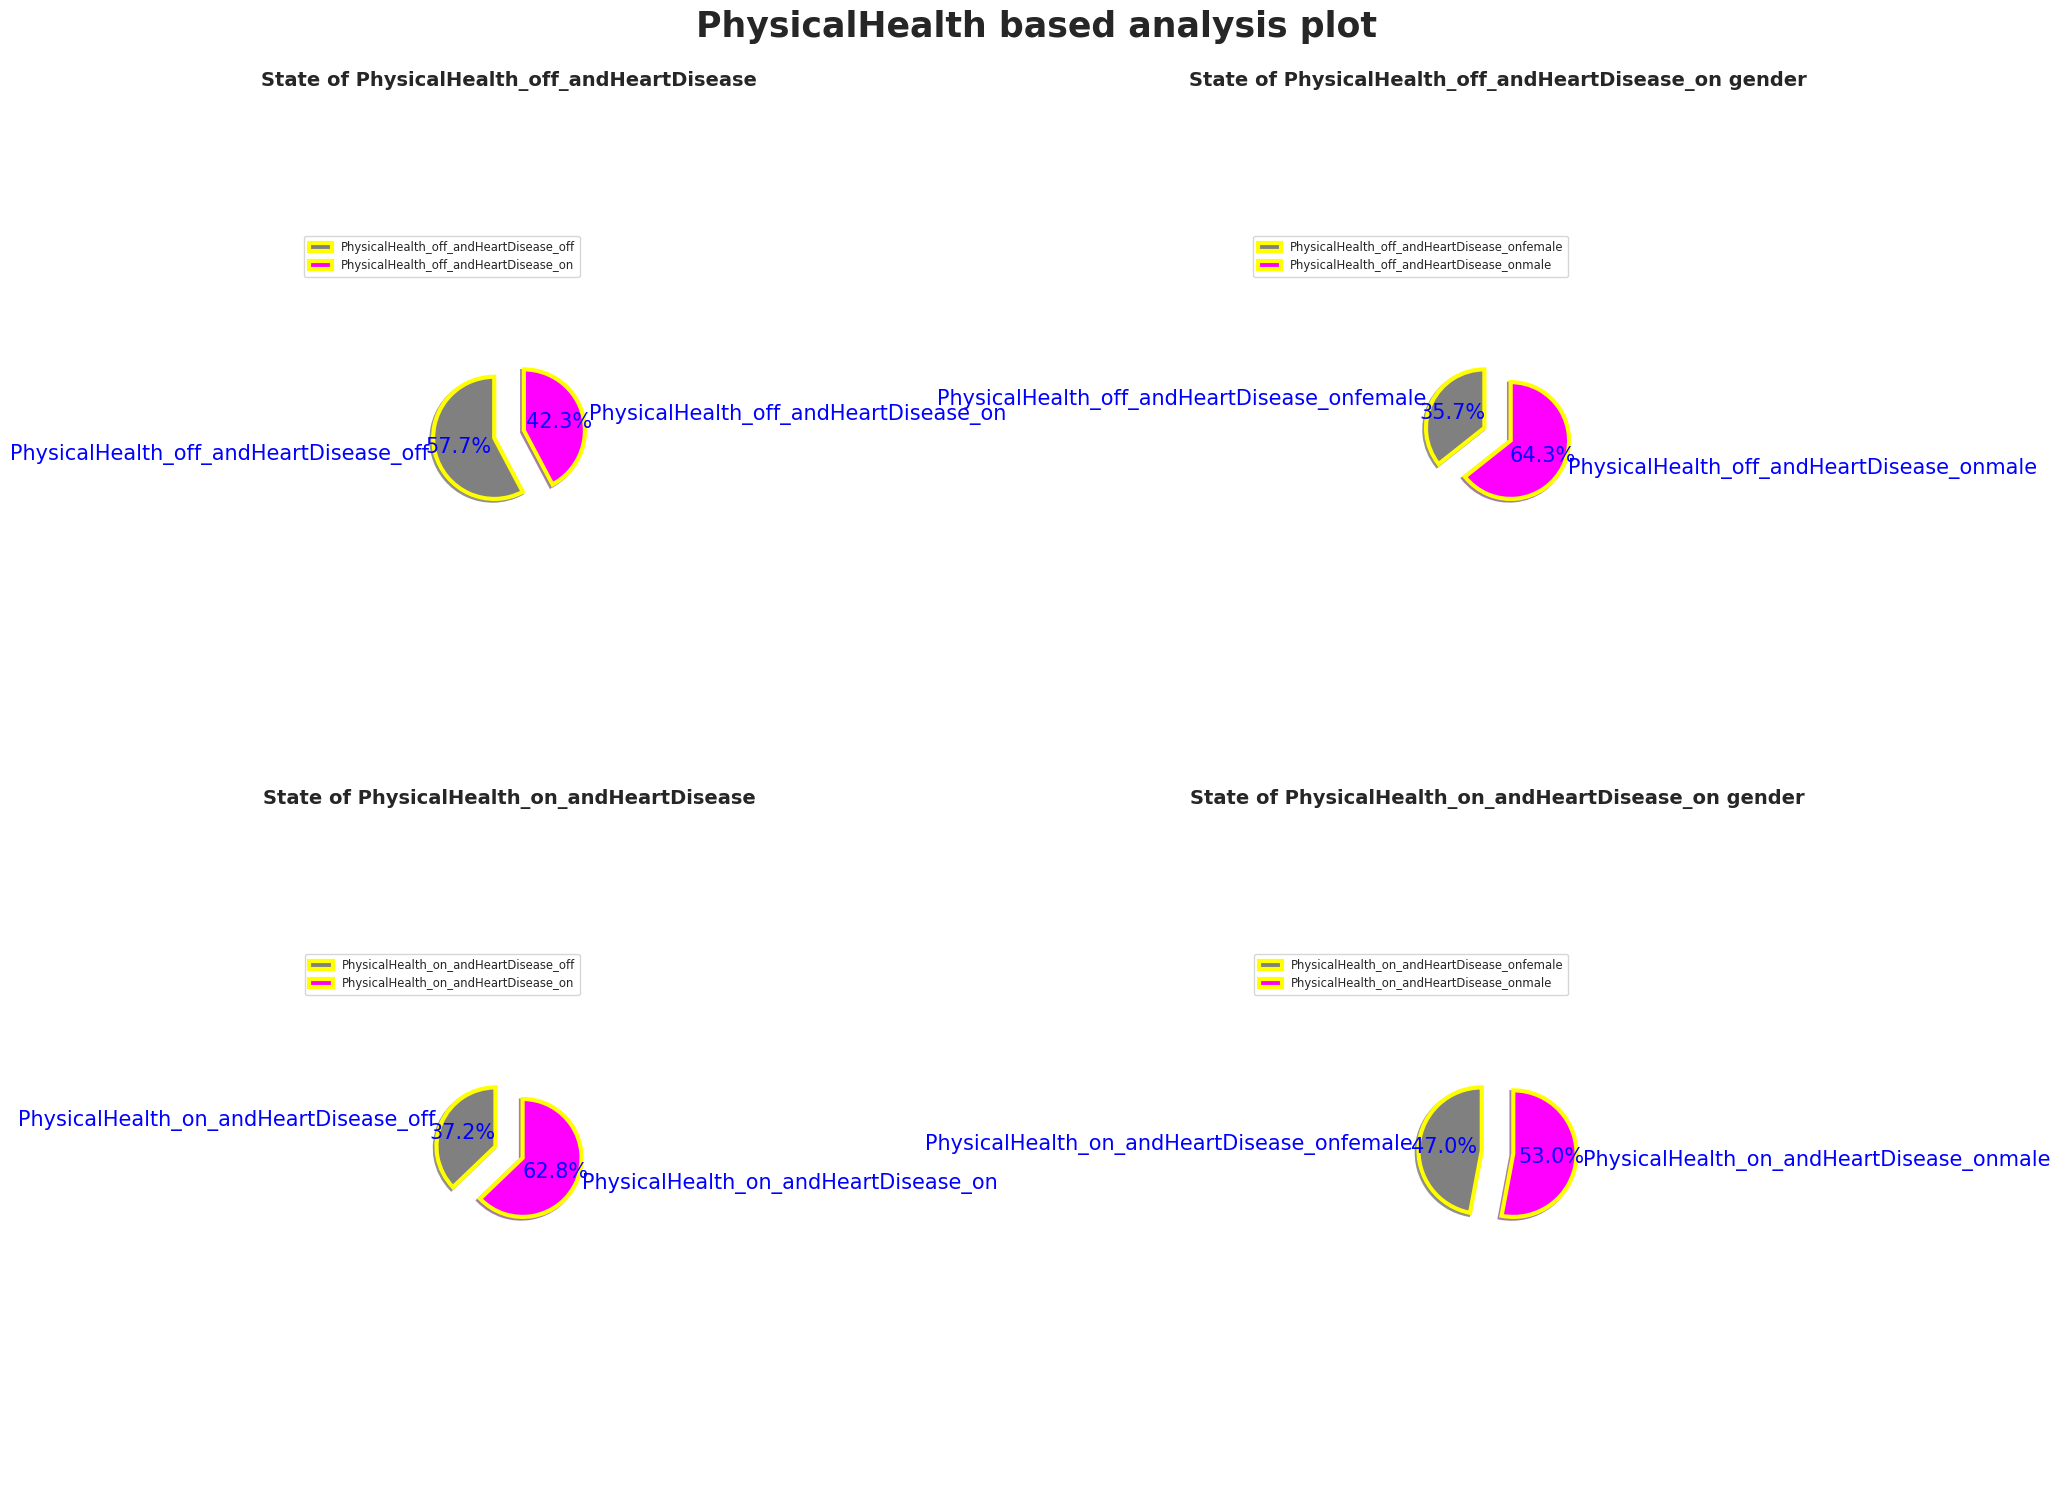

In [ ]:
fig=plt.figure(figsize=(20,15))
plt.suptitle("PhysicalHealth based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")





plt.subplot(2,2,1)
PhysicalHealth_off_andHeartDisease_off=len(data[(data.PhysicalHealth==0)&(data['HeartDisease']==0)])
PhysicalHealth_off_andHeartDisease_on=len(data[(data.PhysicalHealth==0)&(data['HeartDisease']==1)])


y=['PhysicalHealth_off_andHeartDisease_off','PhysicalHealth_off_andHeartDisease_on']
x=[PhysicalHealth_off_andHeartDisease_off,PhysicalHealth_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of PhysicalHealth_off_andHeartDisease',fontsize=14,fontweight="bold")
#plt.show()




plt.subplot(2,2,2)
PhysicalHealth_off_andHeartDisease_onfemale=len(data[(data.PhysicalHealth==0)&(data['HeartDisease']==1)
                                               &(data['Sex']==0)])
PhysicalHealth_off_andHeartDisease_onmale=len(data[(data.PhysicalHealth==0)&(data['HeartDisease']==1)
                                               &(data['Sex']==1)])

y=['PhysicalHealth_off_andHeartDisease_onfemale','PhysicalHealth_off_andHeartDisease_onmale']
x=[PhysicalHealth_off_andHeartDisease_onfemale,PhysicalHealth_off_andHeartDisease_onmale]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of PhysicalHealth_off_andHeartDisease_on gender',fontsize=14,fontweight="bold")
#plt.show()


plt.subplot(2,2,3)
PhysicalHealth_on_andHeartDisease_off=len(data[(data.PhysicalHealth>0)&(data['HeartDisease']==0)])
PhysicalHealth_on_andHeartDisease_on=len(data[(data.PhysicalHealth>0)&(data['HeartDisease']==1)])

y=['PhysicalHealth_on_andHeartDisease_off','PhysicalHealth_on_andHeartDisease_on']
x=[PhysicalHealth_on_andHeartDisease_off,PhysicalHealth_on_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of PhysicalHealth_on_andHeartDisease',fontsize=14,fontweight="bold")



plt.subplot(2,2,4)
PhysicalHealth_on_andHeartDisease_onfemale=len(data[(data.PhysicalHealth>0)&(data['HeartDisease']==1)
                                               &(data['Sex']==0)])
PhysicalHealth_on_andHeartDisease_onmale=len(data[(data.PhysicalHealth>0)&(data['HeartDisease']==1)
                                               &(data['Sex']==1)])

y=['PhysicalHealth_on_andHeartDisease_onfemale','PhysicalHealth_on_andHeartDisease_onmale']
x=[PhysicalHealth_on_andHeartDisease_onfemale,PhysicalHealth_on_andHeartDisease_onmale]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of PhysicalHealth_on_andHeartDisease_on gender',fontsize=14,fontweight="bold")
#plt.show()



#fig.legend(bbox_to_anchor=(0.9,1.3))
plt.tight_layout()
plt.show()

## Observations:
Individuals who experience physical issues within a 30-day period are at a higher risk of developing heart disease compared to those without any physical issues. Among individuals without physical issues, men are more susceptible to heart disease than women. However, among individuals with physical issues, the incidence of heart disease is almost equal between men (53%) and women (47%).

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs MentalHealth"</p>

In [ ]:
data.MentalHealth.value_counts()

MentalHealth
0.0     35655
30.0     3712
2.0      2480
5.0      2160
15.0     1760
10.0     1692
3.0      1583
1.0      1415
20.0      951
7.0       846
4.0       807
25.0      387
14.0      295
6.0       253
8.0       176
12.0      126
28.0       99
21.0       67
29.0       65
9.0        36
18.0       33
16.0       28
27.0       18
17.0       18
13.0       17
22.0       16
24.0       14
11.0       14
26.0       11
23.0        9
19.0        3
Name: count, dtype: int64

In [ ]:
x1=list(dict(data.MentalHealth.value_counts()).keys())
x=[]
for i in x1:
    x.append(int(i))
y=list(dict(data.MentalHealth.value_counts()).values())

data1 = {"MentalHealth":x,
         "Count": y}
df = pd.DataFrame(data1, columns=['MentalHealth', 'Count'])
if data['Sex'].duplicated().any():
    print("Duplicate values found in the 'Sex' column")
else:
    # If no duplicates, assign the 'Sex' column to the DataFrame
    df["Sex"] = data['Sex']
#df["Sex"]=data.Sex
df1=df.sort_values("MentalHealth")
df2=df1.drop(0)

Duplicate values found in the 'Sex' column


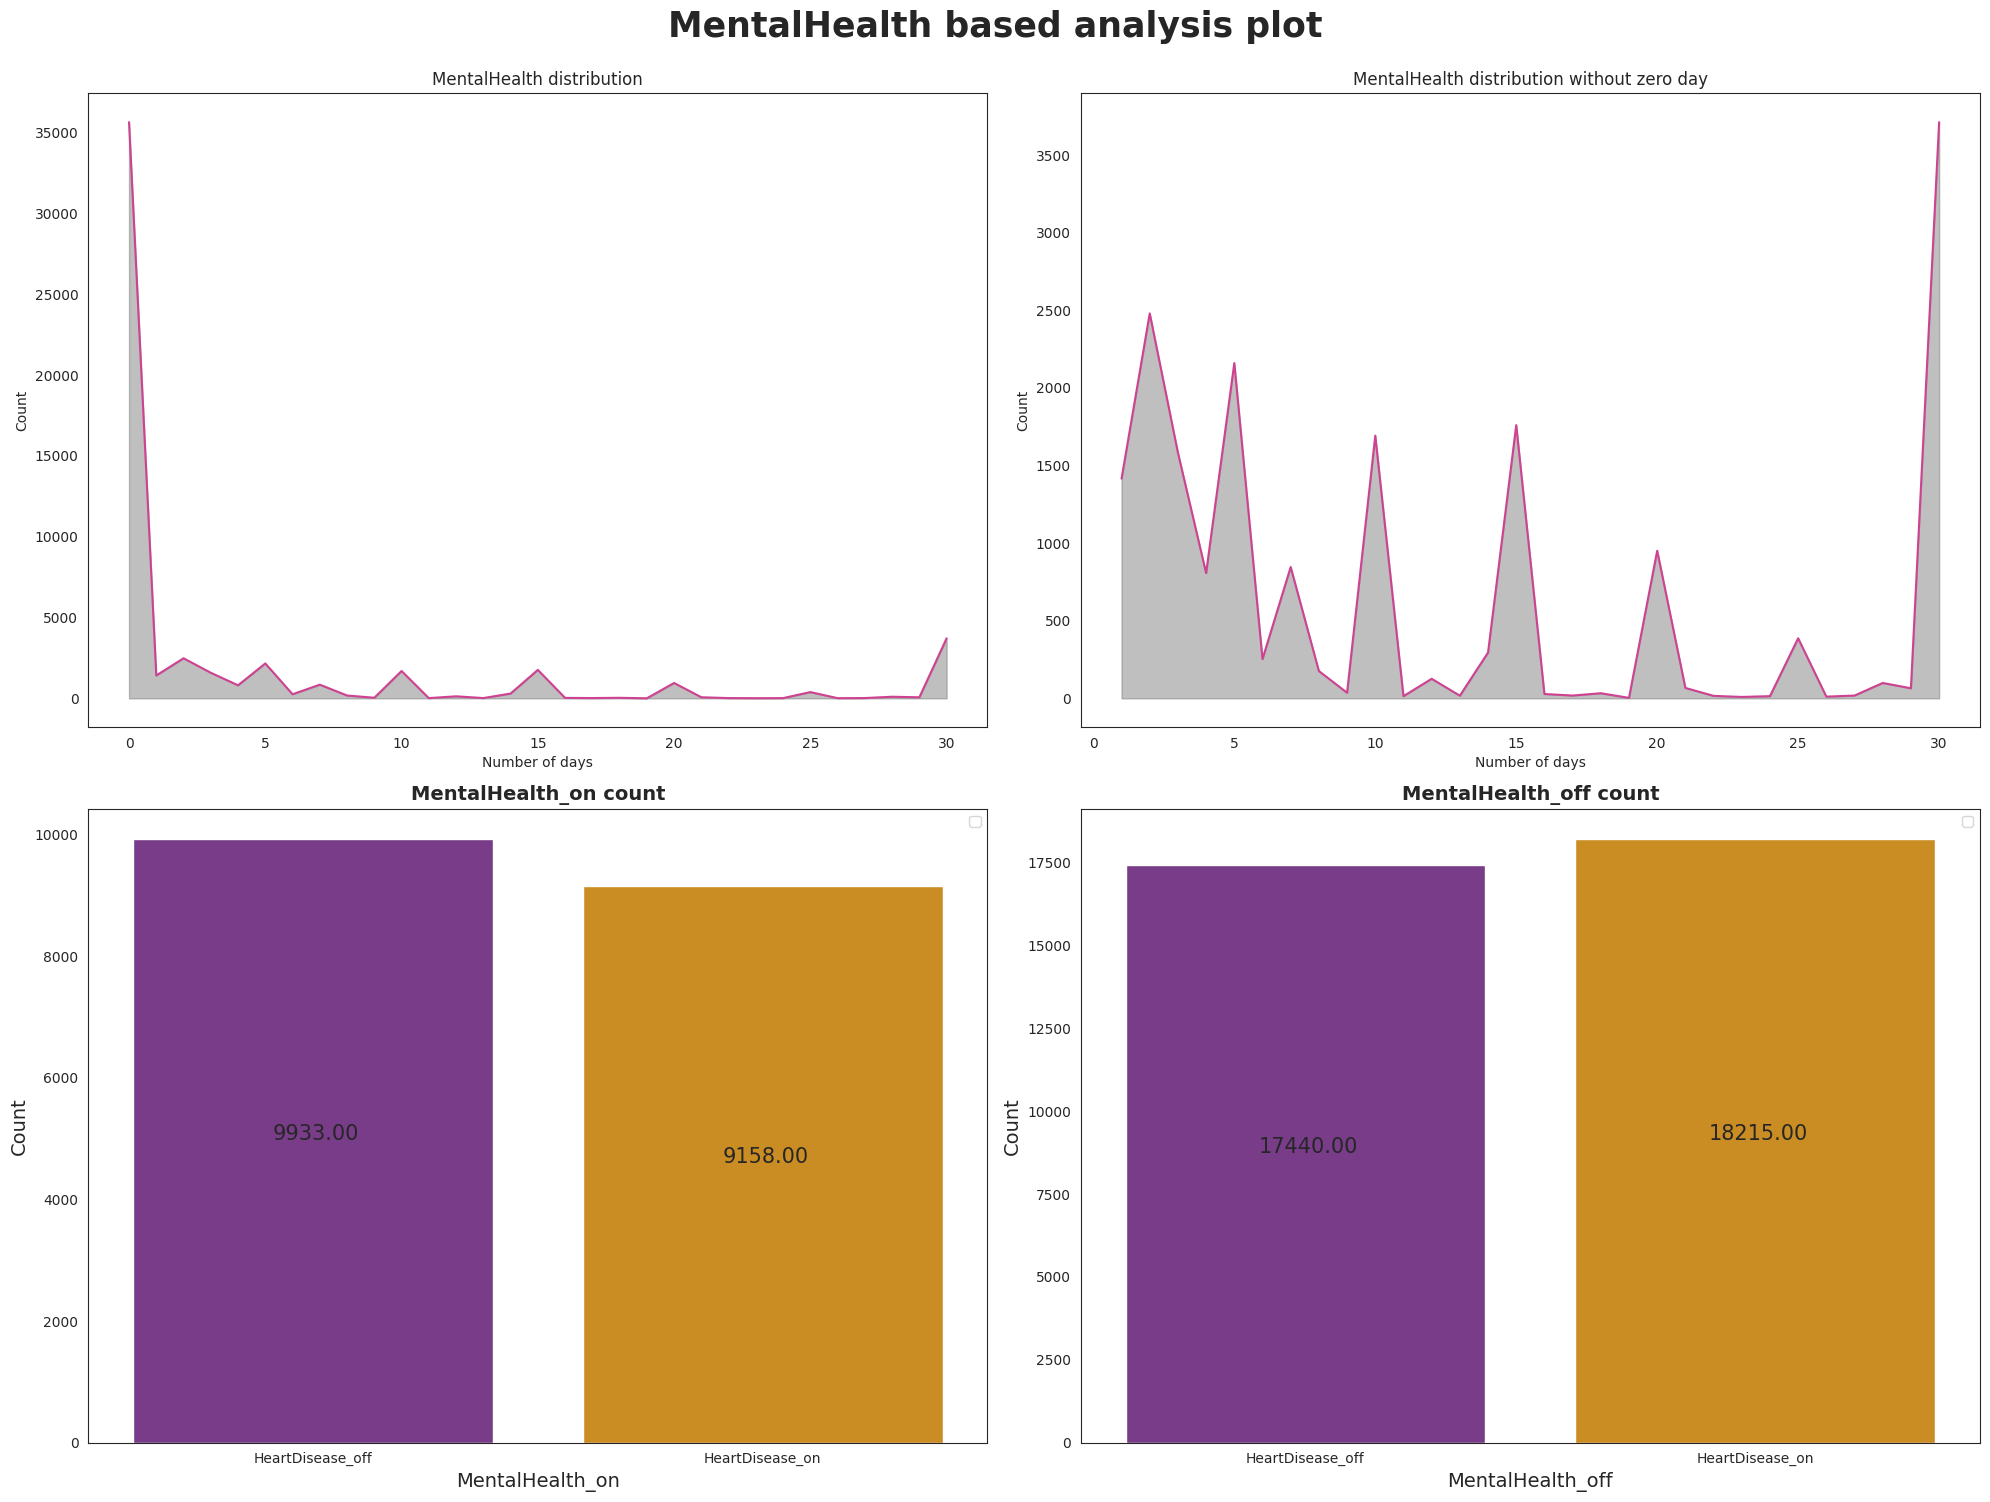

In [ ]:
fig=plt.figure(figsize=(20,15))
plt.suptitle("MentalHealth based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")


plt.subplot(2,2,1)
plt.plot(df1.MentalHealth,df1["Count"])
plt.fill_between(df1.MentalHealth,df1["Count"],color="grey",alpha=0.5)
plt.title("MentalHealth distribution")
plt.xlabel("Number of days")
plt.ylabel("Count")



plt.subplot(2,2,2)
#fig=plt.figure(figsize=(10,5))
plt.plot(df2.MentalHealth,df2["Count"])
plt.fill_between(df2.MentalHealth,df2["Count"],color="grey",alpha=0.5)
plt.title("MentalHealth distribution without zero day")
plt.xlabel("Number of days")
plt.ylabel("Count")


plt.subplot(2,2,4)
MentalHealth_off_andHeartDisease_off=len(data[(data.MentalHealth==0)&(data['HeartDisease']==0)])
MentalHealth_off_andHeartDisease_on=len(data[(data.MentalHealth==0)&(data['HeartDisease']==1)])

data1 = {"MentalHealth_off":["HeartDisease_off","HeartDisease_on"],
         "Count": [MentalHealth_off_andHeartDisease_off,MentalHealth_off_andHeartDisease_on]}
df = pd.DataFrame(data1, columns=['MentalHealth_off', 'Count'])
#fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="MentalHealth_off", y="Count", data=df,hue="MentalHealth_off",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("MentalHealth_off", size=14)

plt.ylabel("Count", size=14)

plt.title("MentalHealth_off count",fontsize=14,fontweight="bold")
plt.legend(loc='best')

plt.subplot(2,2,3)
MentalHealth_on_andHeartDisease_off=len(data[(data.MentalHealth>0)&(data['HeartDisease']==0)])
MentalHealth_on_andHeartDisease_on=len(data[(data.MentalHealth>0)&(data['HeartDisease']==1)])



data1 = {"MentalHealth_on":["HeartDisease_off","HeartDisease_on"],
         "Count": [MentalHealth_on_andHeartDisease_off,MentalHealth_on_andHeartDisease_on]}
df = pd.DataFrame(data1, columns=['MentalHealth_on', 'Count'])
#fig=plt.figure(figsize=(15,5))
plots = sns.barplot(x="MentalHealth_on", y="Count", data=df,hue="MentalHealth_on",errorbar=('ci', 10),n_boot=10,orient="v",
                    palette='CMRmap')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width()/ 2 ,bar.get_height()/2),
                   ha='center', va='center',size=15, xytext=(2, 5),textcoords='offset points')

plt.xlabel("MentalHealth_on", size=14)

plt.ylabel("Count", size=14)

plt.title("MentalHealth_on count",fontsize=14,fontweight="bold")
plt.legend(loc='best')

plt.tight_layout()
plt.show()

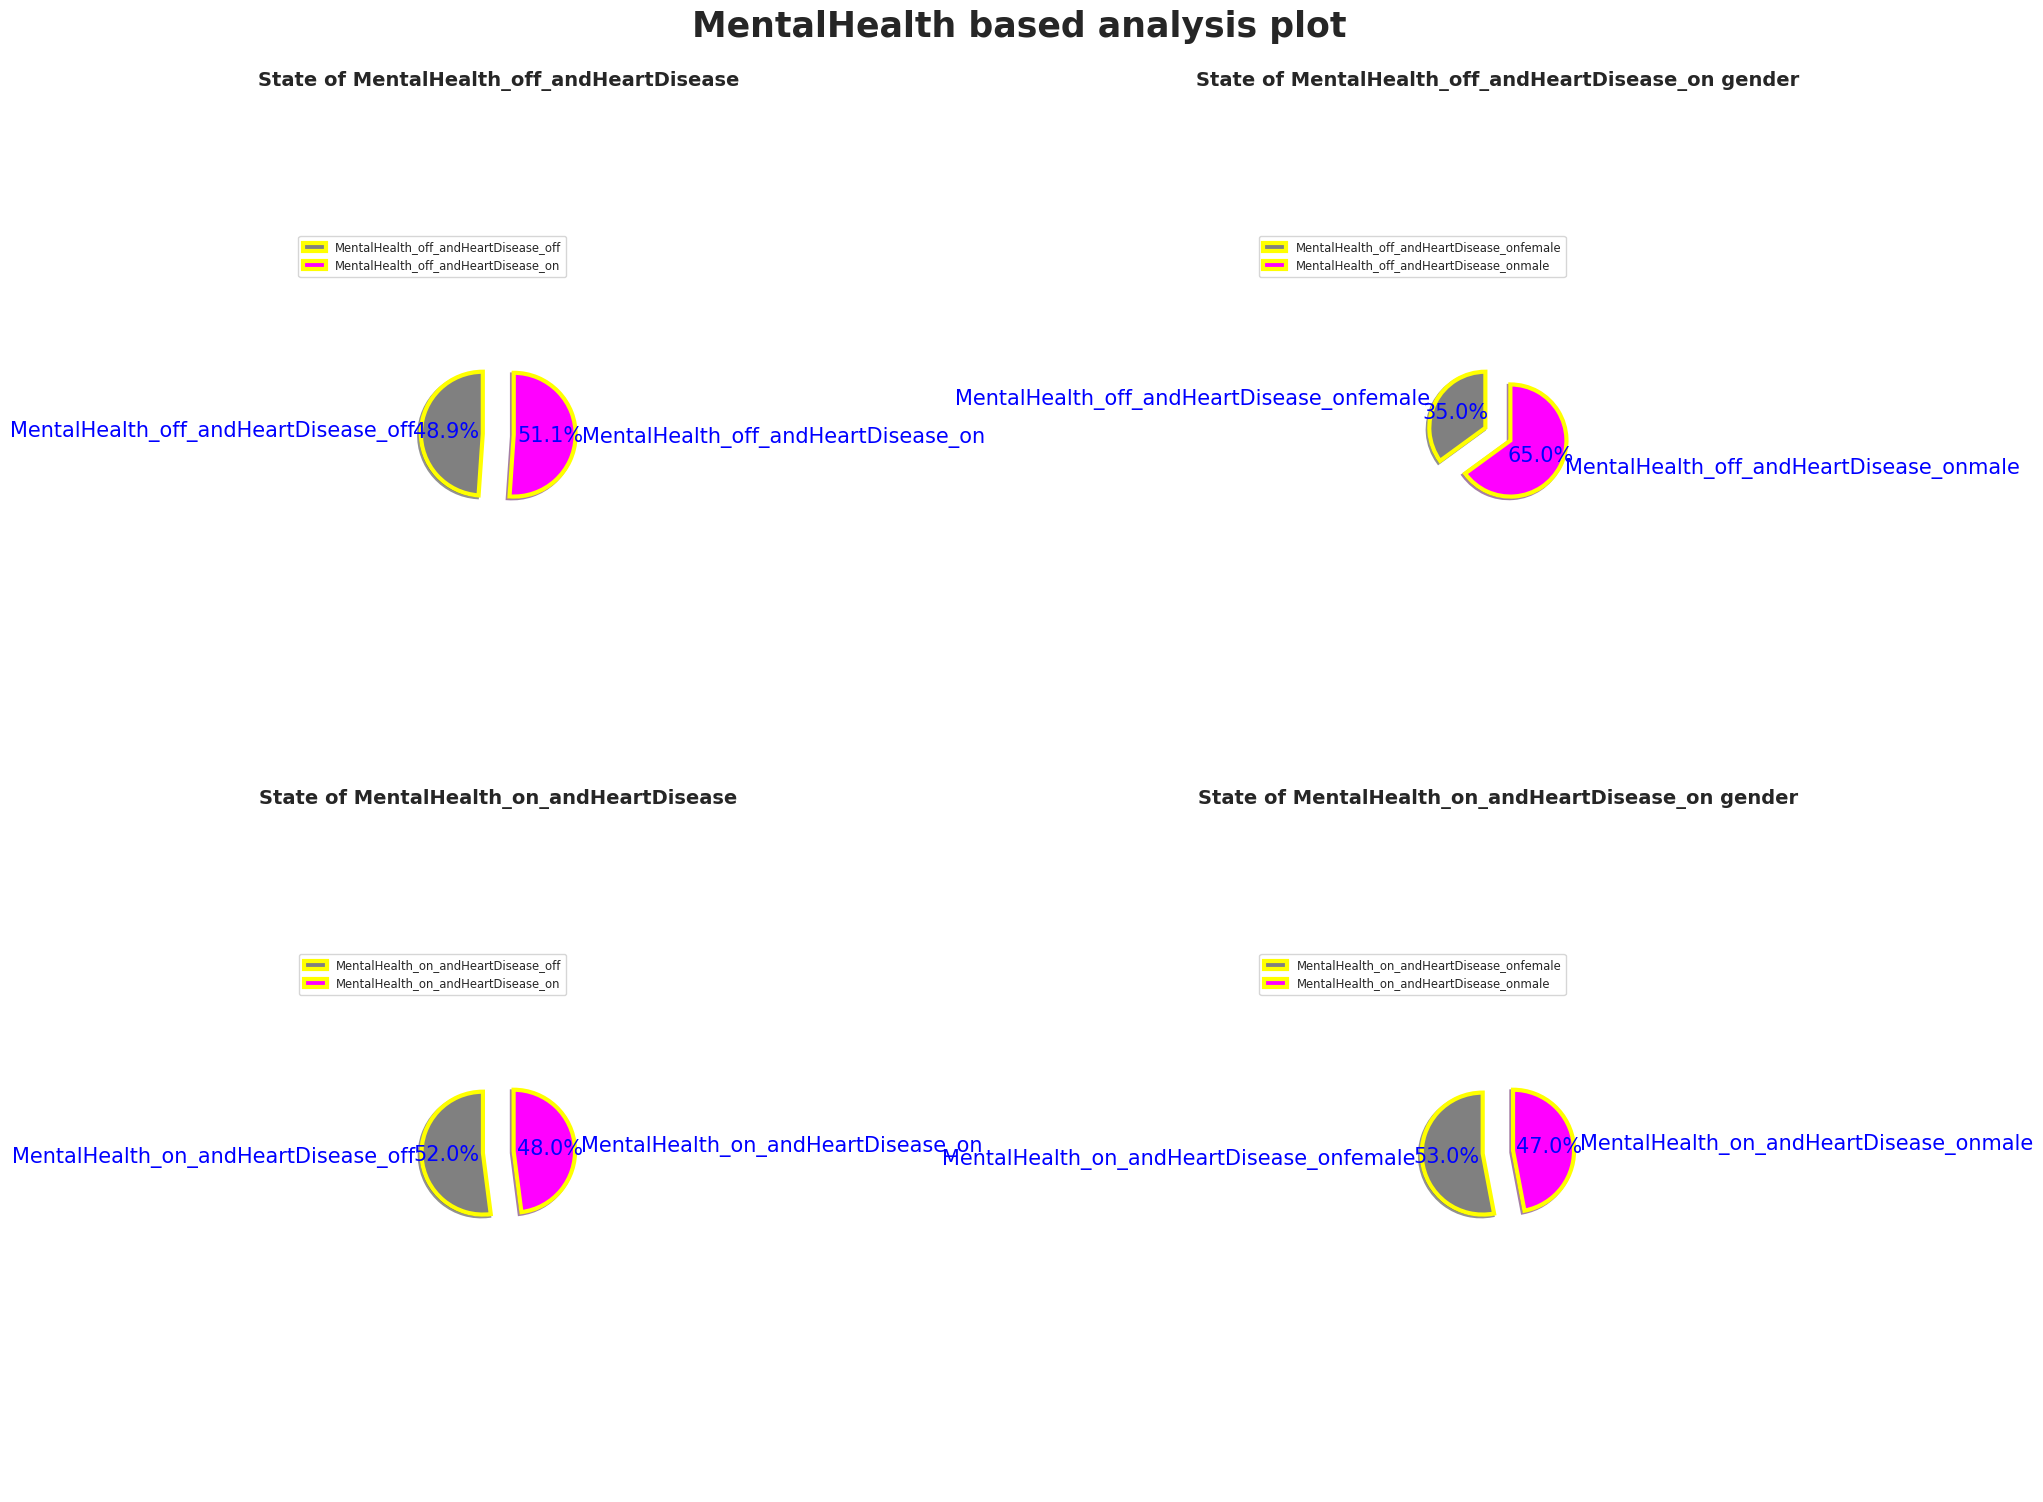

In [ ]:
fig=plt.figure(figsize=(20,15))
plt.suptitle("MentalHealth based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")





plt.subplot(2,2,1)
MentalHealth_off_andHeartDisease_off=len(data[(data.MentalHealth==0)&(data['HeartDisease']==0)])
MentalHealth_off_andHeartDisease_on=len(data[(data.MentalHealth==0)&(data['HeartDisease']==1)])


y=['MentalHealth_off_andHeartDisease_off','MentalHealth_off_andHeartDisease_on']
x=[MentalHealth_off_andHeartDisease_off,MentalHealth_off_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of MentalHealth_off_andHeartDisease',fontsize=14,fontweight="bold")
#plt.show()




plt.subplot(2,2,2)
MentalHealth_off_andHeartDisease_onfemale=len(data[(data.MentalHealth==0)&(data['HeartDisease']==1)
                                               &(data['Sex']==0)])
MentalHealth_off_andHeartDisease_onmale=len(data[(data.MentalHealth==0)&(data['HeartDisease']==1)
                                               &(data['Sex']==1)])

y=['MentalHealth_off_andHeartDisease_onfemale','MentalHealth_off_andHeartDisease_onmale']
x=[MentalHealth_off_andHeartDisease_onfemale,MentalHealth_off_andHeartDisease_onmale]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of MentalHealth_off_andHeartDisease_on gender',fontsize=14,fontweight="bold")
#plt.show()


plt.subplot(2,2,3)
MentalHealth_on_andHeartDisease_off=len(data[(data.MentalHealth>0)&(data['HeartDisease']==0)])
MentalHealth_on_andHeartDisease_on=len(data[(data.MentalHealth>0)&(data['HeartDisease']==1)])

y=['MentalHealth_on_andHeartDisease_off','MentalHealth_on_andHeartDisease_on']
x=[MentalHealth_on_andHeartDisease_off,MentalHealth_on_andHeartDisease_on]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of MentalHealth_on_andHeartDisease',fontsize=14,fontweight="bold")



plt.subplot(2,2,4)
MentalHealth_on_andHeartDisease_onfemale=len(data[(data.MentalHealth>0)&(data['HeartDisease']==1)
                                               &(data['Sex']==0)])
MentalHealth_on_andHeartDisease_onmale=len(data[(data.MentalHealth>0)&(data['HeartDisease']==1)
                                               &(data['Sex']==1)])

y=['MentalHealth_on_andHeartDisease_onfemale','MentalHealth_on_andHeartDisease_onmale']
x=[MentalHealth_on_andHeartDisease_onfemale,MentalHealth_on_andHeartDisease_onmale]
c=["grey","magenta"]
pct=[0.2,0.3]
w={'edgecolor':"yellow",'linewidth':3,'antialiased':True}
textprops = {'color':"blue","fontsize":15}
plt.pie(x,labels=y,colors=c,explode=pct,autopct="%2.1f%%",shadow=True,startangle=90,
        wedgeprops=w,textprops = textprops,radius=1)
plt.axis('equal')
plt.legend(bbox_to_anchor=(0.9,0.8),fontsize='small')
plt.title('State of MentalHealth_on_andHeartDisease_on gender',fontsize=14,fontweight="bold")
#plt.show()



#fig.legend(bbox_to_anchor=(0.9,1.3))
plt.tight_layout()
plt.show()

## Observations:
There is some evidence to suggest that improving mental health can have a positive impact on heart health. Mental health conditions such as depression, anxiety, and chronic stress have been linked to an increased risk of heart disease. This is because these conditions can lead to unhealthy behaviors such as smoking, drinking, and a sedentary lifestyle. Additionally, they can cause physiological changes in the body, such as increased inflammation and blood pressure, which can contribute to the development of heart disease.

On the other hand, addressing mental health conditions through therapy, medication, or other interventions can help individuals adopt healthier behaviors and reduce their risk of heart disease. For example, managing stress through relaxation techniques or counseling can help lower blood pressure and reduce the risk of heart disease.

Overall, while mental health conditions can increase the risk of heart disease, addressing these conditions and improving mental health can have a positive impact on heart health.

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs SleepTime"</p>

In [ ]:
data.SleepTime.value_counts()

SleepTime
8.0     16632
7.0     14855
6.0     11274
5.0      3615
9.0      3040
4.0      1837
10.0     1748
12.0      586
3.0       510
2.0       183
11.0      113
1.0       105
14.0       59
16.0       52
15.0       37
18.0       35
13.0       29
20.0       17
24.0        8
17.0        5
22.0        4
23.0        1
19.0        1
Name: count, dtype: int64

In [ ]:
x1=list(dict(data.SleepTime.value_counts()).keys())
x=[]
for i in x1:
    x.append(int(i))
y=list(dict(data.SleepTime.value_counts()).values())

data1 = {"SleepTime":x,
         "Count": y}
df = pd.DataFrame(data1, columns=['SleepTime', 'Count'])
if data['Sex'].duplicated().any():
    print("Duplicate values found in the 'Sex' column")
else:
    # If no duplicates, assign the 'Sex' column to the DataFrame
    df["Sex"] = data['Sex']
#df["Sex"]=data.Sex
df1=df.sort_values("SleepTime")

Duplicate values found in the 'Sex' column


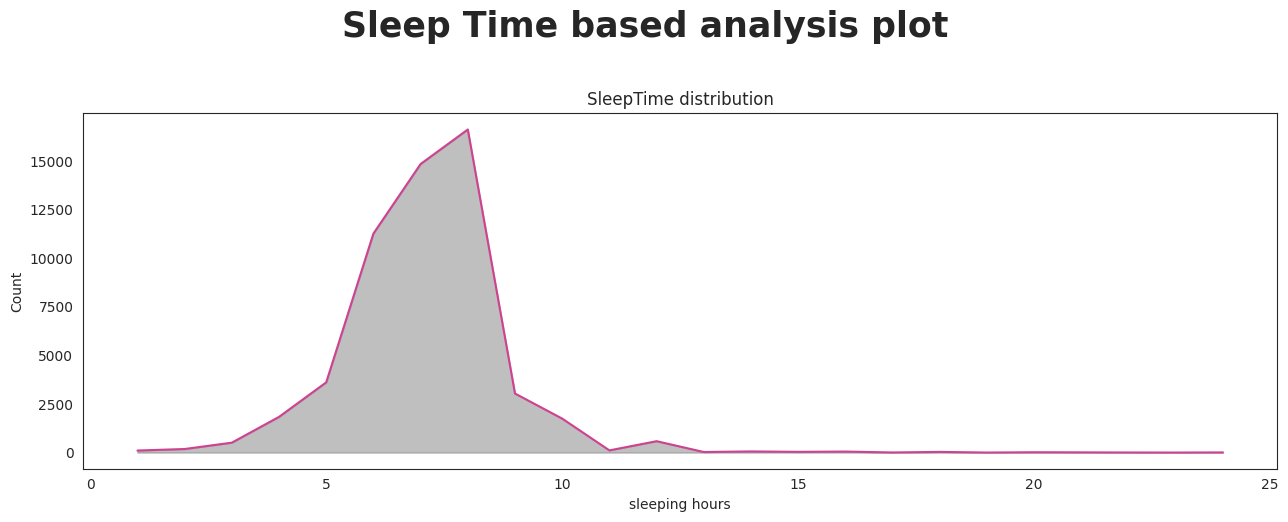

In [ ]:
fig=plt.figure(figsize = (13,5))
plt.suptitle("Sleep Time based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")

plt.plot(df1.SleepTime,df1["Count"])
plt.fill_between(df1.SleepTime,df1["Count"],color="grey",alpha=0.5)
plt.title("SleepTime distribution")
plt.xlabel("sleeping hours")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

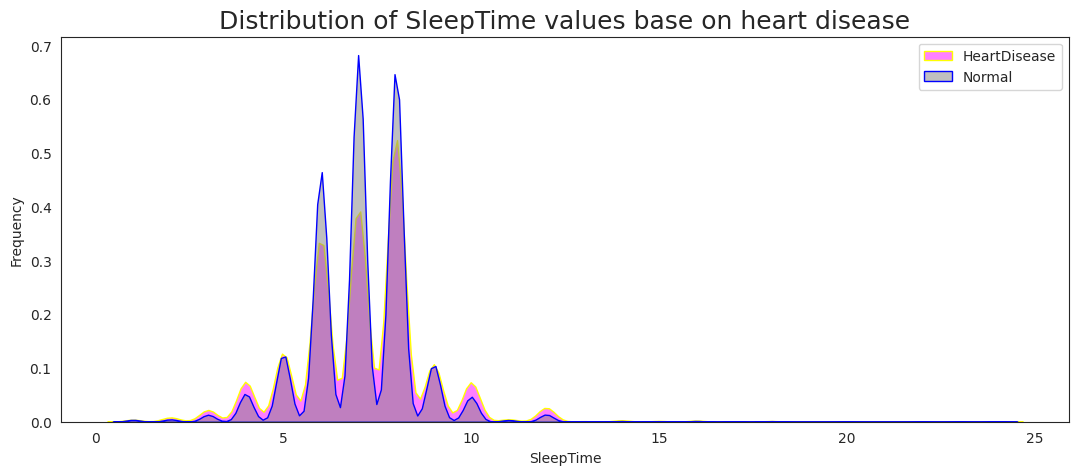

In [ ]:
fig, ax = plt.subplots(figsize = (13,5))
sns.kdeplot(data[data["HeartDisease"]==1]["SleepTime"], alpha=0.5,fill = True, color="magenta",edgecolor="yellow", label="HeartDisease", ax = ax)
sns.kdeplot(data[data["HeartDisease"]==0]["SleepTime"], alpha=0.5,fill = True, color="grey",edgecolor="blue", label="Normal", ax = ax)
plt.title('Distribution of SleepTime values base on heart disease', fontsize = 18)
ax.set_xlabel("SleepTime")
ax.set_ylabel("Frequency")
ax.legend();
plt.show()

In [ ]:
d1 = data.loc[(data["HeartDisease"]==1) & (data["Sex"]==0), "SleepTime"]
d2 = data.loc[(data["HeartDisease"]==1) & (data["Sex"]==1), "SleepTime"]

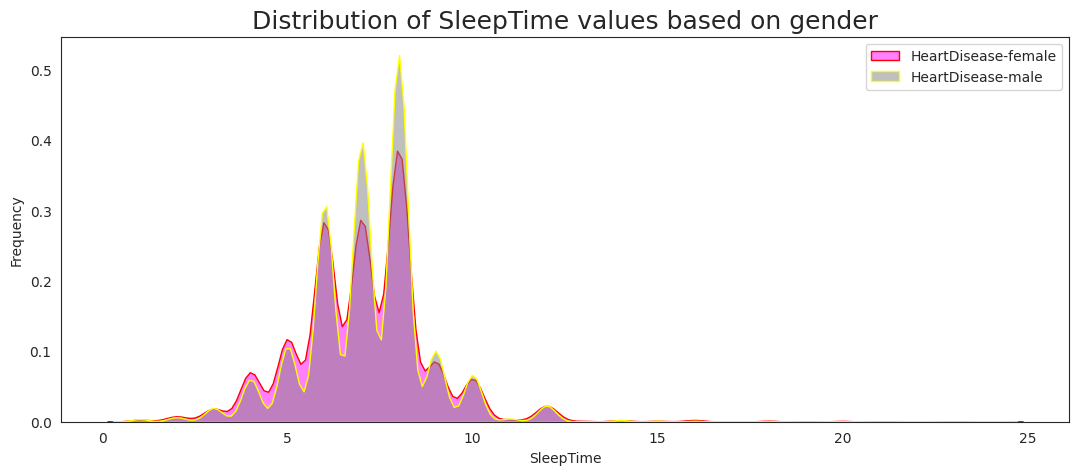

In [ ]:
fig, ax = plt.subplots(figsize = (13,5))
sns.kdeplot(d1, alpha=0.5,fill = True, color="magenta",edgecolor="red", label="HeartDisease-female", ax = ax)
sns.kdeplot(d2, alpha=0.5,fill = True, color="grey",edgecolor="yellow", label="HeartDisease-male", ax = ax)
plt.title('Distribution of SleepTime values based on gender', fontsize = 18)
ax.set_xlabel("SleepTime")
ax.set_ylabel("Frequency")
ax.legend();
plt.show()


## Observations:
There is some evidence to suggest that sleep duration and quality can have an impact on heart health. Studies have shown that both insufficient sleep and excessive sleep can increase the risk of heart disease, as can poor quality sleep.

Short sleep duration, typically defined as less than 7 hours per night, has been associated with an increased risk of high blood pressure, diabetes, obesity, and other risk factors for heart disease. Conversely, long sleep duration, typically defined as more than 9 hours per night, has also been associated with an increased risk of heart disease.

Additionally, poor quality sleep, characterized by frequent awakenings, sleep apnea, or other sleep disorders, has also been linked to an increased risk of heart disease.

Overall, getting enough high-quality sleep is an important factor in maintaining heart health. While the optimal amount of sleep can vary from person to person, it is generally recommended that adults aim for 7-9 hours of sleep per night and take steps to improve sleep quality if needed.

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">"Analysis of Heart Disease Cases vs BMI"</p>

In [ ]:
data.BMI.value_counts()

BMI
26.63    588
27.12    439
24.41    431
27.44    426
27.46    424
        ... 
49.87      1
49.23      1
39.00      1
63.62      1
35.92      1
Name: count, Length: 2520, dtype: int64

In [ ]:
x1=list(dict(data.BMI.value_counts()).keys())
x=[]
for i in x1:
    x.append(int(i))
y=list(dict(data.BMI.value_counts()).values())

data1 = {"BMI":x,
         "Count": y}
df = pd.DataFrame(data1, columns=['BMI', 'Count'])
if data['Sex'].duplicated().any():
    print("Duplicate values found in the 'Sex' column")
else:
    # If no duplicates, assign the 'Sex' column to the DataFrame
    df["Sex"] = data['Sex']
#df["Sex"]=data.Sex
df1=df.sort_values("BMI")

Duplicate values found in the 'Sex' column


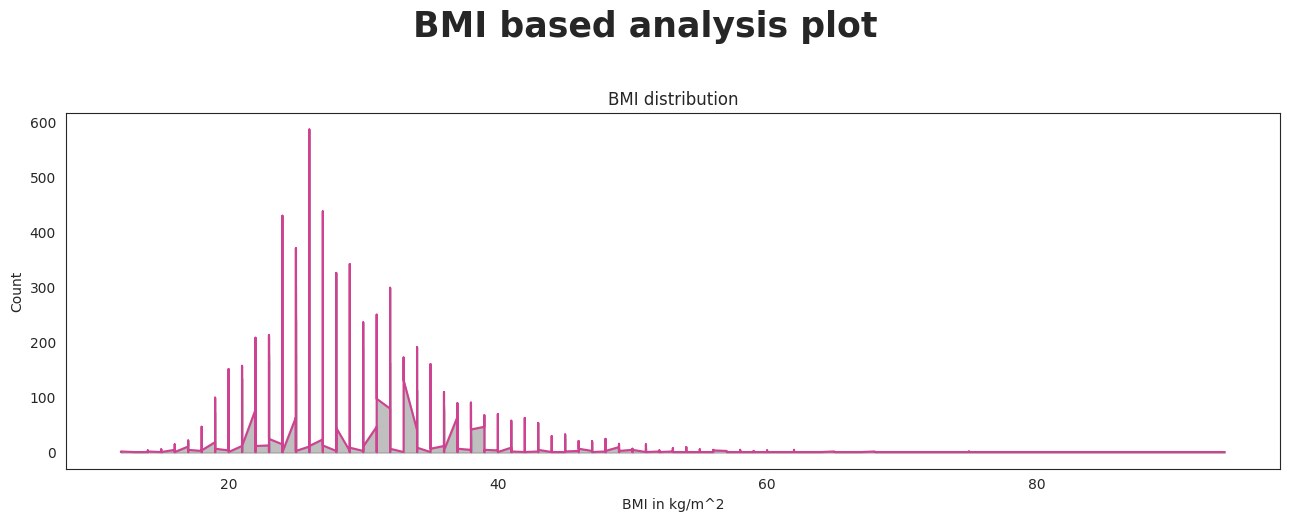

In [ ]:
fig=plt.figure(figsize = (13,5))
plt.suptitle("BMI based analysis plot",fontsize=25,fontweight="bold",ha="center",va="baseline")

plt.plot(df1.BMI,df1["Count"])
plt.fill_between(df1.BMI,df1["Count"],color="grey",alpha=0.5)
plt.title("BMI distribution")
plt.xlabel("BMI in kg/m^2")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
d1 = data.loc[(data["HeartDisease"]==1) & (data["Sex"]==0), "BMI"]
d2 = data.loc[(data["HeartDisease"]==1) & (data["Sex"]==1), "BMI"]

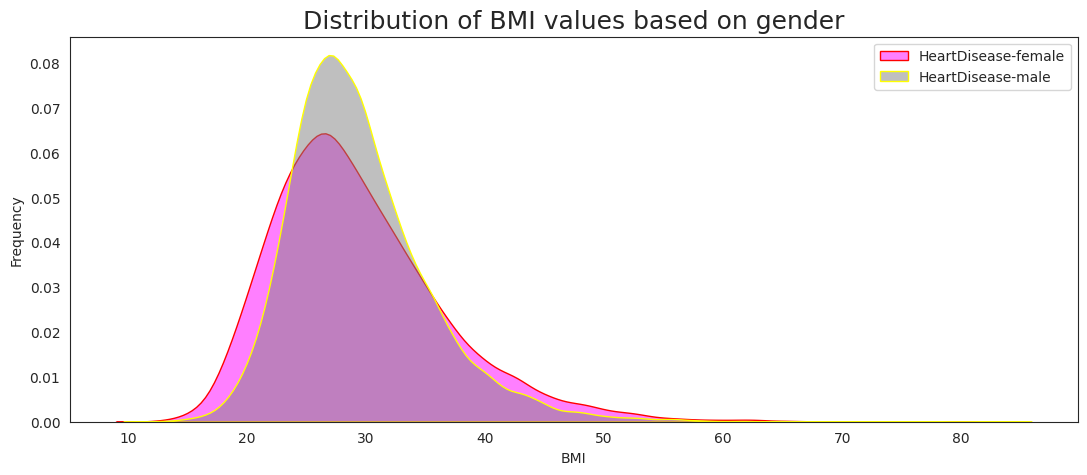

In [ ]:
fig, ax = plt.subplots(figsize = (13,5))
sns.kdeplot(d1, alpha=0.5,fill = True, color="magenta",edgecolor="red", label="HeartDisease-female", ax = ax)
sns.kdeplot(d2, alpha=0.5,fill = True, color="grey",edgecolor="yellow", label="HeartDisease-male", ax = ax)
plt.title('Distribution of BMI values based on gender', fontsize = 18)
ax.set_xlabel("BMI")
ax.set_ylabel("Frequency")
ax.legend();
plt.show()


## Observations:

There is a well-established relationship between body mass index (BMI) and the risk of developing heart disease. BMI is a measure of body fat based on a person's height and weight, and it is commonly used as a screening tool to identify whether a person is overweight or obese.

Research has shown that individuals who have a high BMI, particularly those who are obese, are at an increased risk of developing several risk factors for heart disease, such as high blood pressure, high cholesterol levels, and type 2 diabetes. These risk factors can increase the risk of developing cardiovascular disease, including coronary heart disease, stroke, and heart failure.

Furthermore, studies have also found that losing weight and maintaining a healthy BMI can reduce the risk of developing heart disease and improve overall cardiovascular health. This can be achieved through a combination of regular physical activity, a healthy diet, and other lifestyle changes.

It is important to note that while BMI is a useful screening tool, it is not a definitive measure of body fat or health. Other factors, such as muscle mass and body composition, can also play a role in determining an individual's risk of developing heart disease. Therefore, it is important to consult with a healthcare professional to assess your overall risk and develop an appropriate plan for prevention and management of heart disease.

<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Data Preprocessing</p>   

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">Performing Label Encoding</p>  

## LABEL ENCODIN
Label Encoding is a process of converting categorical data into numerical values, where each unique category is assigned a unique integer label. This is a commonly used technique in machine learning and data analysis to transform categorical features into numerical features that can be used by algorithms.

In [ ]:
ds = data.copy()

In [ ]:
ds.sample(5)

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
258067             0  25.79        0                0       0             0.0   
100352             1  22.11        1                0       1            30.0   
45578              1  35.15        1                0       1            30.0   
76034              1  26.63        1                0       0             8.0   
246656             1  24.82        1                0       1             0.0   

        MentalHealth  DiffWalking  Sex AgeCategory   Race  Diabetic  \
258067           0.0            0    0       60-64  White         0   
100352          30.0            1    0       60-64  White         0   
45578            1.0            1    0       70-74  White         1   
76034            3.0            0    0       65-69  White         0   
246656           0.0            1    1       70-74  White         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
258067                 1  Very good        7.0       0              0   
100352                 0       Poor        6.0       0              0   
45578                  0       Poor       12.0       0              0   
76034                  1       Good        7.0       0              0   
246656                 1       Fair        9.0       1              0   

        SkinCancer  
258067           0  
100352           0  
45578            0  
76034            0  
246656           0

In [ ]:
ds.shape

(54746, 18)

In [ ]:
categorical_cols = ['AgeCategory', 'Race', 'GenHealth']
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()
for i in categorical_cols:
    ds[i]=ds[[i]].apply(LE.fit_transform)


In [ ]:
ds_copy = ds.copy()
ds_copy.head(5)

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
179758             0  25.11        1                0       0             0.0   
1404               0  41.59        1                0       0            10.0   
94142              0  25.73        1                1       0             1.0   
268405             0  25.80        1                0       0             2.0   
92471              0  19.53        1                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory  Race  Diabetic  \
179758           0.0            0    1            9     5         0   
1404             0.0            1    0            8     5         0   
94142            1.0            0    1            4     5         0   
268405           0.0            0    1            0     5         0   
92471            1.0            0    0            8     5         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
179758                 1          4        6.0       0              0   
1404                   0          2        8.0       0              0   
94142                  1          0        9.0       0              0   
268405                 1          0        9.0       1              0   
92471                  0          4        8.0       0              0   

        SkinCancer  
179758           0  
1404             0  
94142            0  
268405           0  
92471            0

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">Split Dataset for Training and Testing</p>  

In [ ]:
from sklearn.model_selection import train_test_split

features = ds_copy.drop(columns =['HeartDisease'], axis = 1)
#Select Target
target = ds_copy['HeartDisease']
# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle = True, test_size = .05, random_state = 4)
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (52008, 17)
Shape of testing feature: (2738, 17)
Shape of training label: (52008,)
Shape of training label: (2738,)


<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">Standard Scaling</p>  

Standard scaling, also known as z-score normalization, is a common preprocessing technique used in machine learning to transform numerical data so that it has zero mean and unit variance. This is achieved by subtracting the mean of the data from each data point and then dividing by the standard deviation.

Standard scaling is useful in machine learning because many algorithms assume that the data is normally distributed and have equal variances. By scaling the data to have zero mean and unit variance, the features become comparable in terms of their influence on the prediction, and it can help algorithms converge more quickly and perform better.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)

<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Modelling</p>

## GridSearchCV
GridSearchCV is a technique used in machine learning to search for the optimal hyperparameters of a model by exhaustively trying all possible combinations of hyperparameters within a specified range. It is a type of hyperparameter tuning technique that helps to automate the process of finding the best set of hyperparameters for a given model.

In GridSearchCV, a set of hyperparameters and their possible values are defined and a search is performed over all possible combinations of these hyperparameters. For each combination of hyperparameters, a cross-validation is performed, and the performance metric of the model is evaluated. The combination of hyperparameters that results in the highest performance metric is selected as the optimal set of hyperparameters for the model.

## LogisticRegression
Logistic Regression is a statistical model used to predict the probability of a binary outcome.In logistic regression, the input features are used to calculate a weighted sum, which is then passed through a logistic function that maps the output to a probability value between 0 and 1. The logistic function is an S-shaped curve that increases rapidly as the input value becomes positive, and decreases rapidly as the input value becomes negative.

The logistic regression model is trained using a maximum likelihood estimation, which aims to find the values of the model parameters that maximize the likelihood of the observed data given the model. The model parameters can be interpreted as the weights assigned to each input feature, indicating how strongly each feature is related to the binary outcome.

Logistic regression can be used for both binary and multiclass classification problems, and it is a popular algorithm in machine learning due to its simplicity, interpretability, and efficiency. However, it is important to note that logistic regression assumes a linear relationship between the input features and the log-odds of the binary outcome, and may not perform well when the relationship is nonlinear.

## RandomForestClassifier
Random Forest Classifier is a type of ensemble learning algorithm that is used for classification tasks. It is an extension of the decision tree algorithm that constructs a multitude of decision trees at training time and outputs the class that is the mode of the classes of the individual trees.

Random Forest Classifier works by randomly selecting a subset of the features and a subset of the training data at each split, to build multiple decision trees that are less correlated and more diverse. The final output of the algorithm is then the majority vote of the predictions made by the individual decision trees.

Random Forest Classifier has several advantages over a single decision tree, including reduced overfitting, improved accuracy, and better handling of missing values and categorical features. It is also less sensitive to the choice of hyperparameters, making it a more robust algorithm that requires less tuning.

Random Forest Classifier can be used for both binary and multiclass classification tasks and can also be extended to regression tasks using Random Forest Regression. It is a popular algorithm in machine learning due to its high performance, flexibility, and ease of use.

## DecisionTreeClassifier
Decision Tree Classifier is a type of supervised learning algorithm used in machine learning for classification tasks. It works by constructing a tree-like model of decisions and their possible consequences, with each node in the tree representing a test on an attribute value, each branch representing the outcome of the test, and each leaf node representing a class label.

Decision Tree Classifier works by recursively partitioning the input space into subsets based on the values of the input features. At each step of the tree construction, the algorithm selects the feature that best splits the data into the most homogeneous subsets in terms of the class labels. The splitting criterion is typically based on measures such as entropy, Gini impurity, or information gain.

Once the decision tree is constructed, it can be used to predict the class label of new input data by traversing the tree from the root node to a leaf node based on the values of the input features. The class label associated with the leaf node reached by the input data is then returned as the predicted class label.

Decision Tree Classifier has several advantages over other classification algorithms, including ease of use, interpretability, and ability to handle both categorical and numerical data. However, it can be prone to overfitting and may not perform well when the decision boundaries are nonlinear or complex.

To address the issue of overfitting, various techniques such as pruning, ensemble methods (such as Random Forests), or regularization can be used.

 <p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">Finding best model using GridSearchCV</p>  

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression





def find_best_model_using_gridsearchcv(X,y):
    algos = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 20, 30],
            'max_depth': [5, 10, 15]
        }
    },
        'LogisticRegression': {
            'model': LogisticRegression(),
            'params': {


            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X_train, y_train)

model  best_score                             best_params
0       Decision Tree    0.750683  {'criterion': 'gini', 'max_depth': 10}
1       Random Forest    0.764603   {'max_depth': 15, 'n_estimators': 30}
2  LogisticRegression    0.752644                                      {}

<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">Making a Model using Random Forest Classifier</p>  

In [ ]:
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=30, random_state=0,max_depth=10)

# Fit the random forest classifier to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the random forest classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7702702702702703


In [ ]:
from sklearn import metrics


print(f"precision: {metrics.precision_score(y_test, y_pred)}")
print(f"recall: {metrics.recall_score(y_test, y_pred)}")
print(f"f1-score: {metrics.f1_score(y_test, y_pred)}")
print(f"kappa score: {metrics.cohen_kappa_score(y_test, y_pred)}")


#  confussion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion matrix: {cm}")


precision: 0.7436600411240576
recall: 0.8097014925373134
f1-score: 0.7752768846016435
kappa score: 0.5411795045852691
Confusion matrix: [[1024  374]
 [ 255 1085]]


<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">Forecasts from a machine learning model</p>   

In [ ]:
def predict_heart_disease(BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking
                          ,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,
                         KidneyDisease,SkinCancer):
    AgeCategory = LE.fit_transform([AgeCategory])
    Race = LE.fit_transform([Race])
    GenHealth = LE.fit_transform([GenHealth])


    # Create a DataFrame with user input
    data1 = {'BMI': BMI, 'Smoking': Smoking, 'AlcoholDrinking': AlcoholDrinking, 'Stroke': Stroke,
             'PhysicalHealth': PhysicalHealth, 'MentalHealth': MentalHealth, 'DiffWalking': DiffWalking,
             'Sex': Sex,'AgeCategory': AgeCategory,'Race': Race,'Diabetic': Diabetic,'PhysicalActivity': PhysicalActivity,
             'GenHealth': GenHealth,'SleepTime': SleepTime,'Asthma': Asthma,'KidneyDisease':KidneyDisease,
             'SkinCancer': SkinCancer}
    input_df = pd.DataFrame(data1, index=[0])

    input_df = input_df[input_df.columns].replace({'Yes':1, 'No':0, 'Male':1,'Female':0,
                                       'No, borderline diabetes':'0','Yes (during pregnancy)':'1' })
    input_df['Diabetic'] = input_df['Diabetic'].astype(int)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # Scale trainint data
    input_df = scaler.fit_transform(input_df)

    # Make a prediction using the random forest classifier
    prediction = rf.predict(input_df)

    if prediction[0] == 0:
        return 'The patient is unlikely to have heart disease.'
    else:
        return 'The patient is likely to have heart disease.'

In [ ]:
# Make a prediction using the function
print(predict_heart_disease(16.60, 'Yes', 'No', 'No', 3.0, 30.0,'No', 'Female','55-59',
                            'White','Yes','Yes','Very good',5.0,'Yes','No','Yes'))

The patient is likely to have heart disease.


<p style="background-color:#1f81a8;font-family:newtimeroman;color:#010889;font-size:150%;text•align:center;border-radius:10px 10px;">Export the tested model to a pickle file</p>  

Pickle file is a binary file format in Python used for serializing and de-serializing Python objects. It is a way to convert a Python object into a byte stream, which can be written to a file or transferred over a network, and then reconstructed later to get back the original object with its attributes and methods.

Pickle module in Python provides methods to dump Python objects into a file and load them back. The dump() method is used to serialize a Python object and write it to a file, and the load() method is used to de-serialize the object from the file and reconstruct it back into the original Python object.

Pickle file format can be used to store and transfer complex data structures such as lists, dictionaries, classes, and functions. It is commonly used in machine learning to save trained models and reuse them later, without the need to retrain the model from scratch.

In [ ]:
import joblib
# Save the model as a pickle in a file
joblib.dump(rf, "RandomForestClassifier.pkl")

['RandomForestClassifier.pkl']

<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Streamlit Machine Learning Model app</p>


Streamlit is a Python library used for building interactive web applications for machine learning and data science projects. It allows developers to quickly create and deploy custom user interfaces for their models and data visualizations, without the need for complex web development skills.

Streamlit provides a simple and intuitive interface for creating interactive widgets such as sliders, drop-down menus, and text inputs, that can be used to adjust the input parameters of machine learning models and explore data in real-time. It also supports plotting and data visualization using popular Python libraries such as Matplotlib and Plotly.

import streamlit as st  
import pandas as pd   
import joblib   
from sklearn.preprocessing import LabelEncoder   
from sklearn.preprocessing import StandardScaler   

#from PIL import Image   


#Loading Our final trained Knn model    
model= open("RandomForestClassifier.pkl", "rb")   
rf=joblib.load(model)    
st.title("HEART DESEASE PREDICTION PROJECT APP")   


# Create input fields for user input   
BMI = st.number_input('BMI', step=1.0,format="%2.2f")   
Smoking = st.selectbox('Smoking', ['Yes', 'No'])   
AlcoholDrinking = st.selectbox('AlcoholDrinking', ['Yes', 'No'])   
Stroke = st.selectbox('Stroke', ['Yes', 'No'])   
PhysicalHealth=st.slider('PhysicalHealth', min_value=0.0,
                         max_value=30.0,step=1.0, format="%.1f")   
MentalHealth=st.slider('MentalHealth', min_value=0.0,
                         max_value=30.0,step=1.0, format="%.1f")   
DiffWalking = st.selectbox('DiffWalking', ['Yes', 'No'])   
Sex = st.selectbox('Sex', ['Male', 'Female'])   
AgeCategory = st.selectbox('AgeCategory', ['55-59', '80 or older', '65-69', '75-79',   
                                           '40-44', '70-74','60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'])   
Race = st.selectbox('Race', ['White', 'Black', 'Asian', 'American Indian/Alaskan Native','Other', 'Hispanic'])   
Diabetic = st.selectbox('Diabetic', ['Yes', 'No'])   
PhysicalActivity = st.selectbox('PhysicalActivity', ['Yes', 'No'])   
GenHealth = st.selectbox('GenHealth', ['Very good', 'Fair', 'Good', 'Poor', 'Excellent'])   
SleepTime=st.slider('SleepTime', min_value=0.0,
                         max_value=24.0,step=1.0, format="%.1f")   
Asthma = st.selectbox('Asthma', ['Yes', 'No'])   
KidneyDisease = st.selectbox('KidneyDisease', ['Yes', 'No'])   
SkinCancer = st.selectbox('SkinCancer', ['Yes', 'No'])    

# Convert user input to numerical values using LabelEncoder   
LE=LabelEncoder()   
AgeCategory = LE.fit_transform([AgeCategory])[0]   
Race = LE.fit_transform([Race])[0]   
GenHealth = LE.fit_transform([GenHealth])[0]   

# Create a prediction button   
if st.button('Predict'):   
    # Create a DataFrame with user input   
    data1 = {'BMI': BMI, 'Smoking': Smoking, 'AlcoholDrinking': AlcoholDrinking, 'Stroke': Stroke,
             'PhysicalHealth': PhysicalHealth, 'MentalHealth': MentalHealth, 'DiffWalking': DiffWalking,
             'Sex': Sex,'AgeCategory': AgeCategory,'Race': Race,'Diabetic': Diabetic,'PhysicalActivity': PhysicalActivity,
             'GenHealth': GenHealth,'SleepTime': SleepTime,'Asthma': Asthma,'KidneyDisease':KidneyDisease,
             'SkinCancer': SkinCancer}   
    input_df = pd.DataFrame(data1, index=[0])    
    input_df = input_df[input_df.columns].replace({'Yes':1, 'No':0, 'Male':1,'Female':0,
                                       'No, borderline diabetes':'0','Yes (during pregnancy)':'1' })
    input_df['Diabetic'] = input_df['Diabetic'].astype(int)   
    
    scaler = StandardScaler()   
    # Scale trainint data   
    input_df = scaler.fit_transform(input_df)   
    
    
    # Make a prediction using the random forest classifier   
    prediction = rf.predict(input_df)    
    
    # Display the prediction   
    if prediction[0] == 0:   
        st.write('The patient is unlikely to have heart disease.')  
    else:
        st.write('The patient is likely to have heart disease.')   

This is the heart disease prediction app using streamlit.
<img
src="https://github.com/mayaunnikrishnan/exploration-of-heart-disease-data/blob/fbac0cfedafdd1a0c14ecaf07d49109503e814fe/png1.png?raw=true">

This is the heart disease prediction app using streamlit: second prediction
<img
src="https://github.com/mayaunnikrishnan/exploration-of-heart-disease-data/blob/fbac0cfedafdd1a0c14ecaf07d49109503e814fe/png.png?raw=true">

<p style="background-color:#072d78;font-family:newtimeroman;color:#FFF9ED;font-size:200%;textalign:center;border-radius:10px 10px;">Conclusion</p>


At the onset of the project, an extensive analysis was carried out on the heart disease dataset. Pandas library was utilized to replace the columns, while the label encoding feature from sklearn was employed to convert categorical features into numerical ones. Next, the data was standardized using standard scalar and the grid search cross-validation technique was employed to identify the optimal classification model. The model with the highest accuracy score was found to be random forest. Accordingly, a random forest classification model was developed to predict heart disease. The model was then tested and subsequently, a heart disease prediction application was created using Streamlit.



<img
src="https://github.com/mayaunnikrishnan/exploration-of-heart-disease-data/blob/1c5de3f253dcbe6a610eca27621d3f43d90d0a52/thank%20you.gif?raw=true">